# Import Library

In [ ]:
# prompt: connect to my google drive

from google.colab import drive
drive.mount('/content/drive')


import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt

Mounted at /content/drive


# input clustering functions

In [ ]:


def cluster_metric_1(beta_hat, clusters):
    """
     cluster metric 1: Average of positive over (sum of absolute negative off-diagonal elements+ sum of absolute positive off-diagonal elements).

    """
    ratios = []
    total_products = beta_hat.shape[0]

    number_of_products = 0
    numerator = 0

    for gk in clusters:
        group_indices = list(clusters[gk])
        n_k = len(group_indices)
        number_of_products += n_k

        if n_k > 1:
            # Extract submatrix and exclude diagonal
            submatrix = beta_hat[np.ix_(group_indices, group_indices)]
            off_diagonal_mask = ~np.eye(n_k, dtype=bool)
            off_diagonal_elements = submatrix[off_diagonal_mask]
            #sum_positive = np.sum(off_diagonal_elements[off_diagonal_elements > 0])
            #sum_negative = np.sum(off_diagonal_elements[off_diagonal_elements <= 0])
            ratio = (np.sum(off_diagonal_elements))/(n_k*(n_k-1))
        else:
            ratio = 0

        numerator += ratio * n_k
        ratios.append(ratio)

    overall_metric = numerator / number_of_products
    return overall_metric, ratios

def cluster_metric_2(beta_hat, clusters):
    """
     cluster metric 2: Average of positive over (sum of absolute negative off-diagonal elements+ sum of absolute positive off-diagonal elements).

    """
    ratios = []
    total_products = beta_hat.shape[0]

    number_of_products = 0
    numerator = 0

    for gk in clusters:
        group_indices = list(clusters[gk])
        n_k = len(group_indices)
        number_of_products += n_k

        if n_k > 1:
            # Extract submatrix and exclude diagonal
            submatrix = beta_hat[np.ix_(group_indices, group_indices)]
            off_diagonal_mask = ~np.eye(n_k, dtype=bool)
            off_diagonal_elements = submatrix[off_diagonal_mask]

            sum_positive = np.sum(off_diagonal_elements[off_diagonal_elements > 0])
            sum_negative = np.sum(off_diagonal_elements[off_diagonal_elements <= 0])
            ratio = (sum_negative + sum_positive)/(n_k)
        else:
            ratio = 0

        numerator += ratio * n_k
        ratios.append(ratio)

    overall_metric = numerator / number_of_products
    return overall_metric, ratios



def cluster_metric_3(beta_hat, clusters):
    """
    cluster metric 3: Sum of positive over sum of absolute negative off-diagonal elements.,
    """
    ratios = []
    total_products = beta_hat.shape[0]
    number_of_products = 0
    numerator = 0

    for gk in clusters:
        group_indices = list(clusters[gk])
        n_k = len(group_indices)
        number_of_products += n_k

        if n_k > 1:
            # Extract submatrix and exclude diagonal
            submatrix = beta_hat[np.ix_(group_indices, group_indices)]
            off_diagonal_mask = ~np.eye(n_k, dtype=bool)
            off_diagonal_elements = submatrix[off_diagonal_mask]

            sum_positive = np.sum(np.exp(off_diagonal_elements[off_diagonal_elements > 0]))
            sum_negative_abs = np.sum(np.exp(np.abs(off_diagonal_elements[off_diagonal_elements <= 0])))
            ratio = sum_positive / max(eta, sum_negative_abs)
        else:
            ratio = 0

        numerator += ratio * n_k
        ratios.append(ratio)

    overall_metric = numerator / number_of_products
    return overall_metric, ratios



def cluster_metric_4(beta_hat, clusters):
    """
    Algorithm 4: row/column Sum of positive over sum of absolute negative off-diagonal elements., transformation
    """
    ratios = []
    total_products = beta_hat.shape[0]
    number_of_products = 0
    numerator = 0

    for gk in clusters:
        group_indices = list(clusters[gk])
        n_k = len(group_indices)
        number_of_products += n_k

        if n_k > 1:
            # Extract the submatrix for the group
            submatrix = beta_hat[np.ix_(group_indices, group_indices)]
            # Exclude diagonal elements by setting them to NaN
            off_diagonal_mask = ~np.eye(n_k, dtype=bool)
            submatrix_no_diag = np.where(off_diagonal_mask, submatrix, np.nan)

            # Initialize lists to store ratios for each row and column
            row_ratios = []
            col_ratios = []

            coefs_sum = []
            # For each row
            for row_idx in range(n_k):
                row = submatrix_no_diag[row_idx, :]
                # Exclude NaN (diagonal element)
                valid_row = row[~np.isnan(row)]
                sum_positive_row = np.sum(np.exp(valid_row[valid_row > 0]))
                sum_negative_abs_row = np.sum(np.exp(np.abs(valid_row[valid_row <= 0])))
                ratio_row = sum_positive_row / max(eta, sum_negative_abs_row)
                row_ratios.append(ratio_row)
                #coefs_sum.append(np.sum(valid_row))

            # For each column
            for col_idx in range(n_k):
                col = submatrix_no_diag[:, col_idx]
                # Exclude NaN (diagonal element)
                valid_col = col[~np.isnan(col)]
                sum_positive_col = np.sum(np.exp(valid_col[valid_col > 0]))
                sum_negative_abs_col = np.sum(np.exp(np.abs(valid_col[valid_col <= 0])))
                ratio_col = sum_positive_col / max(eta, sum_negative_abs_col)
                col_ratios.append(ratio_col)
                #coefs_sum.append(np.sum(valid_row))

            # Combine row and column ratios
            all_ratios = row_ratios + col_ratios
            #print(all_ratios)
            # Compute the average ratio for the cluster
            ratio = np.mean(all_ratios)
            #ratio = np.sum(np.array(all_ratios)* np.array(coefs_sum))/np.sum(coefs_sum)

        else:
            ratio = 0  # For clusters with only one product

        numerator += ratio * n_k
        ratios.append(ratio)

    overall_metric = numerator / number_of_products
    return overall_metric, ratios

####################### Clustering Algorithms ##################################

def agglomerative_clustering(beta_hat, cluster_metric_func, index_to_product_id):
    total_products = beta_hat.shape[0]
    clusters = {i: set([i]) for i in range(total_products)}
    cluster_ids = list(clusters.keys())
    num_clusters = len(cluster_ids)
    improvement = True

    merge_step = 0  # To keep track of merge steps

    while improvement:
        improvement = False
        best_merge = None
        best_metric_increase = 0

        initial_metric, _ = cluster_metric_func(beta_hat, clusters)

        # Consider all possible pairs of clusters to merge
        for idx_i in range(num_clusters):
            for idx_j in range(idx_i + 1, num_clusters):
                cluster_i = cluster_ids[idx_i]
                cluster_j = cluster_ids[idx_j]

                # Create a new set of clusters with clusters i and j merged
                new_clusters = clusters.copy()
                new_clusters[cluster_i] = clusters[cluster_i].union(clusters[cluster_j])
                del new_clusters[cluster_j]

                # Compute the new clustering metric
                new_metric, _ = cluster_metric_func(beta_hat, new_clusters)

                # Compute the increase in the clustering metric
                metric_increase = new_metric - initial_metric

                # If this merge improves the metric and is better than previous merges, store it
                if metric_increase > best_metric_increase:
                    best_metric_increase = metric_increase
                    best_merge = (cluster_i, cluster_j)
                    improvement = True
                    best_new_clusters = new_clusters
                    best_new_metric = new_metric

        # If no improvement, stop merging
        if not improvement:
            break
        else:
            merge_step += 1
            # Merge the best pair of clusters
            cluster_i, cluster_j = best_merge
            # Print information before merging
            #print(f"\nMerge Step {merge_step}:")
            #print(f"Clusters to be merged: Cluster {cluster_i} and Cluster {cluster_j}")

            # Clusters before merging
            cluster_i_indices = clusters[cluster_i]
            cluster_j_indices = clusters[cluster_j]

            # Print product IDs in clusters
            cluster_i_products = [index_to_product_id[idx] for idx in cluster_i_indices]
            cluster_j_products = [index_to_product_id[idx] for idx in cluster_j_indices]
            #print(f"Cluster {cluster_i} products: {cluster_i_products}")
            #print(f"Cluster {cluster_j} products: {cluster_j_products}")

            # Beta_hat submatrices
            beta_i = beta_hat[np.ix_(list(cluster_i_indices), list(cluster_i_indices))]
            beta_j = beta_hat[np.ix_(list(cluster_j_indices), list(cluster_j_indices))]

            # Compute metrics for individual clusters
            metric_i, _ = cluster_metric_func(beta_hat, {cluster_i: cluster_i_indices})
            metric_j, _ = cluster_metric_func(beta_hat, {cluster_j: cluster_j_indices})

            # print(f"Cluster {cluster_i} beta_hat matrix:\n{np.round(beta_i, 2)}")
            # print(f"Cluster {cluster_j} beta_hat matrix:\n{np.round(beta_j, 2)}")
            # print(f"Cluster {cluster_i} metric: {metric_i:.2f}")
            # print(f"Cluster {cluster_j} metric: {metric_j:.2f}")
            # print(f"Overall metric before merging: {initial_metric:.2f}")

            # Merge clusters
            clusters = best_new_clusters
            cluster_ids = list(clusters.keys())
            num_clusters = len(cluster_ids)

            # After merging
            merged_cluster_indices = clusters[cluster_i]
            beta_merged = beta_hat[np.ix_(list(merged_cluster_indices), list(merged_cluster_indices))]
            metric_merged, _ = cluster_metric_func(beta_hat, {cluster_i: merged_cluster_indices})

            # Print merged cluster details
            merged_cluster_products = [index_to_product_id[idx] for idx in merged_cluster_indices]
            # print(f"After merging, new Cluster {cluster_i} products: {merged_cluster_products}")
            # print(f"Merged beta_hat matrix:\n{np.round(beta_merged, 2)}")
            # print(f"Merged cluster metric: {metric_merged:.2f}")
            # print(f"Overall metric after merging: {best_new_metric:.2f}")

    return clusters


# Compare algorithm 1,2,3,4: Benchmark


Iteration 1/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1378, NMI: 0.6584

Final Clustering Results:
Cluster 0: ['G1_P1', 'G3_P4']
Cluster 1: ['G1_P2', 'G1_P5']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 3: ['G1_P10', 'G1_P4']
Cluster 5: ['G7_P1', 'G1_P6']
Cluster 6: ['G1_P7', 'G1_P8']
Cluster 10: ['G2_P1', 'G2_P6']
Cluster 11: ['G2_P2', 'G2_P3']
Cluster 13: ['G2_P9', 'G2_P4']
Cluster 14: ['G7_P9', 'G2_P5']
Cluster 16: ['G2_P7', 'G2_P8']
Cluster 19: ['G7_P7', 'G2_P10']
Cluster 20: ['G3_P5', 'G3_P1']
Cluster 21: ['G6_P9', 'G3_P2']
Cluster 22: ['G3_P7', 'G3_P8', 'G3_P3']
Cluster 25: ['G3_P6', 'G3_P9']
Cluster 29: ['G8_P5', 'G3_P10']
Cluster 30: ['G4_P8', 'G4_P1']
Cluster 31: ['G4_P5', 'G4_P7', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P4']
Cluster 35: ['G4_P6', 'G7_P3']
Cluster 38: ['G7_P2', 'G4_P9']
Cluster 39: ['G7_P4', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P10']
Cluster 41: ['G5_P9', 'G5_P2']
Cluster 42: ['G5_P3', 'G5_P8']
Cluster 43: ['G5_P4', 'G5_P6']
Cluster 44: [

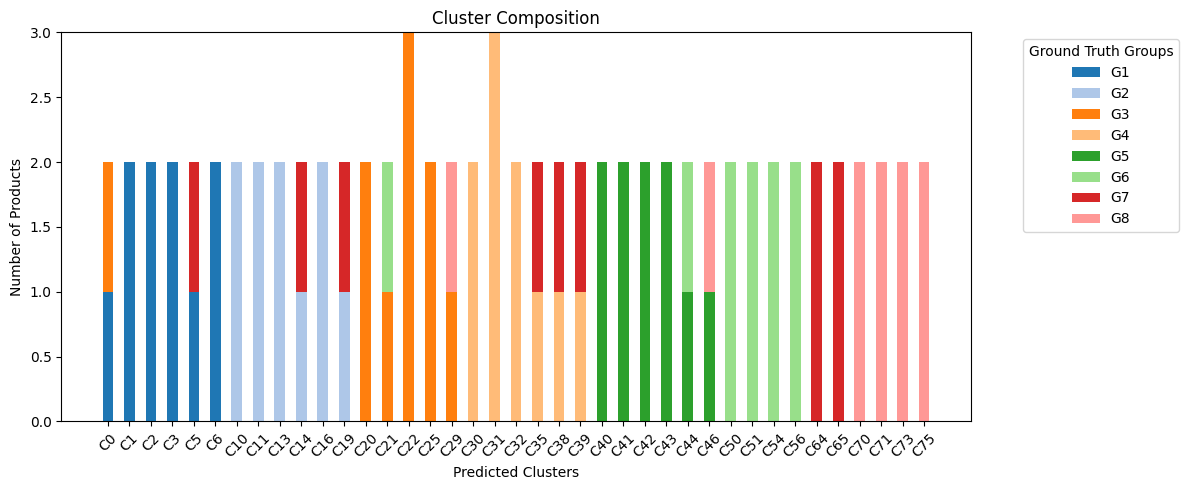


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0148, NMI: 0.1566

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P1', 'G4_P2', 'G4_P4', 'G4_P5', 'G4_P7', 'G4_P9', 'G4_P10', 'G5_P1', 'G5_P4', 'G5_P6', 'G5_P7', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P7', 'G8_P9']
Cluster 21: ['G3_P2']
Cluster 32: ['G4_P3', 'G7_P5', 'G4_P6', 'G4_P8', 'G8_P1', 'G5_P3', 'G8_P6', 'G5_P5', 'G8_P8', 'G8_P10', 'G5_P8']
Cluster 41: ['G5_P9', 'G5_P2']


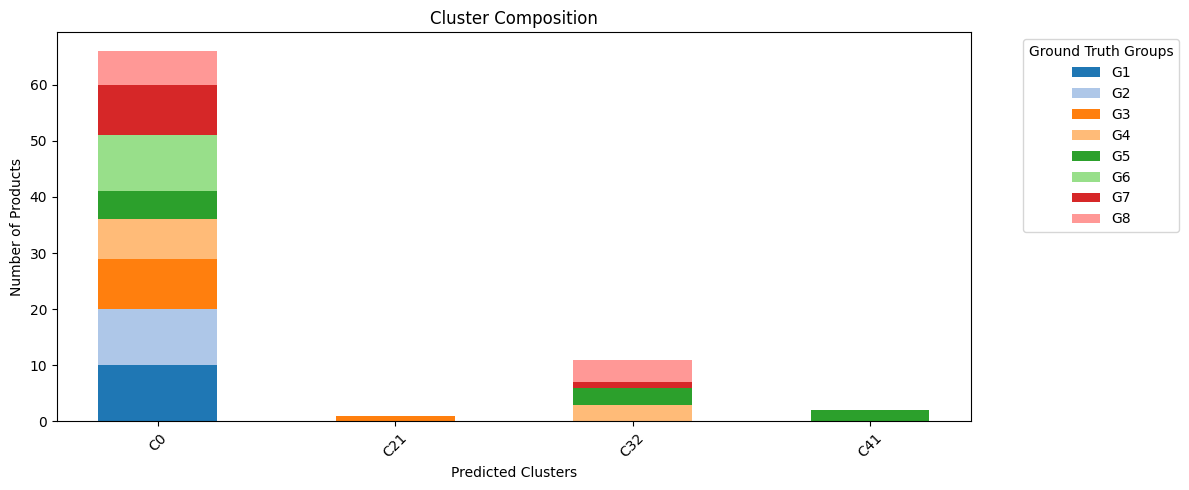


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.3527, NMI: 0.6717

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G4_P5', 'G5_P6']
Cluster 2: ['G1_P10', 'G1_P3', 'G1_P4', 'G6_P10']
Cluster 4: ['G1_P9', 'G1_P5', 'G1_P8']
Cluster 5: ['G2_P8', 'G2_P1', 'G1_P6', 'G2_P6']
Cluster 6: ['G7_P1', 'G4_P8', 'G1_P7', 'G8_P2']
Cluster 11: ['G2_P7', 'G2_P9', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 19: ['G2_P10', 'G7_P4']
Cluster 20: ['G3_P1', 'G3_P3', 'G3_P4', 'G3_P7', 'G3_P8']
Cluster 21: ['G3_P10', 'G3_P2']
Cluster 24: ['G3_P5', 'G5_P4']
Cluster 25: ['G3_P6', 'G3_P9', 'G5_P10']
Cluster 30: ['G4_P3', 'G4_P4', 'G4_P1', 'G4_P2']
Cluster 35: ['G5_P7', 'G4_P6', 'G7_P3', 'G5_P8']
Cluster 36: ['G4_P7', 'G4_P10']
Cluster 38: ['G5_P9', 'G7_P10', 'G7_P2', 'G4_P9']
Cluster 40: ['G5_P1', 'G5_P2']
Cluster 42: ['G5_P3', 'G5_P5']
Cluster 50: ['G8_P4', 'G6_P1', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P8', 'G6_P9']
Cluster 51: ['G6_P7', 'G6_P2', 'G6_P6']
Cluster 64: ['G7_P5', 'G7_P6', 

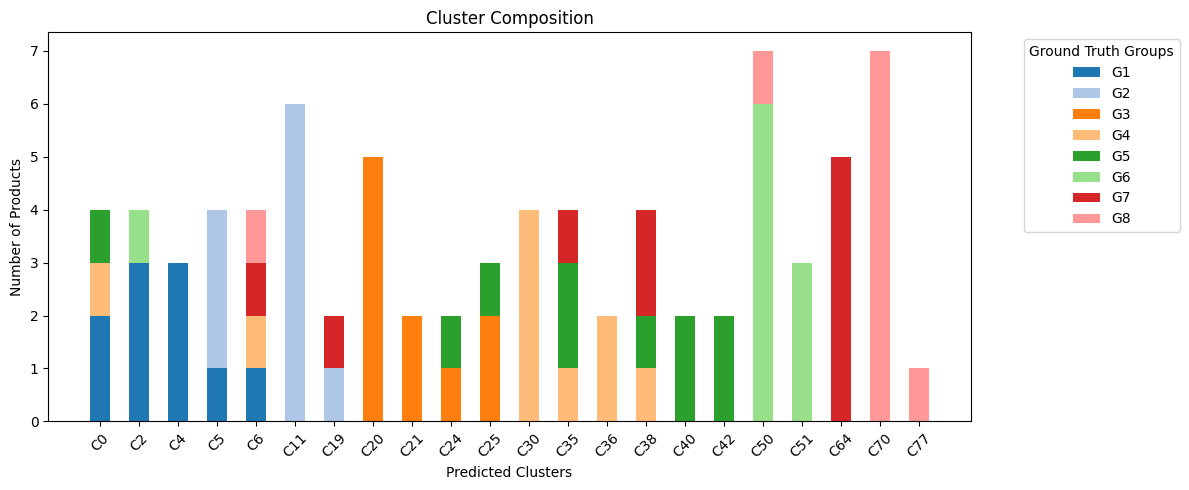


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.5855, NMI: 0.7780

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G3_P4']
Cluster 2: ['G1_P9', 'G1_P3', 'G1_P5', 'G7_P1']
Cluster 3: ['G1_P10', 'G1_P4', 'G6_P10', 'G6_P2']
Cluster 5: ['G1_P6', 'G1_P8']
Cluster 6: ['G5_P3', 'G5_P5', 'G1_P7', 'G5_P8']
Cluster 10: ['G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10']
Cluster 20: ['G3_P1', 'G3_P3', 'G3_P5', 'G3_P7', 'G3_P8']
Cluster 21: ['G3_P10', 'G3_P2']
Cluster 25: ['G5_P1', 'G3_P6', 'G3_P9', 'G5_P10']
Cluster 30: ['G4_P8', 'G4_P1']
Cluster 31: ['G4_P5', 'G4_P7', 'G4_P9', 'G4_P10', 'G5_P7', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P4']
Cluster 35: ['G4_P6', 'G7_P3']
Cluster 41: ['G5_P9', 'G5_P2', 'G5_P4', 'G5_P6']
Cluster 50: ['G6_P1', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9']
Cluster 61: ['G7_P6', 'G7_P8', 'G7_P2', 'G7_P4']
Cluster 64: ['G7_P5', 'G7_P7', 'G7_P9', 'G7_P10']
Cluster 70: ['G8_P1', 'G8_P2',

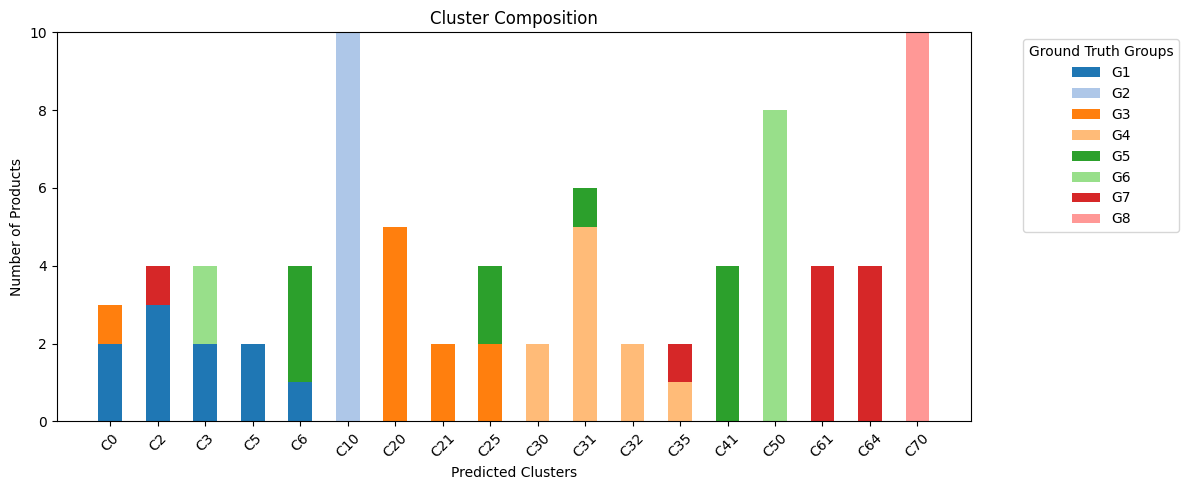


Iteration 2/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1555, NMI: 0.6717

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P7']
Cluster 1: ['G1_P2', 'G1_P6']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 3: ['G1_P4', 'G1_P8']
Cluster 4: ['G1_P10', 'G1_P5']
Cluster 10: ['G2_P1', 'G2_P3']
Cluster 11: ['G2_P8', 'G2_P2']
Cluster 13: ['G2_P4', 'G7_P3']
Cluster 14: ['G3_P5', 'G2_P5']
Cluster 15: ['G7_P9', 'G2_P6']
Cluster 16: ['G2_P7', 'G5_P4']
Cluster 18: ['G2_P9', 'G2_P10']
Cluster 20: ['G3_P1', 'G3_P10']
Cluster 21: ['G4_P3', 'G3_P2']
Cluster 22: ['G3_P8', 'G3_P3']
Cluster 23: ['G3_P6', 'G3_P4']
Cluster 26: ['G3_P7', 'G3_P9']
Cluster 30: ['G4_P1', 'G4_P10']
Cluster 31: ['G4_P5', 'G4_P2']
Cluster 33: ['G4_P4', 'G4_P8']
Cluster 35: ['G5_P2', 'G4_P6', 'G4_P7']
Cluster 38: ['G8_P9', 'G4_P9']
Cluster 40: ['G5_P1', 'G5_P7', 'G5_P8']
Cluster 42: ['G5_P9', 'G5_P3', 'G5_P5']
Cluster 45: ['G5_P10', 'G5_P6']
Cluster 50: ['G6_P1', 'G6_P3']
Cluster 51: ['G6_P2', 'G6_P6']
Clu

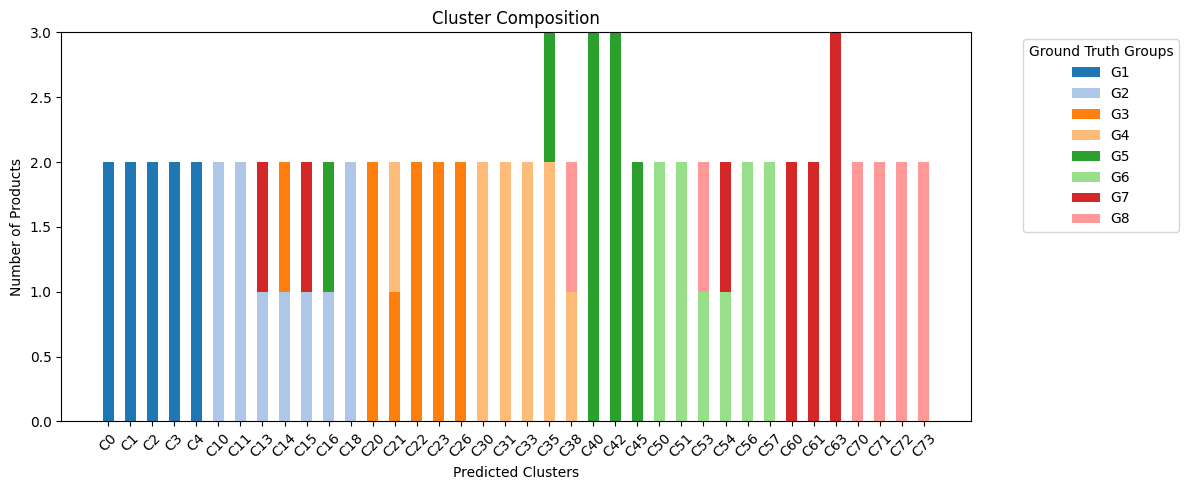


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0689, NMI: 0.2274

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P3', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P9', 'G5_P10', 'G6_P4', 'G6_P7', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']
Cluster 10: ['G7_P6', 'G2_P1']
Cluster 15: ['G8_P4', 'G2_P6', 'G2_P7', 'G4_P1', 'G4_P2', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P8', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P5', 'G6_P6', 'G6_P8']


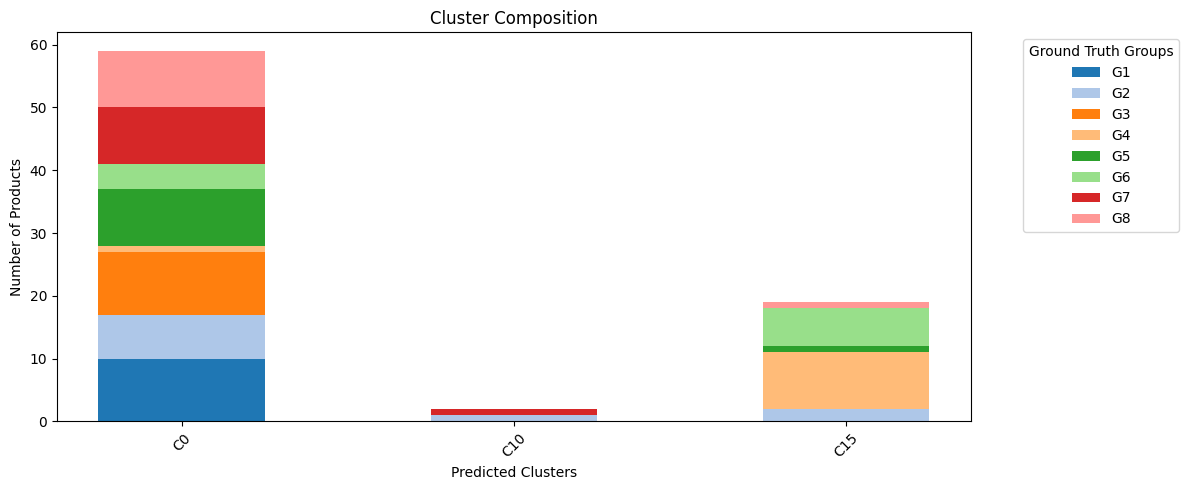


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.2991, NMI: 0.6546

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P4', 'G1_P5', 'G1_P7', 'G1_P8']
Cluster 1: ['G1_P9', 'G1_P2', 'G7_P6']
Cluster 2: ['G1_P3', 'G3_P3', 'G3_P5', 'G3_P8', 'G7_P2']
Cluster 5: ['G4_P5', 'G2_P9', 'G1_P6', 'G4_P2']
Cluster 9: ['G6_P7', 'G1_P10', 'G2_P4', 'G2_P6']
Cluster 10: ['G2_P1']
Cluster 11: ['G2_P10', 'G2_P8', 'G2_P2', 'G2_P5']
Cluster 12: ['G5_P10', 'G6_P9', 'G2_P3']
Cluster 16: ['G2_P7', 'G4_P3']
Cluster 20: ['G3_P6', 'G3_P1', 'G3_P10']
Cluster 21: ['G3_P7', 'G3_P9', 'G3_P2', 'G8_P10']
Cluster 23: ['G4_P6', 'G7_P10', 'G3_P4']
Cluster 30: ['G4_P4', 'G4_P8', 'G4_P1']
Cluster 36: ['G4_P7', 'G7_P3']
Cluster 38: ['G7_P5', 'G6_P5', 'G4_P9']
Cluster 39: ['G5_P6', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P4', 'G5_P7', 'G5_P8']
Cluster 41: ['G5_P9', 'G5_P2', 'G5_P3', 'G5_P5']
Cluster 50: ['G6_P1', 'G6_P10', 'G6_P3', 'G6_P4']
Cluster 51: ['G6_P8', 'G6_P2', 'G6_P6']
Cluster 60: ['G7_P7', 'G7_

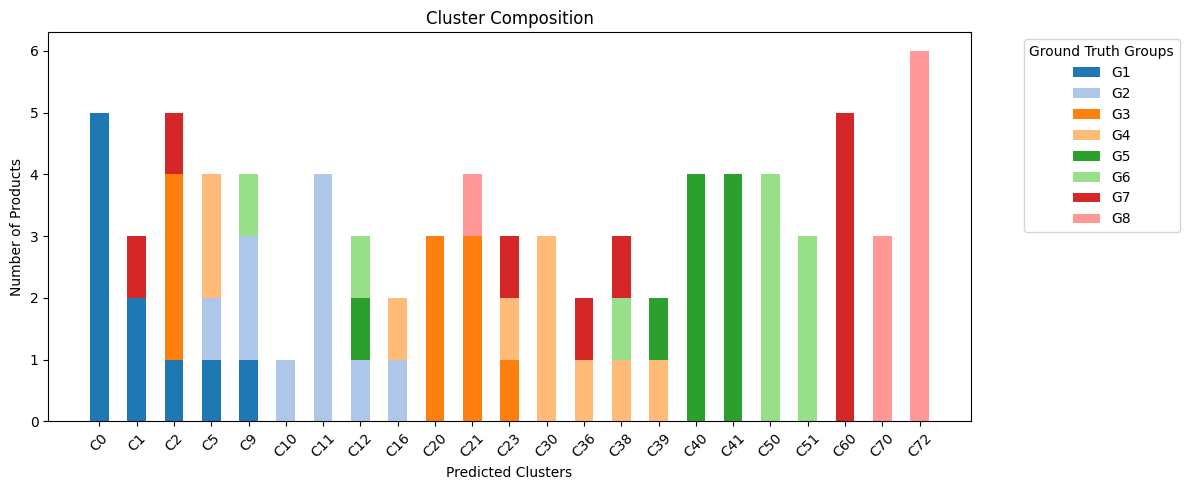


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4002, NMI: 0.7041

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P4', 'G1_P6', 'G1_P7', 'G1_P8']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 4: ['G2_P8', 'G2_P10', 'G1_P5', 'G2_P1', 'G2_P2']
Cluster 9: ['G1_P10', 'G2_P4', 'G2_P5']
Cluster 12: ['G6_P9', 'G2_P9', 'G2_P3']
Cluster 15: ['G4_P3', 'G8_P1', 'G2_P6']
Cluster 16: ['G2_P7', 'G7_P6', 'G5_P4']
Cluster 20: ['G3_P1', 'G3_P3', 'G3_P5', 'G3_P8', 'G3_P10']
Cluster 21: ['G6_P7', 'G3_P7', 'G3_P9', 'G3_P2']
Cluster 23: ['G7_P10', 'G3_P4']
Cluster 25: ['G3_P6', 'G6_P5', 'G5_P10']
Cluster 30: ['G4_P4', 'G4_P5', 'G4_P8', 'G4_P1', 'G4_P2']
Cluster 35: ['G4_P6', 'G4_P7', 'G4_P9']
Cluster 39: ['G5_P6', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P7', 'G5_P8']
Cluster 41: ['G5_P9', 'G5_P2', 'G5_P3', 'G5_P5']
Cluster 50: ['G6_P1', 'G6_P3']
Cluster 51: ['G6_P2', 'G6_P4', 'G6_P6', 'G6_P8', 'G6_P10']
Cluster 60: ['G7_P5', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P1', 'G7_P4']
Cluster 61: 

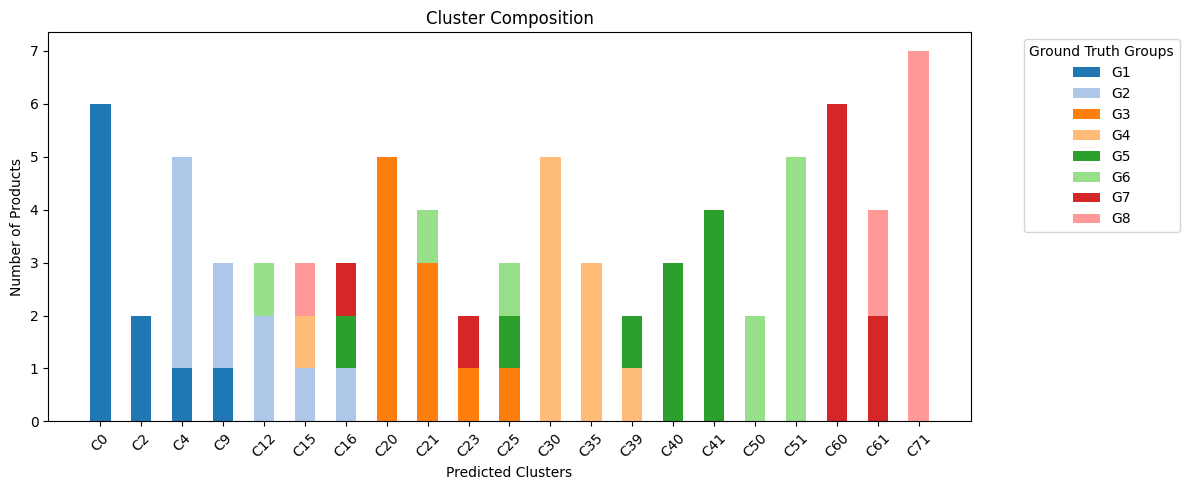


Iteration 3/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1218, NMI: 0.6387

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P9']
Cluster 1: ['G1_P2', 'G1_P4']
Cluster 2: ['G1_P3', 'G1_P6']
Cluster 4: ['G1_P5', 'G3_P4']
Cluster 6: ['G3_P5', 'G1_P7']
Cluster 7: ['G2_P7', 'G1_P8']
Cluster 9: ['G1_P10', 'G2_P1', 'G2_P2']
Cluster 12: ['G2_P3']
Cluster 13: ['G2_P4', 'G2_P6']
Cluster 14: ['G5_P6', 'G2_P5']
Cluster 17: ['G2_P8', 'G4_P1']
Cluster 18: ['G2_P9', 'G2_P10']
Cluster 20: ['G3_P1', 'G3_P3']
Cluster 21: ['G6_P4', 'G3_P2']
Cluster 25: ['G3_P6', 'G3_P9']
Cluster 26: ['G3_P7', 'G3_P10']
Cluster 27: ['G8_P6', 'G3_P8']
Cluster 31: ['G8_P9', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P9']
Cluster 33: ['G4_P4', 'G6_P3']
Cluster 34: ['G4_P5', 'G4_P6', 'G4_P7']
Cluster 37: ['G4_P8', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P5']
Cluster 41: ['G5_P2', 'G8_P7']
Cluster 42: ['G5_P3', 'G5_P7']
Cluster 43: ['G5_P4', 'G5_P8']
Cluster 48: ['G5_P9', 'G6_P1']
Cluster 49: ['G8_P3', 'G

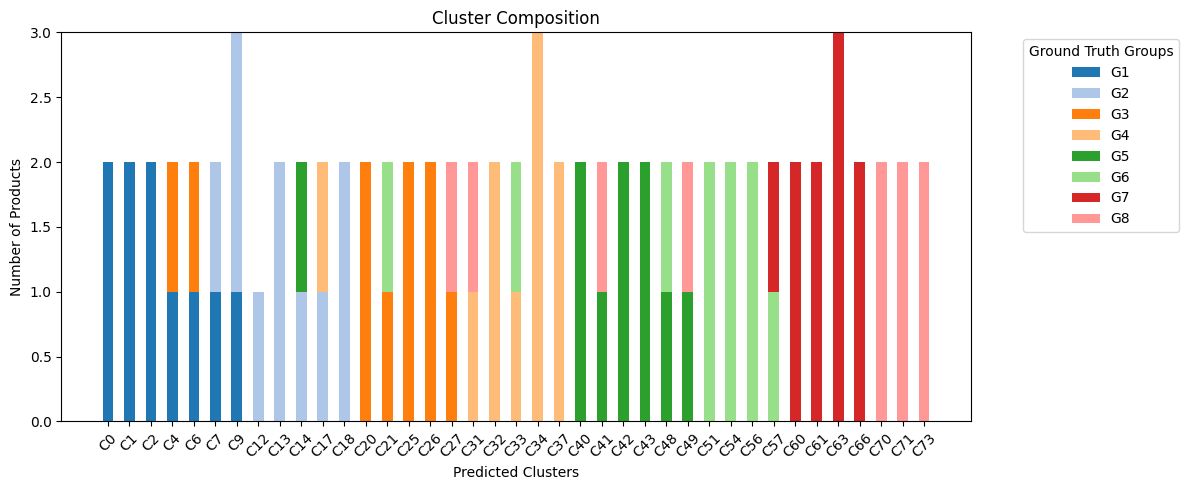


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0525, NMI: 0.2080

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G8_P5', 'G2_P7', 'G6_P7']
Cluster 3: ['G1_P4', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']


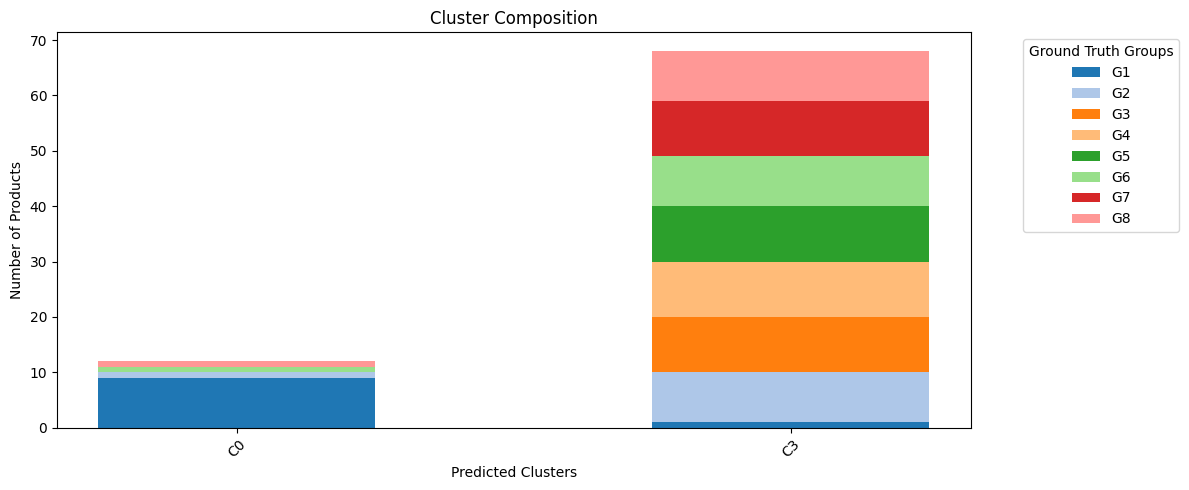


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.4601, NMI: 0.7360

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P5', 'G1_P6', 'G1_P8', 'G1_P10']
Cluster 2: ['G1_P3', 'G1_P4', 'G1_P7']
Cluster 8: ['G1_P9', 'G3_P5', 'G3_P7', 'G3_P4']
Cluster 10: ['G2_P9', 'G2_P10', 'G2_P1', 'G2_P2', 'G2_P5', 'G2_P6']
Cluster 12: ['G2_P8', 'G7_P8', 'G2_P3', 'G4_P1']
Cluster 13: ['G4_P4', 'G2_P4', 'G4_P10']
Cluster 16: ['G2_P7']
Cluster 20: ['G3_P1', 'G3_P2', 'G3_P3', 'G3_P6', 'G3_P9', 'G3_P10']
Cluster 27: ['G8_P1', 'G3_P8', 'G8_P6', 'G8_P7', 'G7_P4']
Cluster 31: ['G4_P3', 'G4_P5', 'G4_P6', 'G4_P8', 'G4_P2']
Cluster 36: ['G7_P5', 'G7_P6', 'G4_P7', 'G7_P9', 'G7_P1', 'G7_P2']
Cluster 38: ['G5_P6', 'G4_P9']
Cluster 40: ['G5_P10', 'G5_P1', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P7', 'G5_P8']
Cluster 41: ['G5_P9', 'G5_P2', 'G6_P1']
Cluster 51: ['G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6']
Cluster 56: ['G6_P7', 'G6_P9', 'G8_P2']
Cluster 57: ['G6_P8', 'G6_P10']
Cluster 62: ['G7_P7'

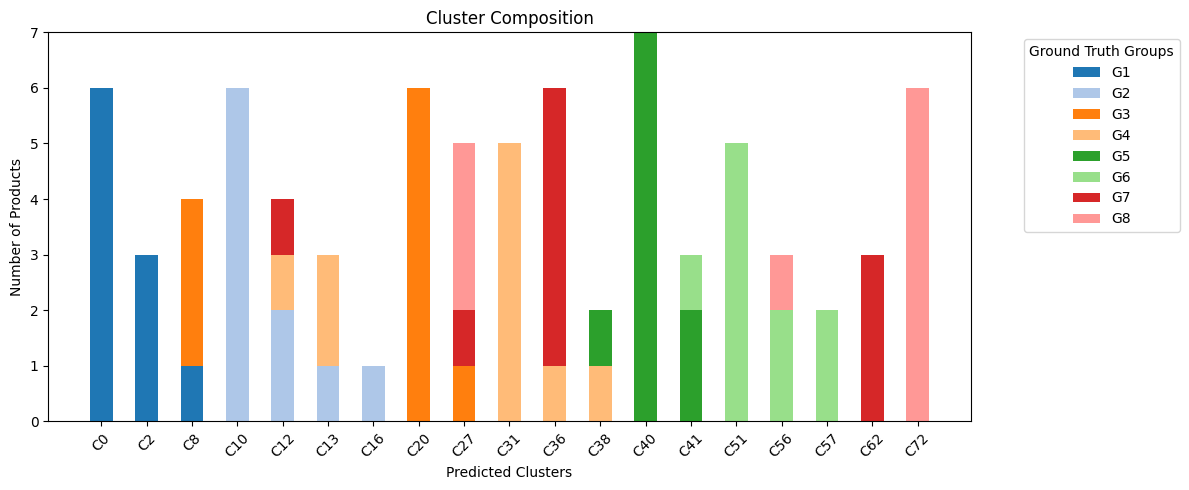


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4602, NMI: 0.7206

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G7_P9', 'G1_P8']
Cluster 2: ['G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P9']
Cluster 9: ['G2_P9', 'G2_P10', 'G1_P10', 'G2_P2', 'G2_P4', 'G2_P5']
Cluster 10: ['G2_P7', 'G2_P8', 'G2_P1', 'G2_P6']
Cluster 12: ['G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G2_P3', 'G3_P9']
Cluster 20: ['G4_P9', 'G3_P1', 'G3_P10', 'G3_P3']
Cluster 21: ['G5_P9', 'G6_P1', 'G6_P4', 'G3_P2']
Cluster 27: ['G8_P6', 'G3_P8', 'G8_P1', 'G7_P4']
Cluster 30: ['G4_P3', 'G8_P7', 'G4_P1', 'G4_P10']
Cluster 31: ['G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G8_P9', 'G4_P2']
Cluster 37: ['G5_P2', 'G7_P7', 'G7_P10', 'G4_P8']
Cluster 40: ['G5_P10', 'G5_P1', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8']
Cluster 51: ['G6_P10', 'G6_P2', 'G6_P3', 'G6_P8']
Cluster 54: ['G6_P7', 'G6_P9', 'G6_P5', 'G6_P6']
Cluster 60: ['G7_P5', 'G7_P6', 'G7_P8', 'G7_P1', 'G7_P2', 'G7_P3']
Cluster 71: ['G8_P

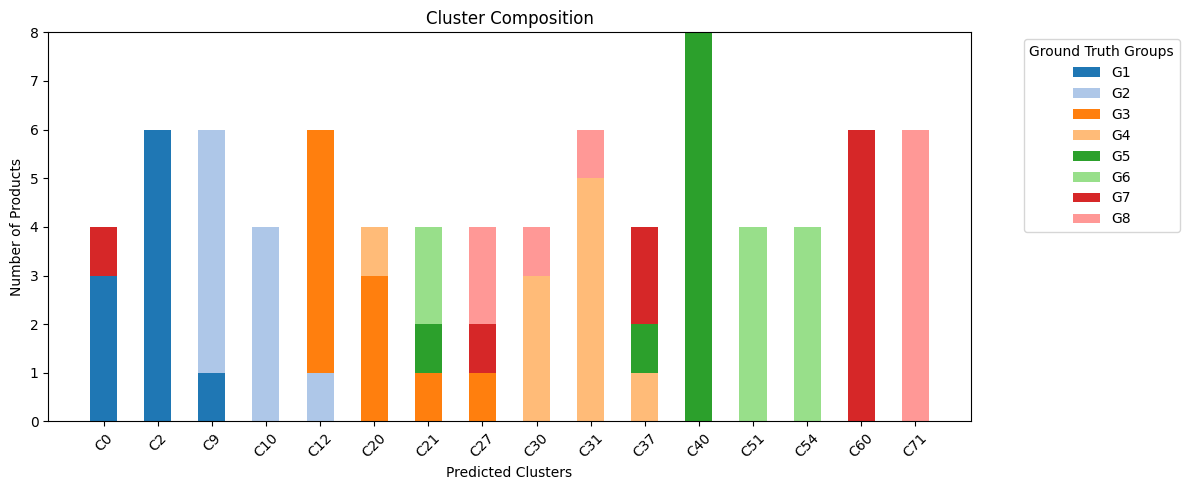


Iteration 4/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1251, NMI: 0.6549

Final Clustering Results:
Cluster 0: ['G1_P1', 'G6_P2']
Cluster 1: ['G1_P2', 'G1_P10']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 3: ['G1_P4', 'G1_P8']
Cluster 4: ['G1_P5', 'G3_P1']
Cluster 5: ['G1_P6', 'G6_P6']
Cluster 6: ['G5_P3', 'G1_P7']
Cluster 10: ['G2_P1', 'G2_P2']
Cluster 12: ['G2_P3', 'G2_P6']
Cluster 13: ['G2_P7', 'G2_P4']
Cluster 14: ['G2_P10', 'G2_P5']
Cluster 17: ['G2_P8', 'G2_P9']
Cluster 21: ['G3_P2', 'G4_P2']
Cluster 22: ['G3_P7', 'G3_P3']
Cluster 23: ['G3_P8', 'G3_P4']
Cluster 24: ['G3_P5', 'G6_P9']
Cluster 25: ['G3_P6', 'G3_P9']
Cluster 29: ['G4_P5', 'G3_P10']
Cluster 30: ['G6_P10', 'G4_P1']
Cluster 32: ['G4_P3', 'G4_P10']
Cluster 33: ['G4_P4', 'G4_P6']
Cluster 36: ['G4_P7', 'G8_P2']
Cluster 37: ['G4_P8', 'G4_P9']
Cluster 40: ['G5_P1', 'G5_P2']
Cluster 43: ['G5_P4', 'G5_P5']
Cluster 45: ['G5_P6', 'G5_P8']
Cluster 46: ['G5_P10', 'G5_P7']
Cluster 48: ['G5_P9', 'G7_P10']

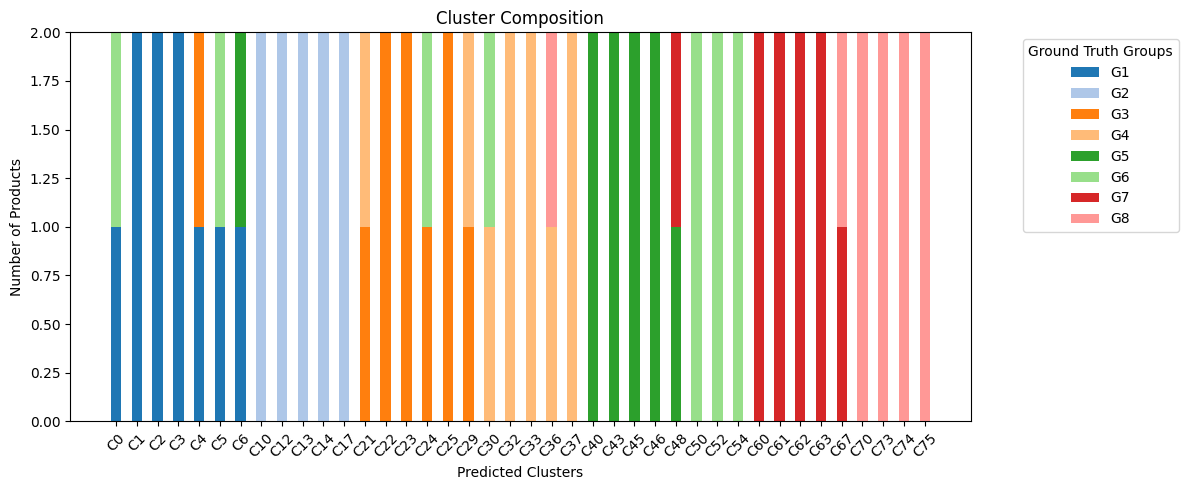


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0372, NMI: 0.1809

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P2', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G5_P2', 'G5_P4', 'G5_P5', 'G5_P7', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P7', 'G7_P8', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']
Cluster 5: ['G7_P5', 'G7_P6', 'G7_P9', 'G1_P6', 'G1_P7', 'G4_P1', 'G4_P3', 'G4_P10', 'G5_P1', 'G5_P3', 'G5_P6', 'G5_P8', 'G5_P9', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4']
Cluster 26: ['G3_P7', 'G6_P5']


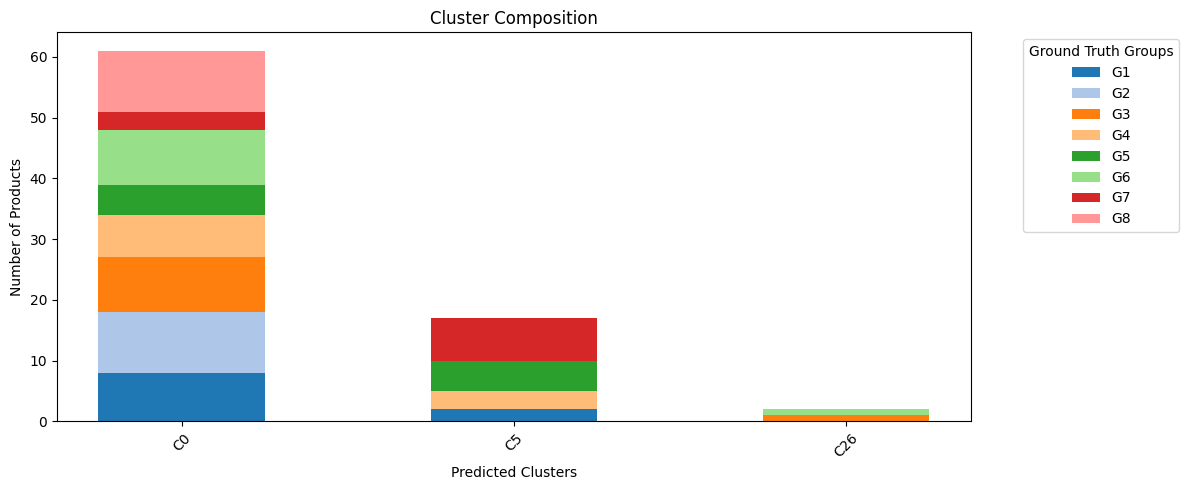


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.3229, NMI: 0.6699

Final Clustering Results:
Cluster 0: ['G1_P1', 'G6_P2', 'G3_P3', 'G8_P2']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P7', 'G1_P9', 'G1_P10']
Cluster 4: ['G3_P5', 'G3_P6', 'G1_P5', 'G3_P9']
Cluster 5: ['G2_P9', 'G2_P10', 'G1_P6', 'G2_P5']
Cluster 7: ['G1_P8']
Cluster 10: ['G2_P1', 'G2_P2', 'G4_P7']
Cluster 12: ['G2_P3', 'G6_P5', 'G2_P6']
Cluster 13: ['G2_P7', 'G2_P4', 'G4_P2']
Cluster 17: ['G2_P8', 'G6_P3', 'G6_P7', 'G3_P7', 'G5_P8']
Cluster 20: ['G3_P8', 'G3_P1', 'G3_P2', 'G3_P4']
Cluster 29: ['G4_P5', 'G3_P10']
Cluster 30: ['G4_P3', 'G4_P4', 'G4_P1']
Cluster 35: ['G4_P6', 'G4_P8', 'G4_P9', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5']
Cluster 45: ['G6_P10', 'G7_P10', 'G5_P6']
Cluster 46: ['G5_P9', 'G5_P10', 'G5_P7', 'G6_P8']
Cluster 50: ['G6_P1', 'G6_P4']
Cluster 55: ['G6_P9', 'G6_P6']
Cluster 60: ['G7_P6', 'G7_P7', 'G7_P1', 'G7_P2', 'G7_P3']
Cluster 63: ['G7_P5', 'G7_P8', 

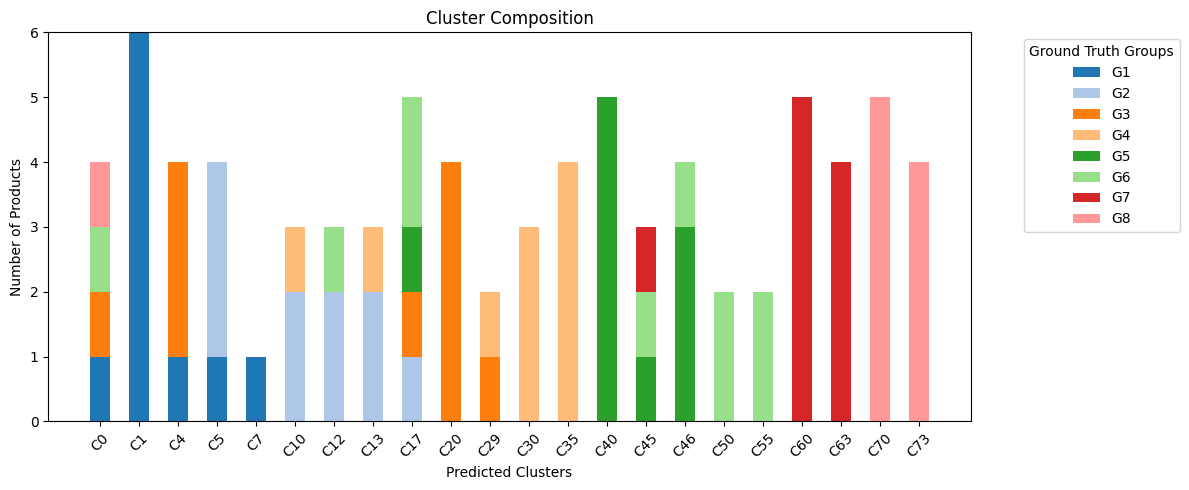


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.3301, NMI: 0.6565

Final Clustering Results:
Cluster 0: ['G1_P1', 'G6_P2', 'G3_P3', 'G8_P2']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10']
Cluster 4: ['G4_P6', 'G1_P5', 'G4_P7']
Cluster 5: ['G5_P1', 'G5_P2', 'G1_P6']
Cluster 10: ['G2_P1', 'G2_P2']
Cluster 12: ['G6_P10', 'G2_P3', 'G8_P7', 'G2_P6']
Cluster 13: ['G6_P8', 'G8_P6', 'G2_P4', 'G6_P5']
Cluster 14: ['G2_P7', 'G2_P9', 'G2_P10', 'G2_P5']
Cluster 17: ['G6_P7', 'G2_P8', 'G3_P7', 'G6_P3']
Cluster 20: ['G3_P1', 'G3_P2', 'G3_P4', 'G3_P8', 'G3_P10']
Cluster 24: ['G3_P5', 'G3_P6', 'G3_P9']
Cluster 30: ['G4_P3', 'G4_P4', 'G5_P3', 'G4_P1', 'G4_P2']
Cluster 34: ['G4_P5', 'G7_P8', 'G6_P1', 'G6_P4', 'G7_P10']
Cluster 37: ['G4_P8', 'G4_P10']
Cluster 38: ['G6_P9', 'G4_P9', 'G6_P6']
Cluster 43: ['G5_P4', 'G5_P5', 'G5_P6', 'G5_P8']
Cluster 46: ['G5_P9', 'G5_P10', 'G5_P7']
Cluster 60: ['G7_P5', 'G7_P6', 'G7_P7', 'G7_P1', 'G7_P2', 'G7_P3']
Cluster

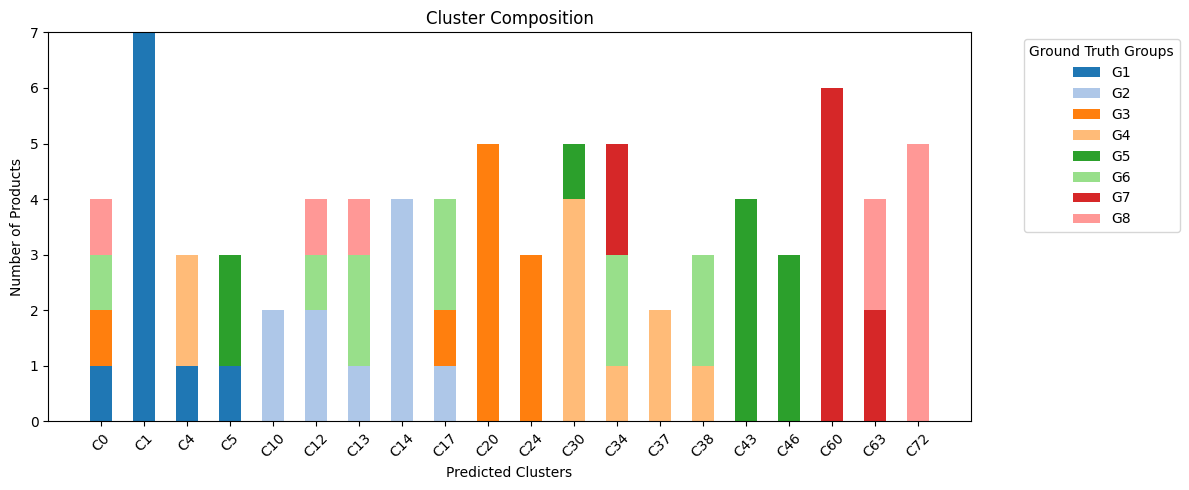


Iteration 5/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1555, NMI: 0.6717

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P6']
Cluster 1: ['G1_P2', 'G1_P5']
Cluster 2: ['G1_P3', 'G8_P8']
Cluster 3: ['G1_P4', 'G1_P7']
Cluster 7: ['G1_P10', 'G1_P8']
Cluster 8: ['G1_P9', 'G3_P4']
Cluster 10: ['G2_P1', 'G2_P5']
Cluster 11: ['G2_P10', 'G8_P6', 'G2_P2']
Cluster 12: ['G2_P8', 'G2_P3']
Cluster 13: ['G5_P9', 'G2_P4']
Cluster 15: ['G6_P5', 'G2_P6']
Cluster 16: ['G2_P7', 'G2_P9']
Cluster 20: ['G3_P8', 'G3_P1', 'G3_P9']
Cluster 21: ['G3_P2', 'G3_P3']
Cluster 24: ['G3_P5', 'G3_P7']
Cluster 25: ['G3_P6', 'G3_P10']
Cluster 30: ['G4_P9', 'G4_P1']
Cluster 31: ['G8_P9', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P5', 'G4_P10']
Cluster 33: ['G4_P4', 'G4_P6']
Cluster 36: ['G4_P7', 'G4_P8']
Cluster 40: ['G5_P1', 'G5_P6']
Cluster 41: ['G5_P2', 'G5_P7']
Cluster 42: ['G5_P3', 'G5_P4']
Cluster 44: ['G5_P5', 'G5_P8']
Cluster 49: ['G5_P10', 'G6_P3']
Cluster 50: ['G6_P8', 'G6_P1', 'G6_

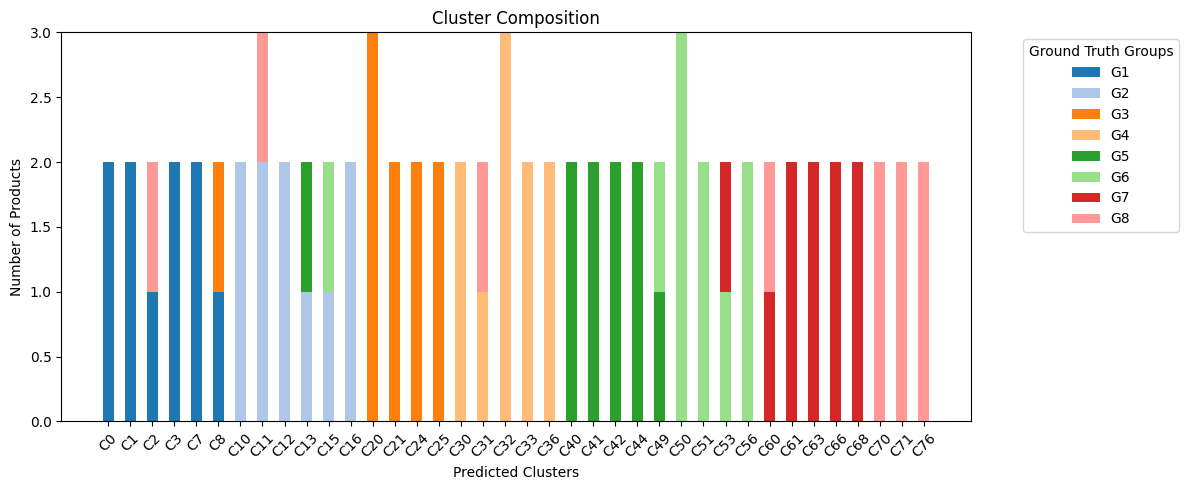


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1642, NMI: 0.3786

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P1', 'G7_P5', 'G2_P3', 'G2_P5', 'G8_P10', 'G2_P7', 'G2_P8', 'G2_P9', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G7_P2', 'G7_P3']
Cluster 11: ['G2_P10', 'G2_P2', 'G8_P3', 'G8_P6', 'G8_P9']
Cluster 13: ['G2_P4', 'G2_P6', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P4', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P4', 'G8_P5', 'G8_P7', 'G8_P8']


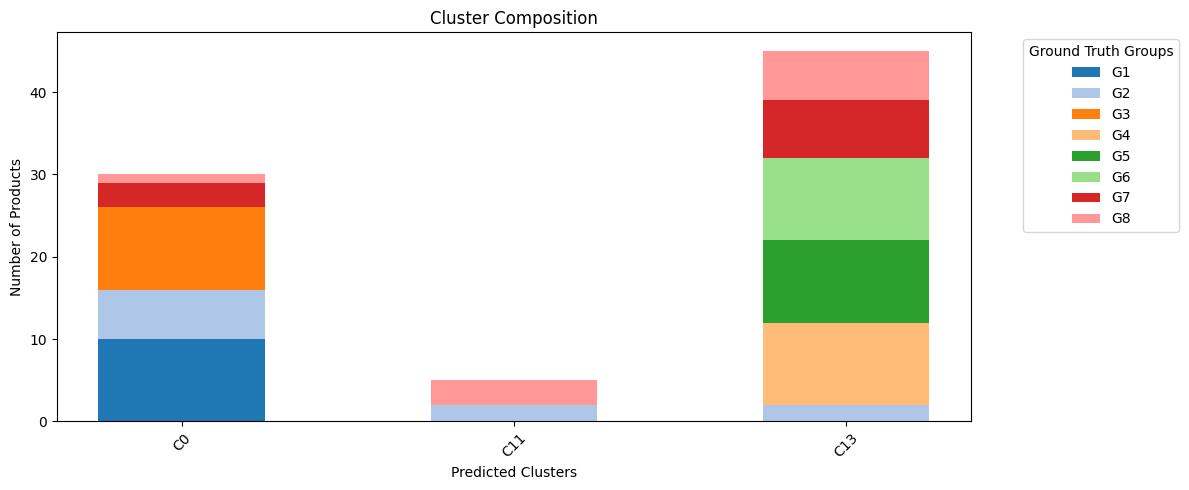


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.4166, NMI: 0.7263

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P7', 'G5_P1', 'G1_P10']
Cluster 4: ['G1_P9', 'G1_P5', 'G1_P6', 'G1_P8']
Cluster 10: ['G2_P7', 'G2_P1', 'G2_P3', 'G7_P1']
Cluster 11: ['G2_P8', 'G2_P2', 'G2_P4', 'G2_P5']
Cluster 15: ['G6_P2', 'G6_P5', 'G2_P6']
Cluster 18: ['G2_P9']
Cluster 19: ['G8_P6', 'G2_P10']
Cluster 20: ['G3_P1', 'G3_P2', 'G3_P4', 'G3_P6', 'G3_P8', 'G3_P9']
Cluster 22: ['G3_P5', 'G3_P7', 'G6_P9', 'G3_P3']
Cluster 29: ['G5_P9', 'G5_P10', 'G5_P6', 'G6_P3', 'G3_P10']
Cluster 30: ['G4_P3', 'G4_P4', 'G4_P6', 'G4_P7', 'G4_P9', 'G4_P1', 'G4_P2']
Cluster 34: ['G4_P5', 'G4_P8', 'G4_P10']
Cluster 41: ['G5_P2', 'G5_P3', 'G5_P5', 'G5_P7']
Cluster 43: ['G8_P3', 'G5_P4', 'G7_P9']
Cluster 47: ['G8_P5', 'G8_P7', 'G8_P10', 'G5_P8']
Cluster 50: ['G6_P7', 'G6_P1', 'G6_P10']
Cluster 53: ['G6_P8', 'G6_P4', 'G6_P6']
Cluster 61: ['G7_P5', 'G7_P6', 'G7_P10', 'G7_P2', 'G7_

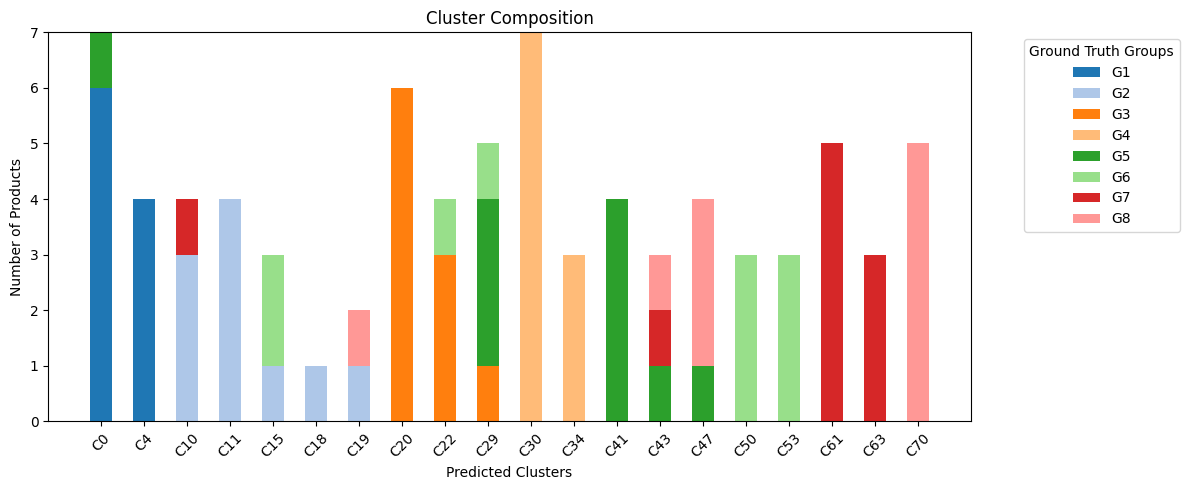


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.5331, NMI: 0.7606

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P10']
Cluster 8: ['G1_P9', 'G2_P8', 'G2_P9', 'G2_P3']
Cluster 10: ['G2_P1', 'G8_P9']
Cluster 11: ['G2_P7', 'G2_P10', 'G2_P2', 'G2_P5', 'G2_P6']
Cluster 13: ['G6_P4', 'G2_P4']
Cluster 20: ['G3_P1', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10']
Cluster 21: ['G8_P6', 'G3_P2', 'G8_P2']
Cluster 22: ['G3_P3', 'G4_P1']
Cluster 23: ['G8_P3', 'G8_P5', 'G5_P4', 'G3_P4']
Cluster 31: ['G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P2']
Cluster 32: ['G4_P3', 'G6_P9', 'G6_P2', 'G6_P5']
Cluster 40: ['G5_P9', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P5', 'G5_P7']
Cluster 45: ['G5_P10', 'G6_P3', 'G5_P6', 'G5_P8']
Cluster 50: ['G6_P7', 'G6_P1', 'G6_P10']
Cluster 55: ['G6_P8', 'G6_P6']
Cluster 60: ['G7_P5', 'G7_P9', 'G7_P10', 'G7_P1', 'G7_P2', 'G7_P3']
Cluster 63: ['G7_P6', 'G7_P7', 

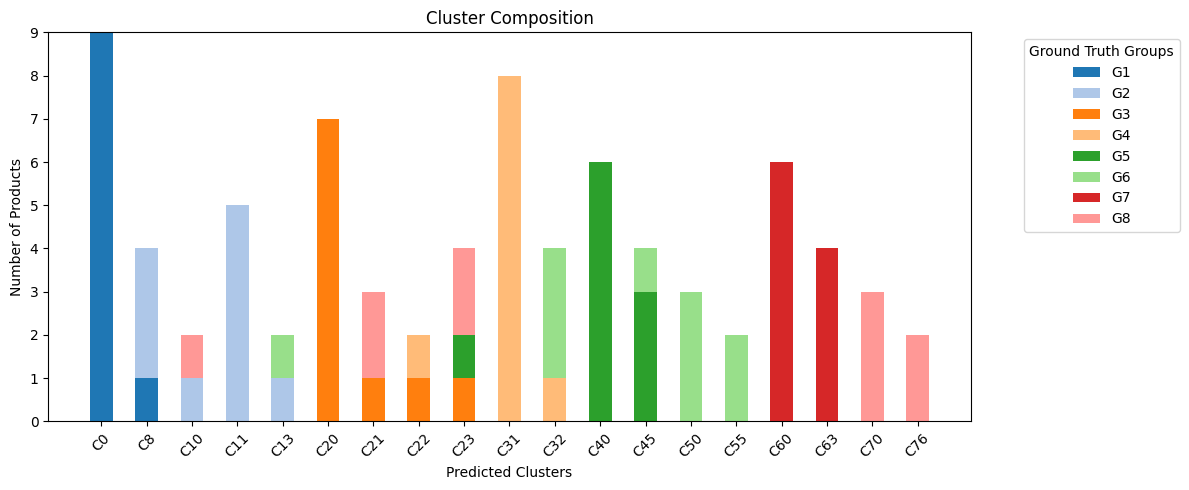


Iteration 6/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1328, NMI: 0.6561

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P6']
Cluster 1: ['G1_P2', 'G5_P6']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 3: ['G1_P4', 'G4_P9']
Cluster 4: ['G1_P10', 'G1_P5']
Cluster 6: ['G1_P7', 'G1_P8']
Cluster 10: ['G2_P1', 'G7_P3']
Cluster 11: ['G2_P2', 'G2_P6']
Cluster 12: ['G2_P9', 'G2_P3']
Cluster 13: ['G2_P10', 'G2_P4']
Cluster 14: ['G2_P8', 'G2_P5']
Cluster 16: ['G2_P7', 'G3_P6']
Cluster 20: ['G3_P5', 'G3_P1']
Cluster 21: ['G3_P10', 'G3_P2']
Cluster 22: ['G3_P8', 'G3_P3']
Cluster 23: ['G3_P7', 'G3_P4']
Cluster 28: ['G5_P10', 'G3_P9']
Cluster 30: ['G4_P1', 'G4_P10']
Cluster 31: ['G5_P5', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P7']
Cluster 33: ['G4_P4', 'G4_P8']
Cluster 34: ['G4_P5', 'G7_P8', 'G7_P10']
Cluster 35: ['G4_P6', 'G6_P5']
Cluster 40: ['G5_P1', 'G5_P8']
Cluster 41: ['G5_P2', 'G5_P4']
Cluster 42: ['G5_P3', 'G5_P7']
Cluster 48: ['G5_P9', 'G8_P8']
Cluster 50: ['G6_P1',

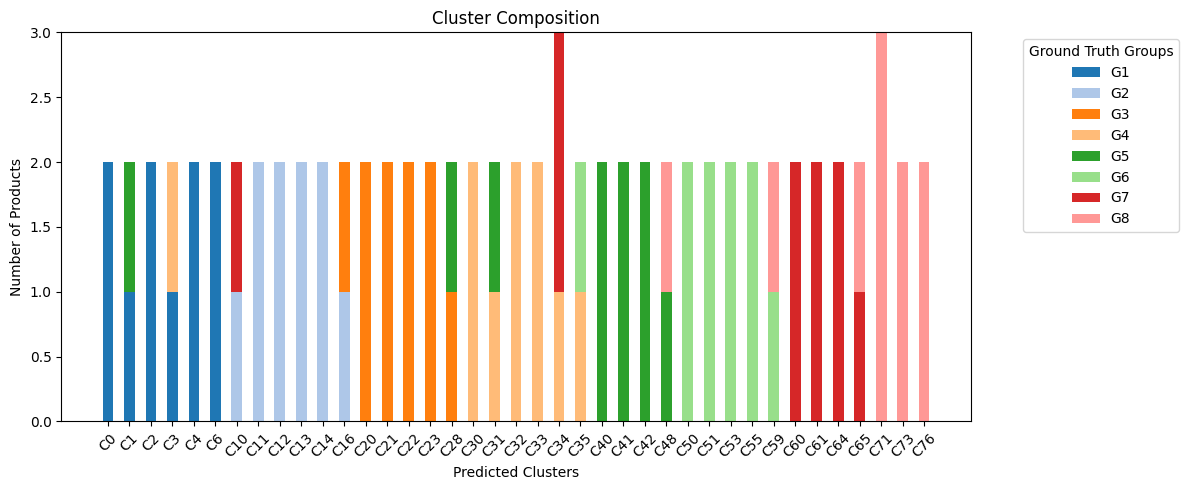


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0679, NMI: 0.2288

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P1', 'G2_P9', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P4', 'G5_P6', 'G5_P8', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']
Cluster 4: ['G1_P5', 'G4_P7', 'G5_P1', 'G5_P2', 'G5_P3', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G5_P9', 'G2_P10', 'G5_P10', 'G5_P5', 'G5_P7']


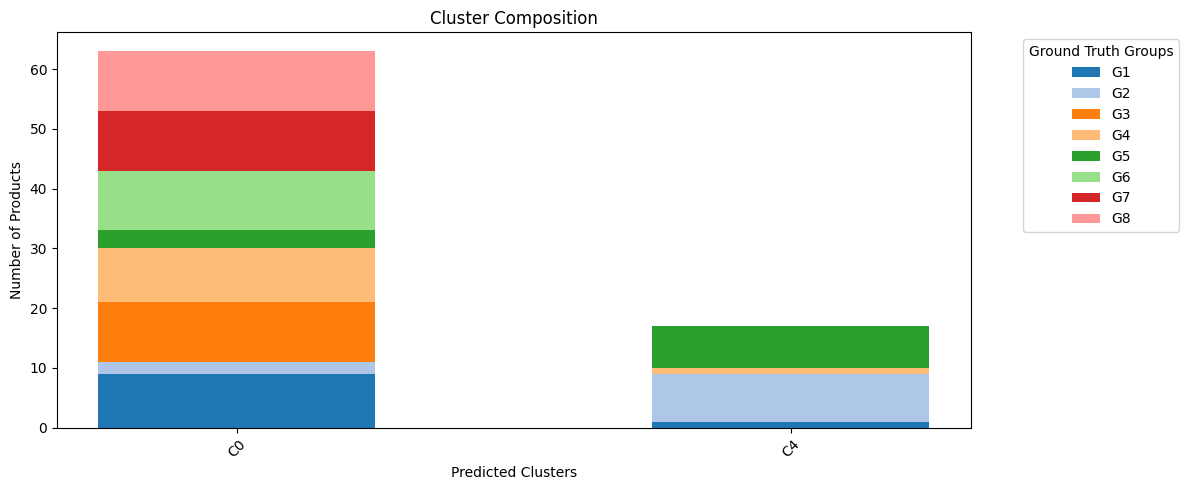


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.3376, NMI: 0.6752

Final Clustering Results:
Cluster 0: ['G1_P1', 'G2_P1', 'G1_P6', 'G2_P6']
Cluster 1: ['G1_P2', 'G1_P4', 'G6_P4', 'G4_P9']
Cluster 2: ['G1_P3', 'G1_P5', 'G1_P8', 'G1_P9', 'G1_P10']
Cluster 6: ['G6_P5', 'G6_P3', 'G3_P2', 'G1_P7']
Cluster 11: ['G2_P10', 'G2_P2', 'G2_P4', 'G2_P5']
Cluster 12: ['G2_P9', 'G2_P3']
Cluster 16: ['G2_P7', 'G2_P8', 'G7_P8']
Cluster 20: ['G3_P5', 'G3_P6', 'G7_P5', 'G3_P1']
Cluster 22: ['G3_P3', 'G3_P4', 'G3_P7', 'G3_P8', 'G3_P10']
Cluster 28: ['G4_P5', 'G8_P6', 'G3_P9']
Cluster 30: ['G5_P10', 'G6_P9', 'G4_P1', 'G4_P10']
Cluster 31: ['G4_P3', 'G4_P6', 'G4_P7', 'G5_P5', 'G4_P2']
Cluster 33: ['G4_P4', 'G5_P4', 'G4_P8', 'G5_P2']
Cluster 40: ['G5_P1', 'G5_P3', 'G5_P6', 'G5_P7', 'G5_P8']
Cluster 48: ['G5_P9', 'G8_P3', 'G8_P7', 'G8_P8', 'G8_P10']
Cluster 50: ['G6_P1', 'G6_P2', 'G6_P6', 'G6_P8', 'G6_P10']
Cluster 56: ['G6_P7']
Cluster 60: ['G7_P7', 'G7_P9', 'G7_P10', 'G7_P1', 'G7_P3

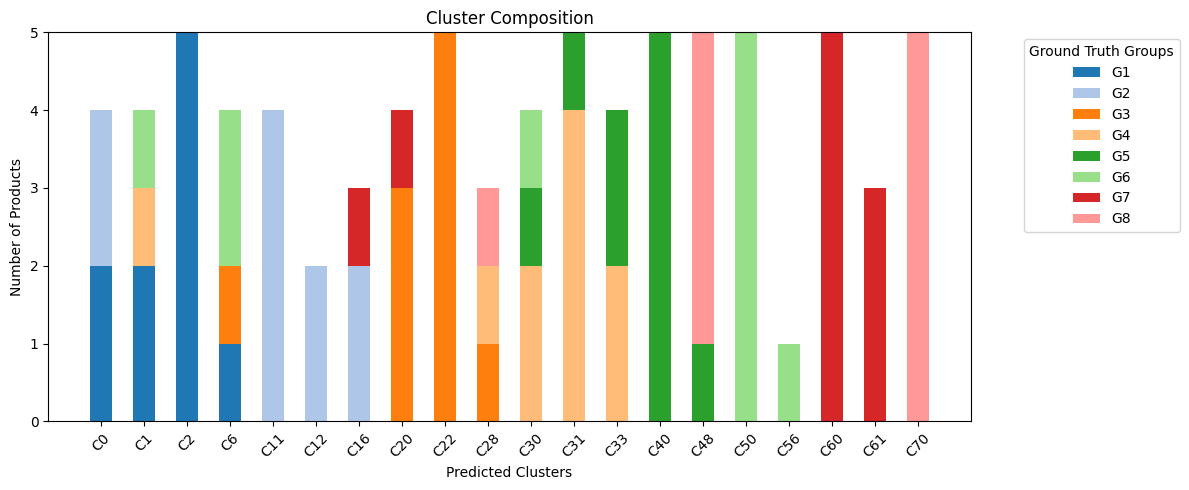


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4694, NMI: 0.7543

Final Clustering Results:
Cluster 0: ['G1_P1', 'G3_P6', 'G6_P4']
Cluster 1: ['G1_P2', 'G1_P5', 'G1_P6', 'G1_P10']
Cluster 2: ['G1_P9', 'G1_P3', 'G4_P9']
Cluster 3: ['G1_P4', 'G1_P7', 'G1_P8']
Cluster 10: ['G2_P1', 'G2_P2', 'G2_P6']
Cluster 12: ['G2_P9', 'G2_P3']
Cluster 13: ['G2_P7', 'G2_P8', 'G2_P10', 'G2_P4', 'G2_P5']
Cluster 20: ['G3_P1', 'G3_P2', 'G3_P4', 'G3_P5', 'G3_P7', 'G3_P10']
Cluster 22: ['G3_P8', 'G3_P9', 'G3_P3']
Cluster 30: ['G5_P10', 'G8_P7', 'G4_P1', 'G8_P10']
Cluster 31: ['G4_P3', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P2']
Cluster 33: ['G4_P4', 'G4_P8', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P2', 'G5_P3', 'G5_P7', 'G5_P8']
Cluster 43: ['G6_P2', 'G5_P4', 'G6_P6']
Cluster 44: ['G7_P6', 'G5_P5']
Cluster 45: ['G5_P9', 'G8_P6', 'G8_P8', 'G5_P6']
Cluster 50: ['G6_P1', 'G6_P3', 'G6_P5', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10']
Cluster 60: ['G7_P5', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P1', 'G7_P3

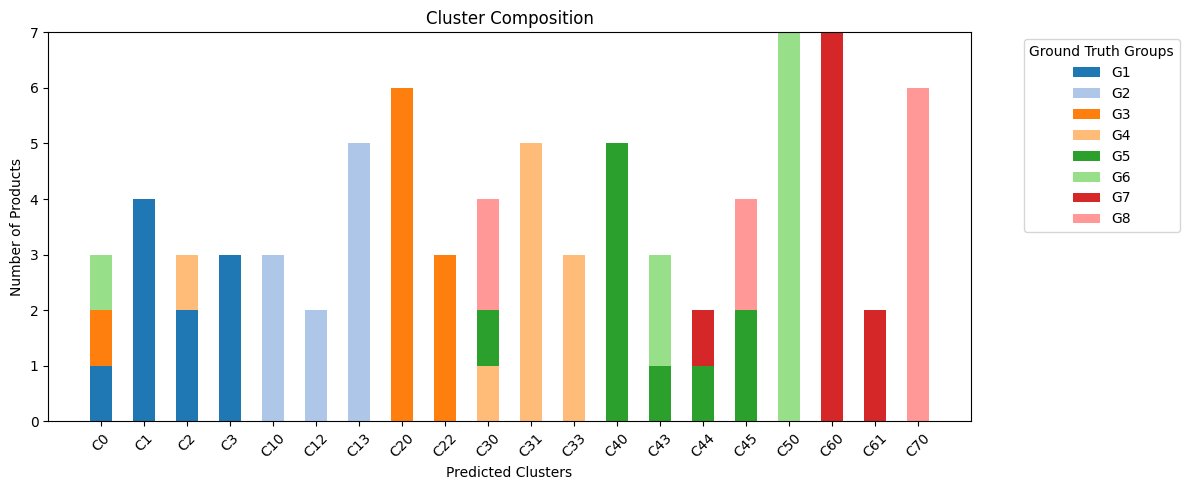


Iteration 7/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1124, NMI: 0.6319

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P6']
Cluster 1: ['G1_P2', 'G5_P3']
Cluster 2: ['G1_P3', 'G8_P6']
Cluster 3: ['G1_P4', 'G8_P1']
Cluster 4: ['G1_P5', 'G7_P9']
Cluster 6: ['G3_P6', 'G1_P7']
Cluster 7: ['G1_P9', 'G1_P8']
Cluster 9: ['G1_P10', 'G8_P5']
Cluster 10: ['G2_P1', 'G2_P9']
Cluster 11: ['G2_P2', 'G2_P5']
Cluster 12: ['G2_P3', 'G4_P8']
Cluster 13: ['G6_P9', 'G2_P4']
Cluster 15: ['G2_P7', 'G2_P6']
Cluster 17: ['G2_P8', 'G4_P5']
Cluster 19: ['G4_P3', 'G2_P10']
Cluster 20: ['G3_P8', 'G3_P1']
Cluster 21: ['G3_P7', 'G6_P1', 'G3_P2']
Cluster 22: ['G5_P10', 'G3_P3']
Cluster 23: ['G3_P5', 'G3_P4']
Cluster 28: ['G3_P9', 'G3_P10']
Cluster 30: ['G4_P7', 'G4_P1']
Cluster 31: ['G4_P9', 'G4_P2']
Cluster 33: ['G4_P4', 'G4_P6']
Cluster 39: ['G6_P2', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P6']
Cluster 41: ['G5_P2', 'G5_P8']
Cluster 43: ['G5_P9', 'G5_P4', 'G5_P7']
Cluster 44: ['G

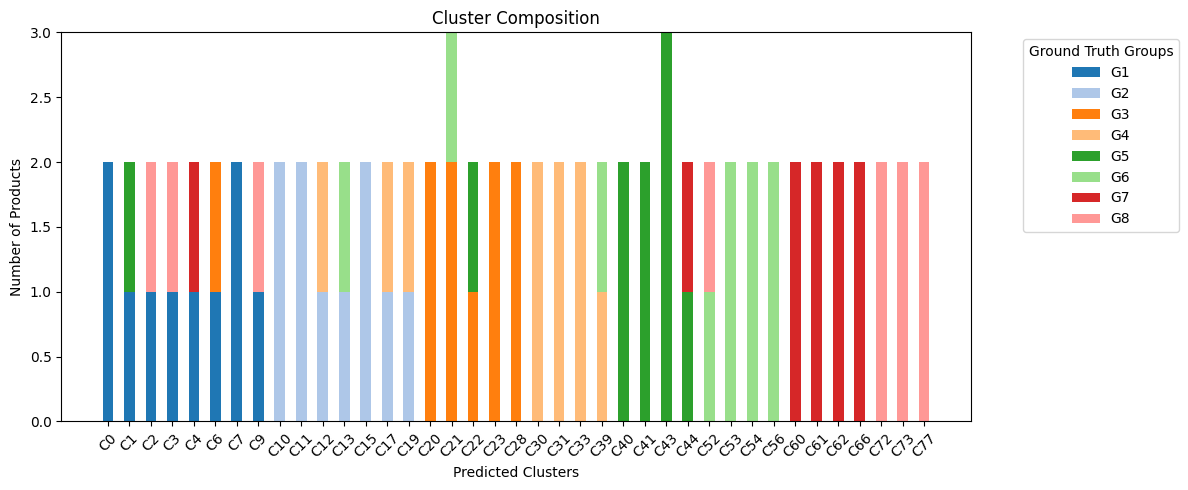


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0310, NMI: 0.1900

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P2', 'G5_P8', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']
Cluster 3: ['G1_P4']
Cluster 9: ['G5_P1', 'G1_P10', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P9']


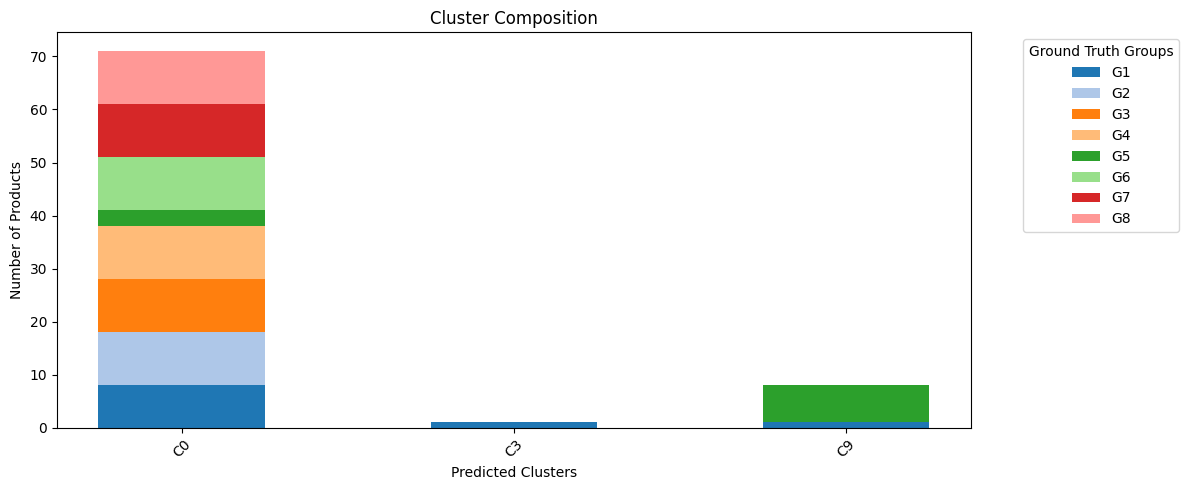


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.2868, NMI: 0.6493

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P6']
Cluster 2: ['G5_P9', 'G1_P3', 'G5_P8']
Cluster 3: ['G7_P8', 'G1_P4', 'G5_P5']
Cluster 4: ['G7_P7', 'G1_P5', 'G7_P2', 'G7_P9']
Cluster 6: ['G5_P10', 'G1_P7']
Cluster 7: ['G1_P9', 'G6_P6', 'G6_P5', 'G1_P8']
Cluster 9: ['G1_P10', 'G8_P5', 'G6_P1']
Cluster 10: ['G2_P7', 'G2_P9', 'G2_P1', 'G2_P3', 'G2_P6']
Cluster 11: ['G8_P4', 'G3_P7', 'G2_P2']
Cluster 13: ['G2_P10', 'G2_P4']
Cluster 14: ['G3_P5', 'G5_P1', 'G2_P5', 'G3_P4']
Cluster 17: ['G2_P8', 'G4_P5', 'G4_P10', 'G4_P2']
Cluster 20: ['G3_P8', 'G3_P1', 'G3_P9', 'G3_P3']
Cluster 21: ['G4_P3', 'G3_P10', 'G3_P2']
Cluster 25: ['G3_P6', 'G6_P9', 'G5_P2']
Cluster 30: ['G7_P6', 'G4_P4', 'G4_P7', 'G4_P8', 'G4_P1']
Cluster 35: ['G4_P6', 'G4_P9']
Cluster 42: ['G5_P3', 'G5_P4', 'G5_P6', 'G5_P7']
Cluster 51: ['G6_P2', 'G6_P3', 'G6_P4', 'G6_P7', 'G6_P10']
Cluster 57: ['G6_P8']
Cluster 60: ['G7_P5',

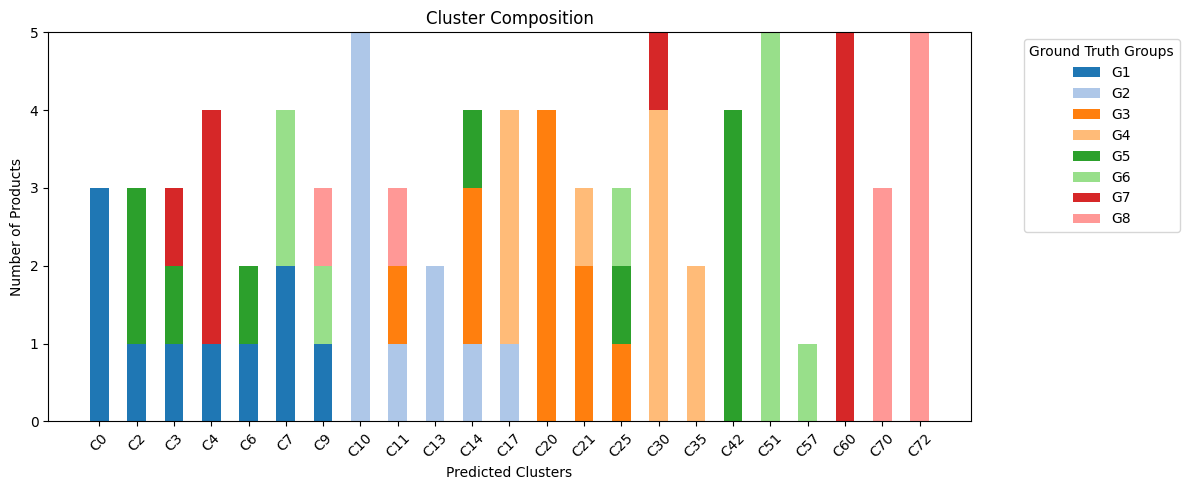


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4380, NMI: 0.7234

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P5', 'G1_P6']
Cluster 2: ['G1_P10', 'G1_P3', 'G8_P5']
Cluster 3: ['G1_P4', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P8']
Cluster 6: ['G1_P9', 'G1_P8', 'G1_P7', 'G6_P6']
Cluster 10: ['G2_P7', 'G2_P9', 'G2_P10', 'G2_P1', 'G2_P3', 'G2_P4', 'G2_P6']
Cluster 11: ['G4_P9', 'G4_P6', 'G2_P2', 'G2_P5']
Cluster 17: ['G2_P8', 'G4_P5', 'G4_P2', 'G4_P10']
Cluster 20: ['G3_P8', 'G3_P1']
Cluster 21: ['G3_P2', 'G3_P4', 'G3_P5', 'G3_P7', 'G3_P9', 'G3_P10']
Cluster 22: ['G5_P4', 'G5_P5', 'G3_P3']
Cluster 25: ['G3_P6', 'G6_P9', 'G5_P8', 'G5_P2']
Cluster 30: ['G8_P9', 'G4_P7', 'G4_P8', 'G4_P1']
Cluster 32: ['G4_P3', 'G8_P4']
Cluster 33: ['G4_P4', 'G5_P10']
Cluster 40: ['G5_P9', 'G5_P1', 'G5_P3', 'G5_P6', 'G5_P7']
Cluster 50: ['G6_P7', 'G6_P2', 'G6_P1', 'G6_P10']
Cluster 60: ['G7_P8', 'G7_P1', 'G7_P3', 'G7_P4']
Cluster 61: ['G7_P5', 'G7_P6', 'G7_P7', 'G7_P9', 'G7_P10'

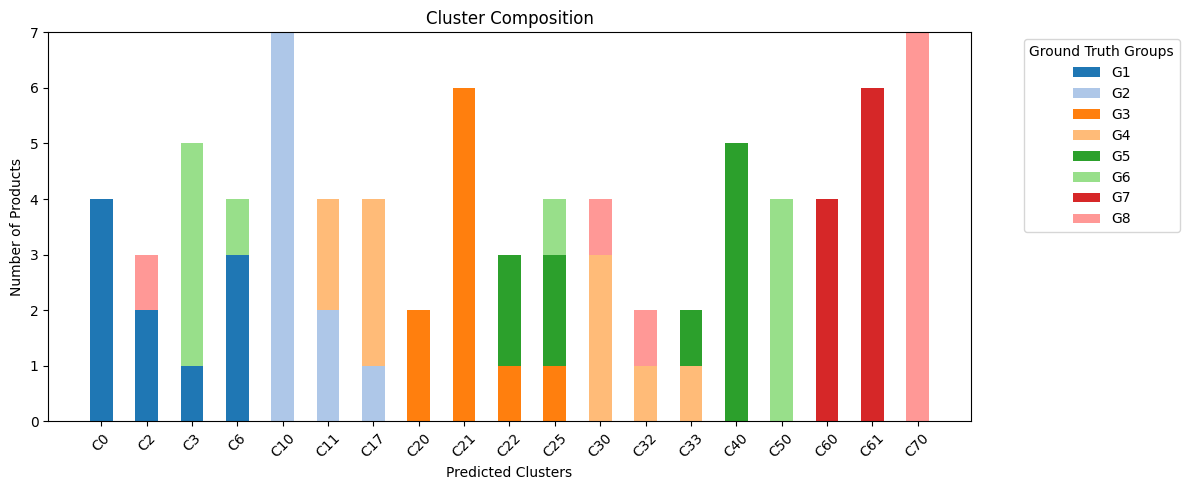


Iteration 8/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1378, NMI: 0.6659

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P10']
Cluster 1: ['G1_P2', 'G1_P6']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 3: ['G1_P4', 'G1_P7']
Cluster 4: ['G1_P5', 'G1_P8']
Cluster 10: ['G2_P1', 'G2_P9']
Cluster 11: ['G2_P2', 'G2_P5']
Cluster 12: ['G2_P10', 'G2_P3']
Cluster 13: ['G2_P8', 'G2_P4']
Cluster 15: ['G4_P1', 'G2_P6']
Cluster 16: ['G2_P7', 'G6_P7']
Cluster 20: ['G3_P6', 'G3_P1']
Cluster 21: ['G3_P7', 'G3_P2']
Cluster 22: ['G3_P8', 'G3_P3']
Cluster 23: ['G3_P10', 'G3_P4']
Cluster 24: ['G3_P5', 'G6_P8', 'G6_P4']
Cluster 28: ['G5_P1', 'G3_P9']
Cluster 31: ['G4_P4', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P10']
Cluster 34: ['G4_P5', 'G4_P6']
Cluster 36: ['G7_P7', 'G4_P7']
Cluster 37: ['G4_P8', 'G4_P9']
Cluster 41: ['G5_P2', 'G5_P5']
Cluster 42: ['G5_P10', 'G5_P3']
Cluster 43: ['G5_P4', 'G5_P6']
Cluster 46: ['G5_P7', 'G5_P8']
Cluster 48: ['G5_P9', 'G6_P5']
Cluster 50: ['G6_P1',

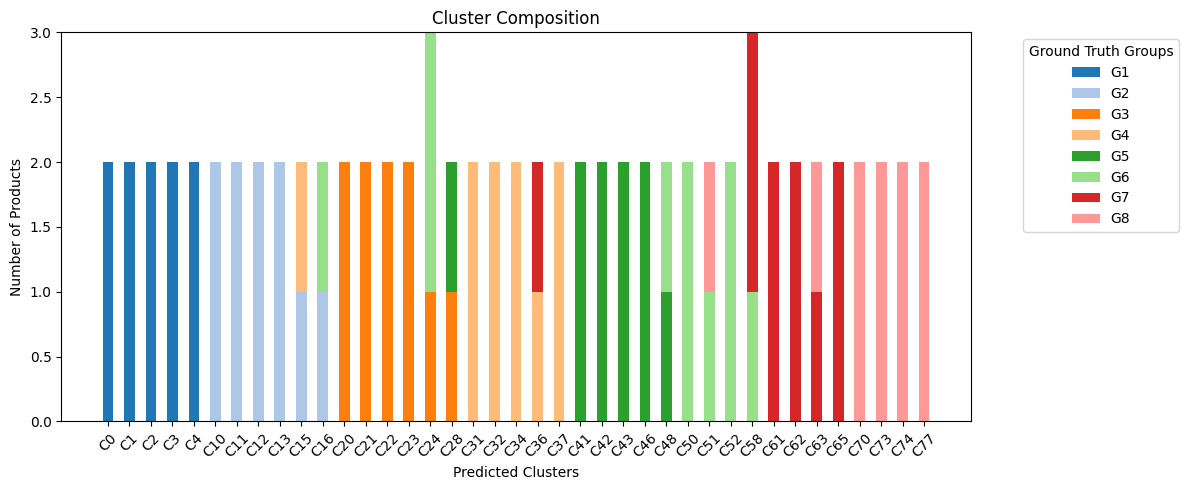


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0105, NMI: 0.1493

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']
Cluster 5: ['G6_P3', 'G1_P6', 'G7_P9', 'G7_P1', 'G7_P2']
Cluster 10: ['G2_P1', 'G2_P2', 'G2_P3', 'G2_P4']


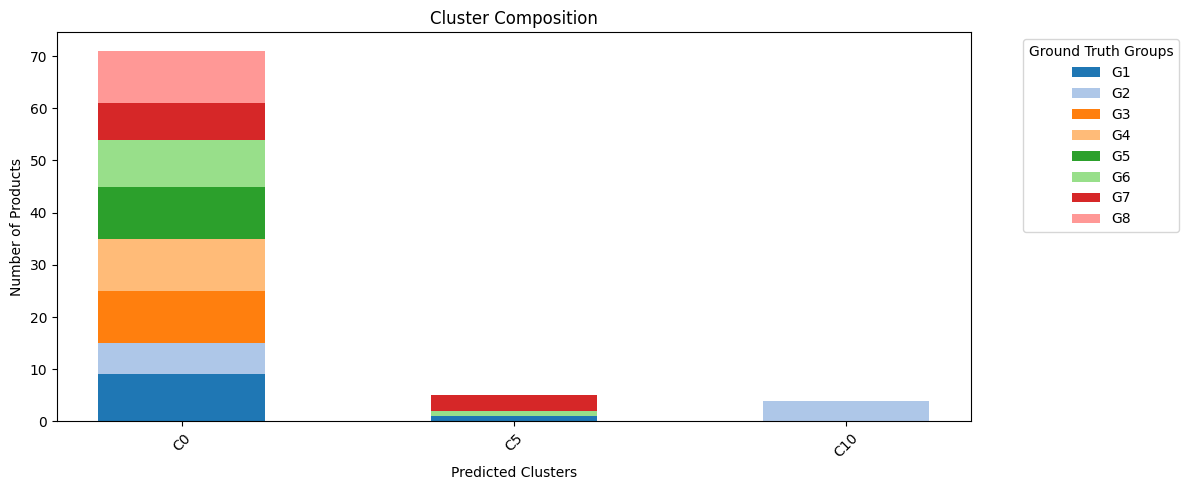


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.3474, NMI: 0.6584

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P10', 'G1_P2']
Cluster 2: ['G1_P3', 'G3_P10', 'G6_P4']
Cluster 3: ['G4_P5', 'G4_P6', 'G1_P4', 'G4_P9', 'G2_P1', 'G8_P9']
Cluster 4: ['G1_P5', 'G7_P3', 'G1_P8']
Cluster 5: ['G6_P7', 'G1_P6']
Cluster 6: ['G2_P3', 'G2_P4', 'G1_P7']
Cluster 8: ['G1_P9', 'G2_P9', 'G4_P1']
Cluster 11: ['G2_P7', 'G2_P10', 'G2_P2', 'G2_P5', 'G2_P6']
Cluster 17: ['G7_P5', 'G2_P8', 'G7_P7', 'G7_P9', 'G6_P10', 'G7_P4']
Cluster 20: ['G3_P1', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9']
Cluster 21: ['G7_P6', 'G7_P8', 'G3_P2', 'G7_P10', 'G7_P2']
Cluster 22: ['G3_P3']
Cluster 31: ['G4_P3', 'G4_P4', 'G4_P7', 'G4_P8', 'G4_P10', 'G4_P2']
Cluster 40: ['G5_P10', 'G5_P1', 'G5_P4', 'G5_P6', 'G5_P7']
Cluster 41: ['G5_P2', 'G5_P3', 'G5_P5', 'G5_P8']
Cluster 48: ['G5_P9', 'G6_P8', 'G6_P5']
Cluster 50: ['G6_P1', 'G6_P3', 'G6_P6']
Cluster 51: ['G6_P2', 'G8_P2', 'G8_P5', 'G8_P8', '

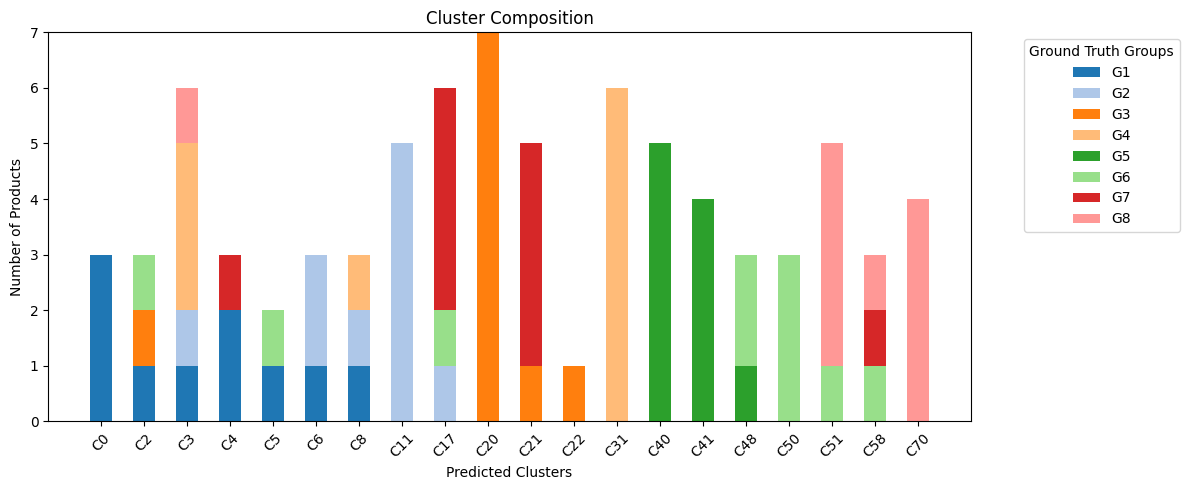


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4720, NMI: 0.7369

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P5', 'G1_P7', 'G1_P10']
Cluster 2: ['G1_P3', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P8', 'G3_P10']
Cluster 3: ['G7_P6', 'G7_P8', 'G1_P4', 'G7_P10']
Cluster 5: ['G6_P7', 'G1_P6']
Cluster 7: ['G8_P9', 'G1_P8']
Cluster 8: ['G1_P9', 'G5_P1', 'G3_P7', 'G4_P1']
Cluster 10: ['G2_P1', 'G2_P9']
Cluster 11: ['G2_P7', 'G2_P10', 'G2_P2', 'G2_P5', 'G2_P6']
Cluster 12: ['G2_P8', 'G2_P3', 'G2_P4']
Cluster 20: ['G3_P6', 'G3_P1', 'G3_P9']
Cluster 24: ['G6_P3', 'G6_P4', 'G6_P6', 'G3_P5', 'G6_P8', 'G6_P9', 'G6_P10']
Cluster 31: ['G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P2']
Cluster 41: ['G5_P2', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7']
Cluster 42: ['G5_P9', 'G5_P10', 'G6_P5', 'G5_P3', 'G5_P8']
Cluster 50: ['G6_P1', 'G6_P2', 'G8_P2', 'G8_P6', 'G8_P8', 'G8_P10']
Cluster 60: ['G7_P5', 'G7_P7', 'G7_P1', 'G7_P2', 'G7_P4']
Cluster 62: ['G7

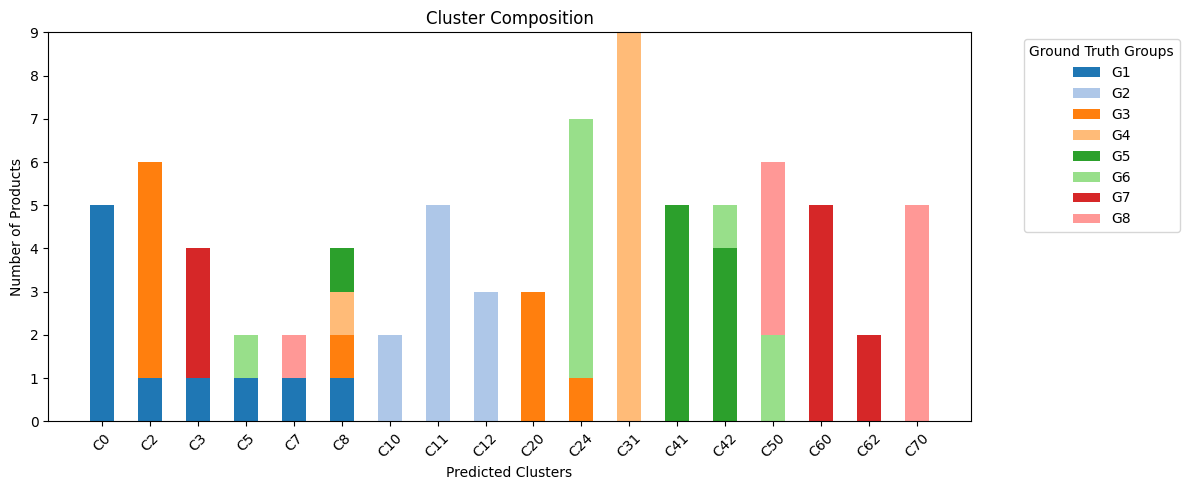


Iteration 9/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1328, NMI: 0.6561

Final Clustering Results:
Cluster 0: ['G1_P1', 'G6_P9']
Cluster 1: ['G1_P9', 'G1_P2']
Cluster 2: ['G1_P3', 'G1_P7']
Cluster 3: ['G1_P4', 'G1_P8']
Cluster 4: ['G2_P1', 'G1_P5', 'G1_P6']
Cluster 9: ['G1_P10', 'G8_P9']
Cluster 11: ['G2_P2', 'G2_P4']
Cluster 12: ['G2_P8', 'G2_P3']
Cluster 14: ['G2_P9', 'G2_P5']
Cluster 15: ['G3_P5', 'G2_P6']
Cluster 16: ['G2_P7', 'G4_P6']
Cluster 19: ['G7_P5', 'G2_P10']
Cluster 20: ['G3_P1', 'G3_P9']
Cluster 21: ['G7_P6', 'G3_P2']
Cluster 22: ['G3_P7', 'G3_P3']
Cluster 23: ['G3_P10', 'G3_P4']
Cluster 25: ['G3_P6', 'G6_P4']
Cluster 27: ['G3_P8', 'G6_P6']
Cluster 30: ['G4_P9', 'G4_P1']
Cluster 31: ['G4_P4', 'G4_P5', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P8']
Cluster 36: ['G4_P7', 'G4_P10']
Cluster 40: ['G5_P1', 'G5_P6']
Cluster 41: ['G5_P2', 'G5_P4']
Cluster 42: ['G5_P3', 'G5_P7']
Cluster 44: ['G5_P5', 'G5_P8']
Cluster 48: ['G5_P9', 'G5_P10']
Cluster 50: [

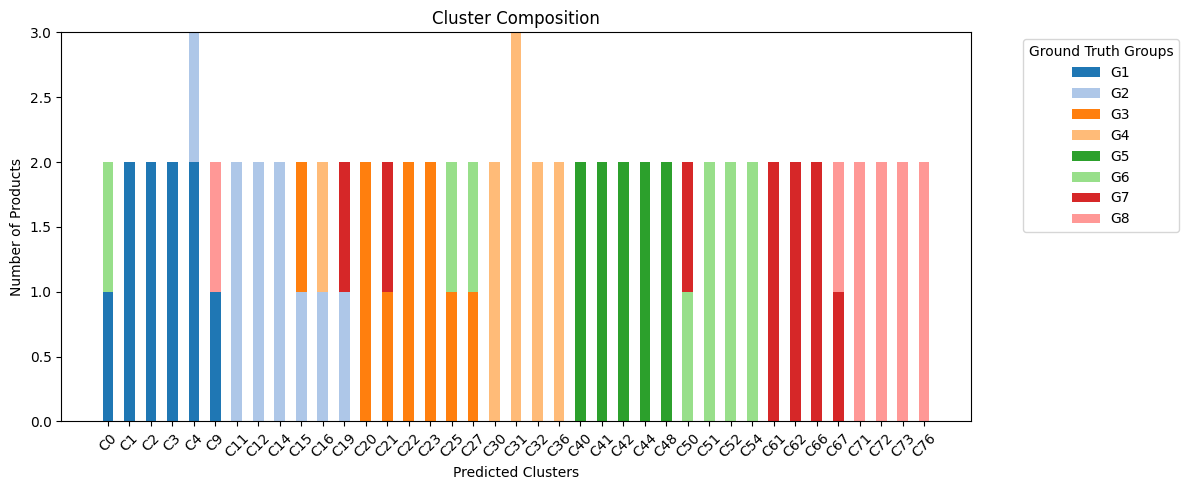


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0114, NMI: 0.1059

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P9', 'G1_P10', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G4_P1', 'G4_P3', 'G4_P4', 'G4_P6', 'G4_P7', 'G4_P9', 'G4_P10', 'G5_P1', 'G5_P3', 'G5_P5', 'G5_P7', 'G5_P8', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P10']
Cluster 7: ['G4_P8', 'G1_P8', 'G5_P2', 'G5_P4', 'G5_P6', 'G8_P9', 'G5_P9', 'G5_P10', 'G7_P3', 'G4_P2']
Cluster 34: ['G4_P5']


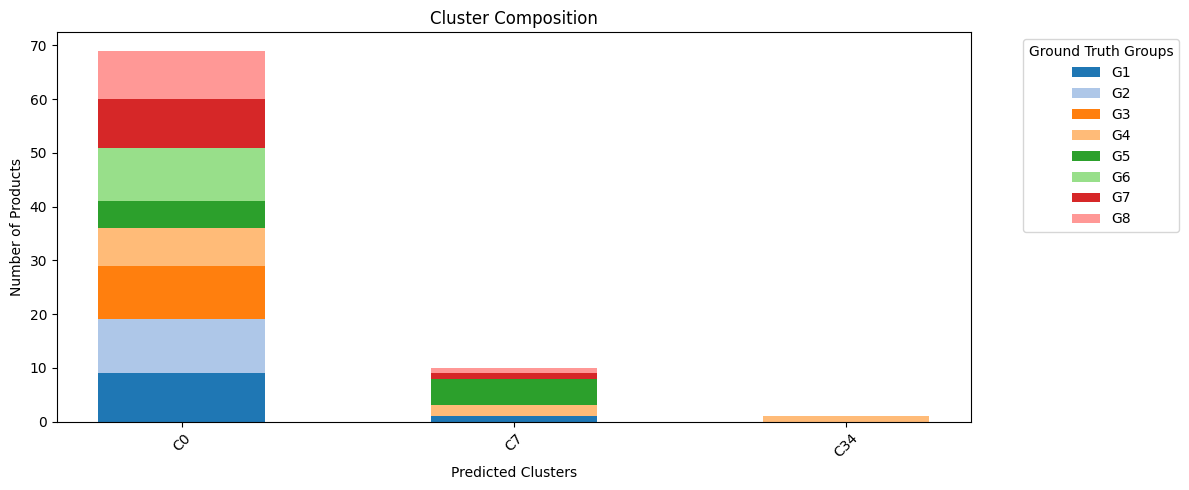


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.2215, NMI: 0.5616

Final Clustering Results:
Cluster 0: ['G1_P1', 'G2_P7', 'G4_P6', 'G1_P4', 'G3_P5', 'G1_P9']
Cluster 1: ['G1_P2', 'G3_P7', 'G7_P2', 'G4_P2']
Cluster 2: ['G6_P5', 'G1_P3', 'G6_P1', 'G7_P1']
Cluster 4: ['G1_P5']
Cluster 5: ['G3_P1', 'G1_P6', 'G4_P9', 'G8_P2']
Cluster 6: ['G6_P9', 'G1_P7', 'G2_P6']
Cluster 7: ['G7_P8', 'G1_P8', 'G1_P10', 'G5_P5', 'G7_P4']
Cluster 10: ['G8_P3', 'G2_P1', 'G8_P10']
Cluster 11: ['G2_P8', 'G2_P9', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 19: ['G7_P6', 'G2_P10', 'G7_P9', 'G3_P10']
Cluster 21: ['G3_P2', 'G8_P9', 'G3_P4']
Cluster 22: ['G5_P7', 'G5_P3', 'G3_P3']
Cluster 25: ['G3_P6', 'G3_P8', 'G8_P7']
Cluster 28: ['G8_P1', 'G8_P4', 'G8_P5', 'G8_P6', 'G3_P9', 'G8_P8']
Cluster 30: ['G4_P3', 'G4_P5', 'G4_P8', 'G4_P1']
Cluster 33: ['G4_P4', 'G7_P10']
Cluster 36: ['G5_P2', 'G4_P7', 'G6_P6', 'G4_P10']
Cluster 40: ['G5_P9', 'G5_P10', 'G5_P1', 'G5_P6', 'G5_P8']
Cluster 43: ['G6_P7

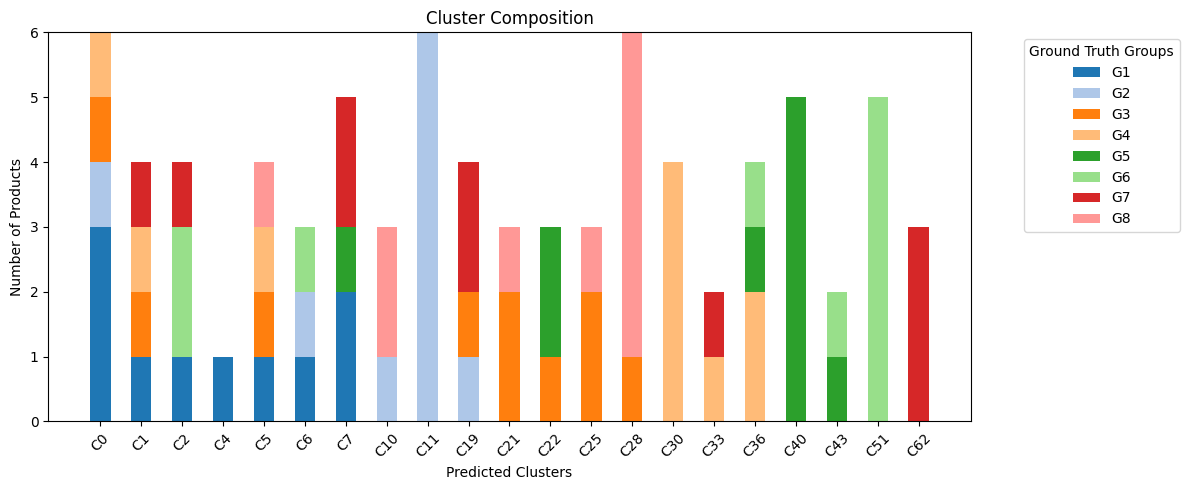


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.2964, NMI: 0.6250

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P6', 'G8_P1', 'G8_P2', 'G8_P10']
Cluster 1: ['G1_P2', 'G5_P3', 'G3_P7', 'G8_P7', 'G7_P2', 'G5_P7']
Cluster 2: ['G1_P3', 'G3_P10', 'G3_P4']
Cluster 3: ['G1_P9', 'G1_P4', 'G1_P8']
Cluster 4: ['G6_P1', 'G1_P5', 'G3_P6', 'G7_P1', 'G3_P9']
Cluster 6: ['G1_P10', 'G1_P7']
Cluster 10: ['G2_P1', 'G2_P2', 'G2_P4', 'G2_P6']
Cluster 12: ['G2_P8', 'G2_P9', 'G2_P10', 'G2_P3', 'G2_P5']
Cluster 16: ['G2_P7', 'G4_P6']
Cluster 20: ['G3_P5', 'G3_P8', 'G8_P6', 'G3_P1']
Cluster 21: ['G8_P3', 'G8_P4', 'G8_P5', 'G3_P2']
Cluster 22: ['G7_P5', 'G7_P6', 'G7_P7', 'G7_P9', 'G3_P3']
Cluster 30: ['G4_P3', 'G4_P4', 'G4_P5', 'G4_P7', 'G7_P10', 'G4_P10', 'G4_P1', 'G4_P2']
Cluster 37: ['G6_P7', 'G6_P3', 'G4_P8']
Cluster 38: ['G8_P8', 'G4_P9']
Cluster 40: ['G5_P1', 'G5_P10', 'G5_P9', 'G5_P6']
Cluster 41: ['G5_P2', 'G7_P8', 'G7_P4']
Cluster 43: ['G5_P4', 'G5_P5', 'G5_P8']
Cluster 5

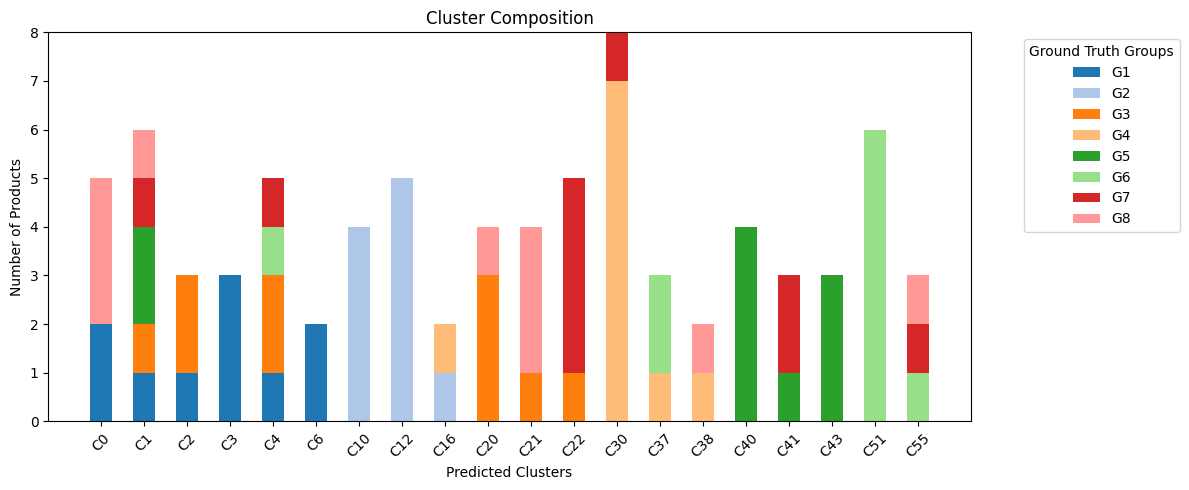


Iteration 10/10

Running Algorithm cluster_metric_1
Algorithm cluster_metric_1 - ARI: 0.1046, NMI: 0.6309

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P5']
Cluster 1: ['G1_P2', 'G1_P10']
Cluster 2: ['G1_P3', 'G1_P8']
Cluster 3: ['G6_P1', 'G1_P4']
Cluster 5: ['G5_P6', 'G1_P6']
Cluster 6: ['G7_P8', 'G1_P7']
Cluster 8: ['G1_P9', 'G7_P10']
Cluster 10: ['G2_P1', 'G2_P6']
Cluster 11: ['G2_P8', 'G2_P2']
Cluster 12: ['G2_P10', 'G2_P3']
Cluster 13: ['G2_P7', 'G2_P4']
Cluster 14: ['G2_P9', 'G2_P5']
Cluster 20: ['G5_P4', 'G3_P1']
Cluster 21: ['G3_P2', 'G7_P4']
Cluster 22: ['G3_P8', 'G3_P3']
Cluster 23: ['G3_P5', 'G3_P4']
Cluster 25: ['G3_P6', 'G8_P2']
Cluster 26: ['G3_P7', 'G8_P10']
Cluster 28: ['G3_P9', 'G3_P10']
Cluster 30: ['G4_P5', 'G4_P1']
Cluster 31: ['G4_P10', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P8']
Cluster 33: ['G4_P4', 'G4_P9']
Cluster 35: ['G4_P6', 'G4_P7']
Cluster 40: ['G5_P1', 'G6_P4']
Cluster 41: ['G5_P2', 'G6_P10']
Cluster 42: ['G5_P3', 'G7_P1']
Cluster 44: ['G5_P10', 'G5_P5

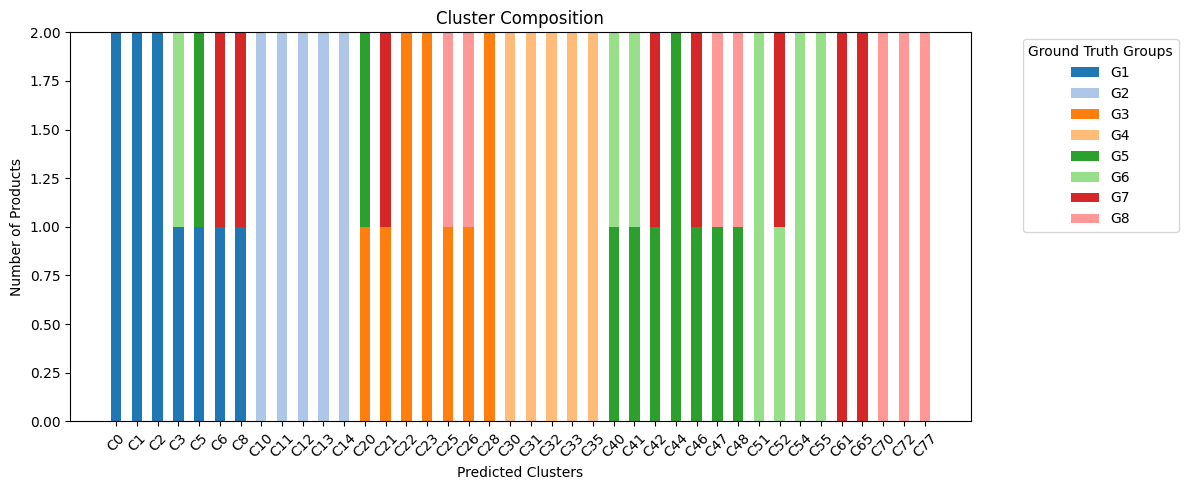


Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.0136, NMI: 0.1492

Final Clustering Results:
Cluster 0: ['G1_P1', 'G4_P1']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G3_P2', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G5_P10', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7', 'G8_P8', 'G8_P9', 'G8_P10']
Cluster 20: ['G3_P1', 'G3_P3', 'G3_P8', 'G3_P9', 'G3_P10']


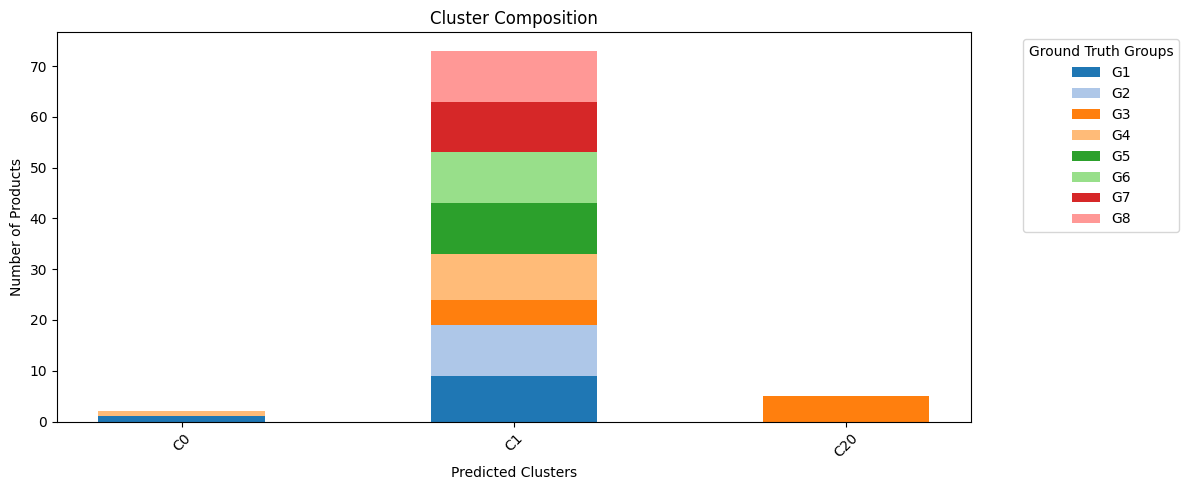


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.2609, NMI: 0.6124

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P9', 'G7_P10']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P8', 'G1_P10']
Cluster 5: ['G1_P6']
Cluster 6: ['G7_P3', 'G7_P8', 'G1_P7']
Cluster 10: ['G2_P1', 'G6_P3', 'G3_P2', 'G7_P4']
Cluster 11: ['G7_P7', 'G7_P9', 'G4_P8', 'G2_P2', 'G7_P2']
Cluster 12: ['G3_P8', 'G2_P3', 'G2_P6']
Cluster 13: ['G2_P7', 'G2_P8', 'G2_P9', 'G2_P10', 'G6_P5', 'G2_P4', 'G2_P5']
Cluster 20: ['G3_P5', 'G3_P1', 'G8_P7']
Cluster 22: ['G5_P1', 'G5_P4', 'G3_P3', 'G8_P10']
Cluster 23: ['G3_P6', 'G3_P10', 'G3_P4']
Cluster 26: ['G5_P9', 'G3_P7', 'G5_P5']
Cluster 28: ['G3_P9']
Cluster 30: ['G5_P10', 'G4_P5', 'G4_P1']
Cluster 31: ['G4_P6', 'G4_P7', 'G4_P10', 'G4_P2']
Cluster 32: ['G4_P3', 'G4_P4', 'G4_P9']
Cluster 41: ['G5_P2', 'G6_P1', 'G6_P10', 'G5_P8']
Cluster 42: ['G7_P6', 'G5_P3', 'G6_P6']
Cluster 45: ['G7_P5', 'G7_P1', 'G5_P6']
Cluster 46: ['G6_P2', 'G6_P4', 'G6_P7'

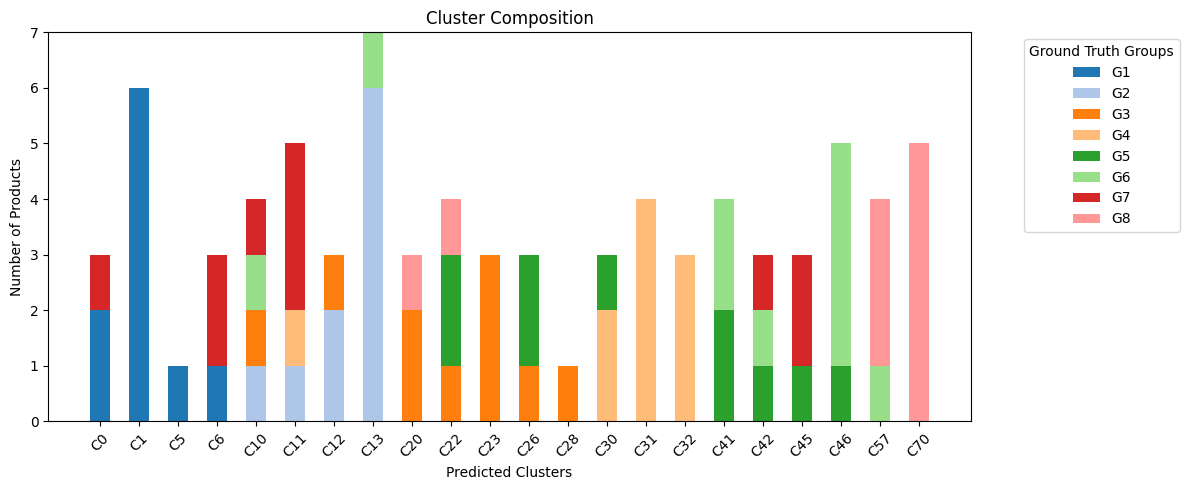


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.2575, NMI: 0.5993

Final Clustering Results:
Cluster 0: ['G1_P1', 'G7_P10', 'G8_P2', 'G1_P9', 'G5_P2']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G5_P10', 'G1_P8', 'G1_P10', 'G8_P7']
Cluster 5: ['G4_P5', 'G1_P6', 'G4_P1']
Cluster 6: ['G7_P5', 'G7_P8', 'G1_P7']
Cluster 10: ['G2_P7', 'G2_P9', 'G2_P10', 'G2_P1', 'G2_P3', 'G2_P4', 'G2_P6']
Cluster 11: ['G2_P8', 'G2_P2']
Cluster 14: ['G3_P5', 'G3_P10', 'G2_P5', 'G3_P4']
Cluster 20: ['G5_P3', 'G3_P1']
Cluster 21: ['G4_P4', 'G6_P3', 'G3_P2', 'G7_P4']
Cluster 22: ['G3_P8', 'G3_P3']
Cluster 25: ['G3_P6', 'G6_P6']
Cluster 26: ['G3_P7', 'G5_P5']
Cluster 28: ['G5_P1', 'G5_P4', 'G3_P9']
Cluster 31: ['G4_P3', 'G4_P10', 'G4_P9', 'G4_P2']
Cluster 35: ['G8_P5', 'G4_P6', 'G4_P7', 'G8_P1']
Cluster 37: ['G8_P4', 'G8_P8', 'G4_P8', 'G8_P9']
Cluster 45: ['G7_P6', 'G7_P1', 'G5_P6', 'G5_P8']
Cluster 46: ['G6_P2', 'G6_P7', 'G7_P3', 'G6_P9', 'G6_P10', 'G5_P7']
Cluster 48: ['G5_P9', 'G7

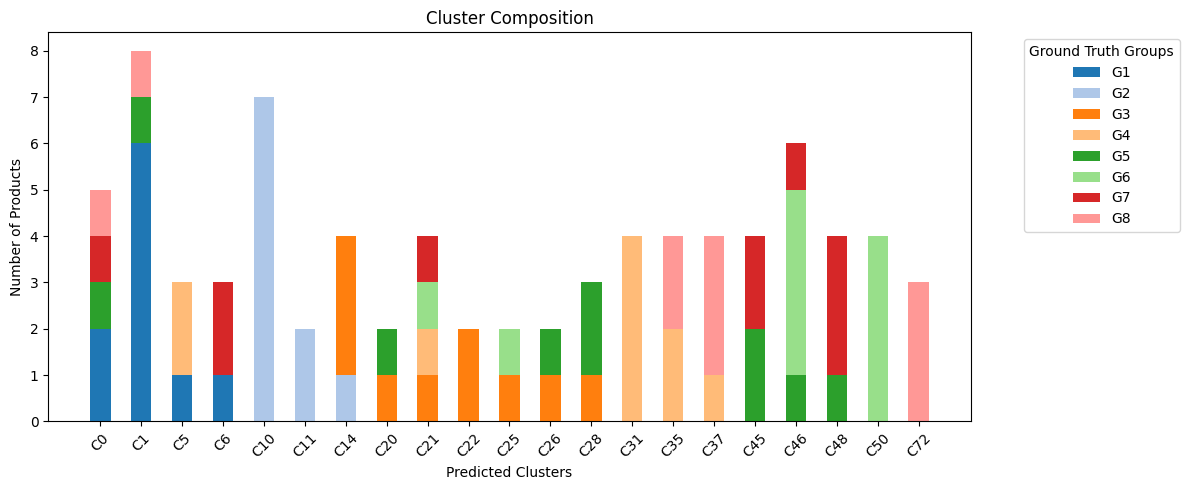


ARI and NMI results have been saved to '/content/drive/My Drive/clustering_results_no_base_compare1234_2.xlsx'.


In [ ]:


# Set random seed for reproducibilit

np.random.seed(42)

# Parameters
num_groups = 8
products_per_group = 10
total_products = num_groups * products_per_group
iterations = 10  # Set to 1 for demonstration




sigma_e = 2

eta = 1

##############

def generate_data():
    # Generate product IDs and assign to groups
    product_ids = []
    group_ids = []
    product_to_group = {}
    for group in range(1, num_groups + 1):
        for prod in range(1, products_per_group + 1):
            product_id = f'G{group}_P{prod}'
            product_ids.append(product_id)
            group_ids.append(group)
            product_to_group[product_id] = group

    # Map product IDs to indices
    product_id_to_index = {pid: idx for idx, pid in enumerate(product_ids)}
    index_to_product_id = {idx: pid for idx, pid in enumerate(product_ids)}

    # Initialize gamma_matrix
    gamma_matrix = np.zeros((total_products, total_products))

    # Generate gamma_matrix for products within the same group
    r_values = np.zeros(total_products)
    l_values = np.zeros(total_products)

    for group in range(1, num_groups + 1):
        group_product_ids = [pid for pid in product_ids if product_to_group[pid] == group]
        group_indices = [product_id_to_index[pid] for pid in group_product_ids]
        n_k = len(group_indices)

        # # Draw s from N(mu_s, sigma_s) for this group
        # s = np.random.normal(mu_s, sigma_s)
        mu_r = np.random.normal(1, 0.2)
        mu_l = np.random.normal(1, 0.2)
        sigma_r = 0.2
        sigma_l = 0.2
        # Draw r_i and l_i for each product i in the group
        #mu_r = np.random.normal(theta_r, tau_r)
        #mu_l = np.random.normal(theta_l, tau_l)
        # Draw lambda_i and omega_i for each product i in the group
        r = np.random.normal(mu_r, sigma_r, size=n_k) #1
        l = np.random.normal(mu_l, sigma_l, size=n_k) #1

        # Store r_i and l_i
        for idx, idx_i in enumerate(group_indices):
            r_values[idx_i] = r[idx]
            l_values[idx_i] = l[idx]

        # For each pair (i, j) in the group
        for idx_i in group_indices:
            for idx_j in group_indices:
                if idx_i != idx_j:
                    # Draw e_{i,j} ~ N(0, sigma_e)
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] =  r_values[idx_i] + l_values[idx_j]+ e_ij

    # Generate gamma_matrix for products from different groups
    all_indices = list(range(total_products))
    for idx_i in all_indices:
        group_i = product_to_group[index_to_product_id[idx_i]]
        for idx_j in all_indices:
            if idx_i != idx_j:
                group_j = product_to_group[index_to_product_id[idx_j]]
                if group_i != group_j:
                    # Draw e_{i,j} from N(0,1)
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] = e_ij

    # Create true labels for perfect clustering (grouped by 'Gx')
    true_labels = np.array([product_to_group[pid] for pid in product_ids])

    return product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels






####################### Main Loop ##############################################

algorithms = [
             # cluster_metric_max_linkage

              cluster_metric_1,
              cluster_metric_2,
                 cluster_metric_3,
              cluster_metric_4

           #    cluster_metric_4,
           #   cluster_metric_7,
            #   cluster_metric_7_smaller_denom
           #   cluster_metric_8
              ]

# For storing ARI and NMI results for each algorithm
ari_results = {f'Algorithm_{i.__name__}': [] for i in algorithms}
nmi_results = {f'Algorithm_{i.__name__}': [] for i in algorithms}

for iter_num in range(iterations):
    print(f"\nIteration {iter_num+1}/{iterations}")

    # Generate data
    product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels = generate_data()

    # Set beta_hat equal to gamma_matrix
    beta_hat = gamma_matrix.copy()

    for cluster_metric_func in algorithms:
        print(f"\nRunning Algorithm {cluster_metric_func.__name__}")
        clusters = agglomerative_clustering(beta_hat, cluster_metric_func, index_to_product_id)

        # Map indices back to product IDs and output clusters
        predicted_labels = np.empty(len(product_ids), dtype=int)
        for k, cluster in clusters.items():
            for idx in cluster:
                predicted_labels[idx] = k

        # Compute ARI and NMI between perfect clustering and current clustering
        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        ari_results[f'Algorithm_{cluster_metric_func.__name__}'].append(ari)
        nmi_results[f'Algorithm_{cluster_metric_func.__name__}'].append(nmi)

        # Print clustering performance
        print(f"Algorithm {cluster_metric_func.__name__} - ARI: {ari:.4f}, NMI: {nmi:.4f}")

        # **Output Final Clustering Results**
        print("\nFinal Clustering Results:")
        for cluster_id, product_indices in clusters.items():
            product_list = [index_to_product_id[idx] for idx in product_indices]
            print(f"Cluster {cluster_id}: {product_list}")

        ## plot
        cluster_ids = sorted(clusters.keys())
        ground_truth_groups = sorted(set(true_labels))

        # Initialize a matrix to hold counts
        counts_matrix = np.zeros((len(cluster_ids), len(ground_truth_groups)))

        # Map ground truth group IDs to colors
        cmap = plt.get_cmap('tab20')  # You can choose any colormap you prefer
        colors = cmap.colors[:len(ground_truth_groups)]
        group_colors = {gt_group: colors[i] for i, gt_group in enumerate(ground_truth_groups)}

        # For legend labels
        group_labels = [f"G{gt_group}" for gt_group in ground_truth_groups]

        # Build counts matrix
        for i, cluster_id in enumerate(cluster_ids):
            product_indices = clusters[cluster_id]
            gt_labels_in_cluster = true_labels[list(product_indices)]
            for gt_group in ground_truth_groups:
                counts = np.sum(gt_labels_in_cluster == gt_group)
                counts_matrix[i, gt_group - 1] = counts  # Adjust index if ground truth groups start from 1

        # 2. Create the stacked bar chart using counts
        fig, ax = plt.subplots(figsize=(12, 5))

        bar_width = 0.5
        bar_positions = np.arange(len(cluster_ids))

        # Initialize the bottom of the bar (for stacking)
        bottom = np.zeros(len(cluster_ids))

        for i, gt_group in enumerate(ground_truth_groups):
            counts = counts_matrix[:, i]
            ax.bar(bar_positions, counts, bar_width, bottom=bottom, color=group_colors[gt_group], label=f"G{gt_group}")
            bottom += counts  # Update the bottom for the next segment

        # 3. Add labels and legend
        ax.set_xlabel('Predicted Clusters')
        ax.set_ylabel('Number of Products')
        ax.set_title(f'Cluster Composition')
        ax.set_xticks(bar_positions)
        ax.set_xticklabels([f'C{cluster_id}' for cluster_id in cluster_ids], rotation=45)
        ax.legend(title='Ground Truth Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

# Create DataFrames from the results dictionaries
ari_df = pd.DataFrame(ari_results)
nmi_df = pd.DataFrame(nmi_results)

# Add iteration numbers as a column
ari_df.insert(0, 'Iteration', range(1, iterations + 1))
nmi_df.insert(0, 'Iteration', range(1, iterations + 1))

# Save to Excel file
excel_filename = f"/content/drive/My Drive/clustering_results_no_base_compare1234_{sigma_e}.xlsx"

with pd.ExcelWriter(excel_filename) as writer:
    ari_df.to_excel(writer, sheet_name='ARI', index=False)
    nmi_df.to_excel(writer, sheet_name='NMI', index=False)

print(f"\nARI and NMI results have been saved to '{excel_filename}'.")


# Algorithm 3,4, with differeent eta

In [ ]:



np.random.seed(42)


# Parameters
num_groups = 8
products_per_group = 10
total_products = num_groups * products_per_group
iterations = 10




sigma_e = 1.5 # 1 and 2
#ll_denom = 1  # Will be set in the inner loop


def generate_data():
    # Generate product IDs and assign to groups
    product_ids = []
    group_ids = []
    product_to_group = {}
    for group in range(1, num_groups + 1):
        for prod in range(1, products_per_group + 1):
            product_id = f'G{group}_P{prod}'
            product_ids.append(product_id)
            group_ids.append(group)
            product_to_group[product_id] = group


    # Map product IDs to indices
    product_id_to_index = {pid: idx for idx, pid in enumerate(product_ids)}
    index_to_product_id = {idx: pid for idx, pid in enumerate(product_ids)}


    # Initialize gamma_matrix
    gamma_matrix = np.zeros((total_products, total_products))


    # Generate gamma_matrix for products within the same group
    r_values = np.zeros(total_products)
    l_values = np.zeros(total_products)


    for group in range(1, num_groups + 1):
        group_product_ids = [pid for pid in product_ids if product_to_group[pid] == group]
        group_indices = [product_id_to_index[pid] for pid in group_product_ids]
        n_k = len(group_indices)


        # # Draw s from N(mu_s, sigma_s) for this group
        # s = np.random.normal(mu_s, sigma_s)
        mu_r = np.random.normal(1, 0.2)
        mu_l = np.random.normal(1, 0.2)
        sigma_r = 0.2
        sigma_l = 0.2
        # Draw r_i and l_i for each product i in the group
        #mu_r = np.random.normal(theta_r, tau_r)
        #mu_l = np.random.normal(theta_l, tau_l)
        # Draw lambda_i and omega_i for each product i in the group
        r = np.random.normal(mu_r, sigma_r, size=n_k) #1
        l = np.random.normal(mu_l, sigma_l, size=n_k) #1


        # Store r_i and l_i
        for idx, idx_i in enumerate(group_indices):
            r_values[idx_i] = r[idx]
            l_values[idx_i] = l[idx]


        # For each pair (i, j) in the group
        for idx_i in group_indices:
            for idx_j in group_indices:
                if idx_i != idx_j:
                    # Draw e_{i,j} ~ N(0, sigma_e)
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] =  r_values[idx_i] + l_values[idx_j]+ e_ij


    # Generate gamma_matrix for products from different groups
    all_indices = list(range(total_products))
    for idx_i in all_indices:
        group_i = product_to_group[index_to_product_id[idx_i]]
        for idx_j in all_indices:
            if idx_i != idx_j:
                group_j = product_to_group[index_to_product_id[idx_j]]
                if group_i != group_j:
                    # Draw e_{i,j} from N(0,1)
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] = e_ij


    # Create true labels for perfect clustering (grouped by 'Gx')
    true_labels = np.array([product_to_group[pid] for pid in product_ids])


    return product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels





# === Main loop: Outer = iteration, Inner = eta ===


eta_values = [1,5,9,13,17, 21,25]
ari_results = {f'eta_{sd:.2f}': [] for sd in eta_values}
nmi_results = {f'eta_{sd:.2f}': [] for sd in eta_values}


func = cluster_metric_4


for iter_num in range(iterations):
    print(f"\n========== Iteration {iter_num + 1}/{iterations} ==========")


    # Generate dataset
    product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels = generate_data()
    beta_hat = gamma_matrix.copy()


    for sd in eta_values:
        print(f"  Running with eta = {sd:.2f}")
        eta = sd  # Update global variable


        clusters = agglomerative_clustering(beta_hat, func, index_to_product_id)


        predicted_labels = np.empty(len(product_ids), dtype=int)
        for k, cluster in clusters.items():
            for idx in cluster:
                predicted_labels[idx] = k


        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)


        ari_results[f'eta_{sd:.2f}'].append(ari)
        nmi_results[f'eta_{sd:.2f}'].append(nmi)


        print(f"    ARI: {ari:.4f}, NMI: {nmi:.4f}")


# === Export results ===


ari_df = pd.DataFrame(ari_results)
nmi_df = pd.DataFrame(nmi_results)
ari_df.insert(0, 'Iteration', range(1, iterations + 1))
nmi_df.insert(0, 'Iteration', range(1, iterations + 1))


excel_filename = f"/content/drive/My Drive/clustering_results_{func.__name__}_denom_variation_by_iteration.xlsx"
with pd.ExcelWriter(excel_filename) as writer:
    ari_df.to_excel(writer, sheet_name='ARI', index=False)
    nmi_df.to_excel(writer, sheet_name='NMI', index=False)


print(f"\nResults saved to '{excel_filename}'")






========== Iteration 1/10 ==========
  Running with small_denom = 1.00
    ARI: 0.8869, NMI: 0.9364
  Running with small_denom = 5.00
    ARI: 0.8569, NMI: 0.9035
  Running with small_denom = 9.00
    ARI: 0.8137, NMI: 0.8745
  Running with small_denom = 13.00
    ARI: 0.6738, NMI: 0.7996
  Running with small_denom = 17.00
    ARI: 0.6048, NMI: 0.7461
  Running with small_denom = 21.00
    ARI: 0.4874, NMI: 0.6525
  Running with small_denom = 25.00
    ARI: 0.4954, NMI: 0.6698

========== Iteration 2/10 ==========
  Running with small_denom = 1.00
    ARI: 0.8492, NMI: 0.9097
  Running with small_denom = 5.00
    ARI: 0.9703, NMI: 0.9802
  Running with small_denom = 9.00
    ARI: 0.9421, NMI: 0.9606
  Running with small_denom = 13.00
    ARI: 0.9391, NMI: 0.9600
  Running with small_denom = 17.00
    ARI: 0.7685, NMI: 0.8701
  Running with small_denom = 21.00
    ARI: 0.6388, NMI: 0.7992
  Running with small_denom = 25.00
    ARI: 0.5692, NMI: 0.7547

========== Iteration 3/10 =======

# compare algorithm 1,2,3,4, but with t-distribution

In [ ]:


# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_groups = 8
products_per_group = 10
total_products = num_groups * products_per_group
iterations = 10
sigma_e = 0.5
eta = 1

def generate_data():
    df_t = 5  # degrees of freedom for t-distribution
    scale_r = 0.2
    scale_l = 0.2
    scale_mu = 0.2
    scale_e = sigma_e

    # Generate product IDs and assign to groups
    product_ids = []
    group_ids = []
    product_to_group = {}
    for group in range(1, num_groups + 1):
        for prod in range(1, products_per_group + 1):
            product_id = f'G{group}_P{prod}'
            product_ids.append(product_id)
            group_ids.append(group)
            product_to_group[product_id] = group

    product_id_to_index = {pid: idx for idx, pid in enumerate(product_ids)}
    index_to_product_id = {idx: pid for idx, pid in enumerate(product_ids)}
    gamma_matrix = np.zeros((total_products, total_products))

    r_values = np.zeros(total_products)
    l_values = np.zeros(total_products)

    for group in range(1, num_groups + 1):
        group_product_ids = [pid for pid in product_ids if product_to_group[pid] == group]
        group_indices = [product_id_to_index[pid] for pid in group_product_ids]
        n_k = len(group_indices)

        mu_r = 1 + scale_mu * np.random.standard_t(df_t)
        mu_l = 1 + scale_mu * np.random.standard_t(df_t)
        r = mu_r + scale_r * np.random.standard_t(df_t, size=n_k)
        l = mu_l + scale_l * np.random.standard_t(df_t, size=n_k)

        for idx, idx_i in enumerate(group_indices):
            r_values[idx_i] = r[idx]
            l_values[idx_i] = l[idx]

        for idx_i in group_indices:
            for idx_j in group_indices:
                if idx_i != idx_j:
                    e_ij = scale_e * np.random.standard_t(df_t)
                    gamma_matrix[idx_i, idx_j] = r_values[idx_i] + l_values[idx_j] + e_ij

    all_indices = list(range(total_products))
    for idx_i in all_indices:
        group_i = product_to_group[index_to_product_id[idx_i]]
        for idx_j in all_indices:
            if idx_i != idx_j:
                group_j = product_to_group[index_to_product_id[idx_j]]
                if group_i != group_j:
                    e_ij = scale_e * np.random.standard_t(df_t)
                    gamma_matrix[idx_i, idx_j] = e_ij

    true_labels = np.array([product_to_group[pid] for pid in product_ids])
    return product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels





###################### Evaluation Loop ######################

algorithms = [cluster_metric_1, cluster_metric_2, cluster_metric_3, cluster_metric_4]
ari_results = {f'Algorithm_{func.__name__}': [] for func in algorithms}
nmi_results = {f'Algorithm_{func.__name__}': [] for func in algorithms}

for iter_num in range(iterations):
    print(f"\nIteration {iter_num+1}/{iterations}")
    product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels = generate_data()
    beta_hat = gamma_matrix.copy()

    for metric_func in algorithms:
        print(f"\nRunning {metric_func.__name__}")
        clusters = agglomerative_clustering(beta_hat, metric_func, index_to_product_id)
        predicted_labels = np.empty(len(product_ids), dtype=int)
        for k, cluster in clusters.items():
            for idx in cluster:
                predicted_labels[idx] = k

        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        ari_results[f'Algorithm_{metric_func.__name__}'].append(ari)
        nmi_results[f'Algorithm_{metric_func.__name__}'].append(nmi)

        print(f"{metric_func.__name__} - ARI: {ari:.4f}, NMI: {nmi:.4f}")

# Save results
ari_df = pd.DataFrame(ari_results)
nmi_df = pd.DataFrame(nmi_results)
ari_df.insert(0, 'Iteration', range(1, iterations + 1))
nmi_df.insert(0, 'Iteration', range(1, iterations + 1))

filename = f"/content/drive/My Drive/clustering_results_tdist_sigma_{sigma_e}.xlsx"
with pd.ExcelWriter(filename) as writer:
    ari_df.to_excel(writer, sheet_name='ARI', index=False)
    nmi_df.to_excel(writer, sheet_name='NMI', index=False)

print(f"\nARI and NMI results have been saved to '{filename}'")



Iteration 1/10

Running cluster_metric_1
cluster_metric_1 - ARI: 0.2061, NMI: 0.7287

Running cluster_metric_2
cluster_metric_2 - ARI: 0.2082, NMI: 0.4827

Running cluster_metric_3
cluster_metric_3 - ARI: 0.8742, NMI: 0.9184

Running cluster_metric_4
cluster_metric_4 - ARI: 0.9703, NMI: 0.9802

Iteration 2/10

Running cluster_metric_1
cluster_metric_1 - ARI: 0.2142, NMI: 0.7298

Running cluster_metric_2
cluster_metric_2 - ARI: 0.0706, NMI: 0.3068

Running cluster_metric_3
cluster_metric_3 - ARI: 0.9696, NMI: 0.9767

Running cluster_metric_4
cluster_metric_4 - ARI: 0.9703, NMI: 0.9802

Iteration 3/10

Running cluster_metric_1
cluster_metric_1 - ARI: 0.2051, NMI: 0.7231

Running cluster_metric_2
cluster_metric_2 - ARI: 0.1459, NMI: 0.4257

Running cluster_metric_3
cluster_metric_3 - ARI: 0.9040, NMI: 0.9399

Running cluster_metric_4
cluster_metric_4 - ARI: 0.9128, NMI: 0.9447

Iteration 4/10

Running cluster_metric_1
cluster_metric_1 - ARI: 0.2382, NMI: 0.7376

Running cluster_metric_2




```
# This is formatted as code
```

# compare algorithm 2,3,4,5 , but the product number under each group is different


Iteration 1/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1498, NMI: 0.6769

Final Clustering Results:
Cluster 0: ['G1_P1', 'G3_P11']
Cluster 1: ['G1_P9', 'G1_P2']
Cluster 2: ['G1_P3', 'G1_P7']
Cluster 3: ['G1_P4', 'G1_P5']
Cluster 5: ['G1_P6', 'G1_P8']
Cluster 9: ['G1_P10', 'G1_P11']
Cluster 11: ['G2_P7', 'G2_P1']
Cluster 12: ['G2_P2', 'G2_P5']
Cluster 13: ['G4_P3', 'G2_P3']
Cluster 14: ['G2_P8', 'G2_P4']
Cluster 16: ['G2_P6', 'G6_P4']
Cluster 19: ['G3_P6', 'G3_P1']
Cluster 20: ['G3_P9', 'G3_P2']
Cluster 21: ['G3_P10', 'G3_P3']
Cluster 22: ['G7_P10', 'G3_P4']
Cluster 23: ['G3_P8', 'G3_P5']
Cluster 25: ['G3_P7', 'G4_P4']
Cluster 30: ['G3_P12']
Cluster 31: ['G3_P15', 'G3_P13']
Cluster 32: ['G3_P14', 'G6_P10']
Cluster 34: ['G4_P1', 'G4_P5']
Cluster 35: ['G4_P7', 'G4_P2']
Cluster 39: ['G4_P8', 'G4_P6']
Cluster 42: ['G4_P9', 'G4_P12']
Cluster 43: ['G4_P10', 'G4_P11']
Cluster 46: ['G5_P6', 'G5_P1']
Cluster 47: ['G5_P4', 'G5_P5', 'G5_P2']
Cluster 48: ['G5_P3', '

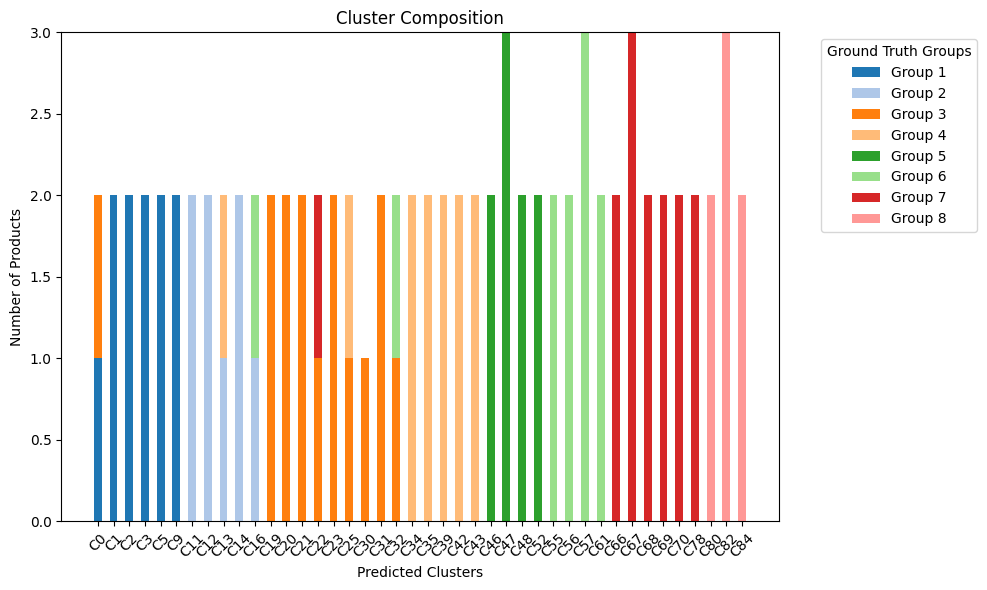


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0068, NMI: 0.0568

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P7']
Cluster 84: ['G8_P5', 'G8_P6']


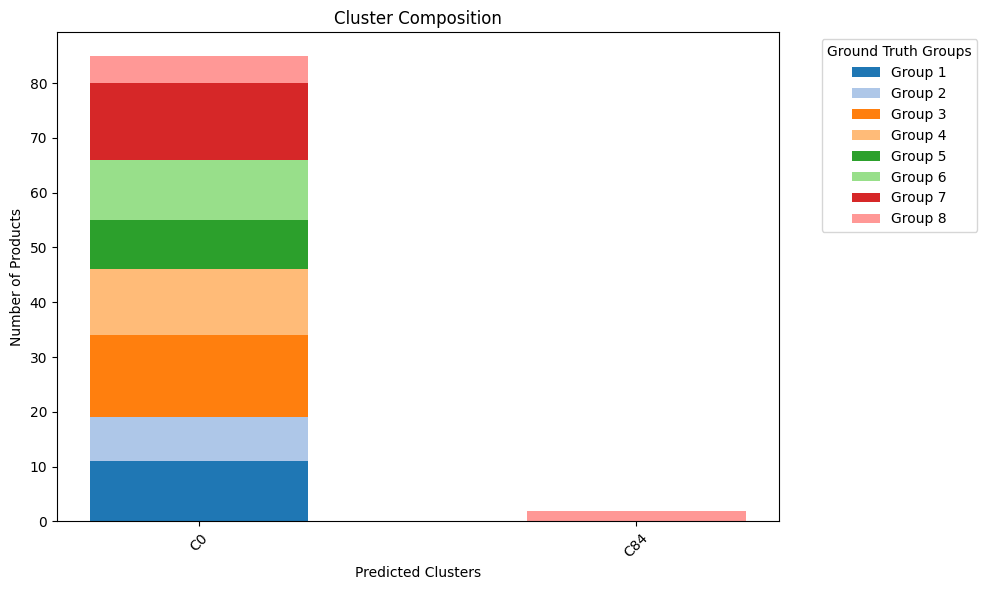


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4985, NMI: 0.7500

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P3', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P11']
Cluster 1: ['G1_P9', 'G1_P2', 'G1_P10']
Cluster 3: ['G1_P4', 'G1_P5']
Cluster 11: ['G2_P7', 'G2_P1', 'G2_P2', 'G2_P4', 'G2_P5']
Cluster 13: ['G4_P4', 'G4_P11', 'G2_P3', 'G5_P9']
Cluster 16: ['G2_P6', 'G8_P3', 'G8_P4']
Cluster 18: ['G2_P8']
Cluster 19: ['G3_P15', 'G3_P1', 'G3_P2', 'G3_P4', 'G3_P7', 'G3_P9']
Cluster 21: ['G3_P3', 'G7_P8', 'G3_P10', 'G3_P11', 'G3_P13']
Cluster 23: ['G3_P6', 'G3_P14', 'G3_P12', 'G3_P5']
Cluster 26: ['G6_P10', 'G3_P8', 'G7_P5']
Cluster 34: ['G4_P1', 'G4_P3', 'G4_P5']
Cluster 35: ['G4_P2', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P12']
Cluster 46: ['G5_P3', 'G5_P4', 'G5_P5', 'G5_P7', 'G5_P8', 'G5_P1', 'G5_P2']
Cluster 51: ['G6_P2', 'G5_P6', 'G6_P6', 'G6_P9']
Cluster 55: ['G6_P1', 'G6_P5', 'G6_P4', 'G7_P10', 'G6_P8']
Cluster 57: ['G6_P11', 'G6_P3', 'G6_P7', 'G8_P6']
Clu

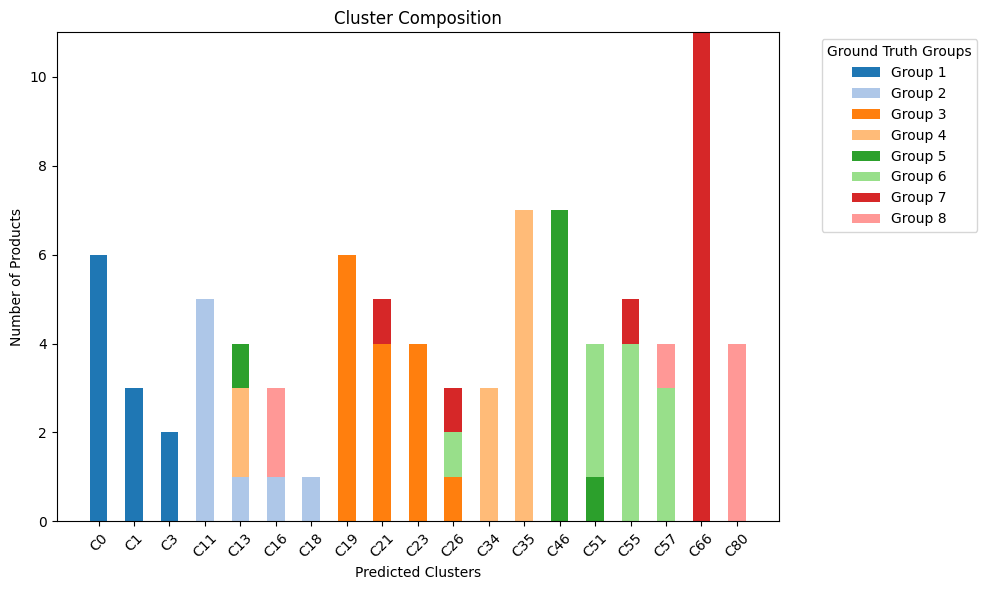


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.7306, NMI: 0.8488

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P10', 'G1_P11']
Cluster 1: ['G1_P9', 'G1_P2', 'G2_P1', 'G2_P7']
Cluster 12: ['G2_P8', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 16: ['G2_P6', 'G6_P4', 'G4_P4']
Cluster 19: ['G3_P14', 'G3_P1', 'G3_P3', 'G3_P5', 'G3_P6', 'G3_P8', 'G3_P10']
Cluster 20: ['G3_P15', 'G3_P2', 'G3_P4', 'G3_P7', 'G3_P9', 'G3_P11', 'G3_P13']
Cluster 30: ['G5_P9', 'G8_P2', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P6', 'G5_P7', 'G5_P1']
Cluster 47: ['G5_P3', 'G5_P4', 'G5_P5', 'G5_P8', 'G5_P2']
Cluster 55: ['G6_P10', 'G6_P11', 'G6_P1', 'G6_P5', 'G6_P7']
Cluster 56: ['G6_P2', 'G6_P3', 'G6_P6', 'G6_P8', 'G6_P9']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11',

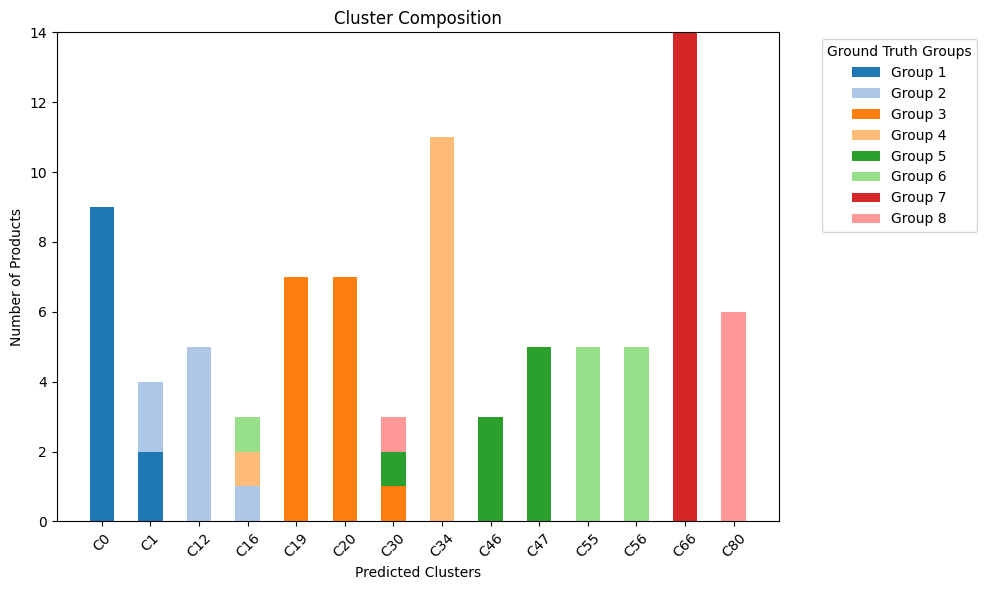


Iteration 2/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1620, NMI: 0.6932

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P7']
Cluster 1: ['G1_P2', 'G1_P6']
Cluster 2: ['G1_P9', 'G1_P3']
Cluster 3: ['G1_P4', 'G1_P8']
Cluster 4: ['G1_P5', 'G7_P13']
Cluster 9: ['G1_P10', 'G1_P11']
Cluster 11: ['G2_P6', 'G2_P1']
Cluster 12: ['G2_P8', 'G2_P2']
Cluster 13: ['G2_P7', 'G2_P3']
Cluster 14: ['G2_P4', 'G2_P5']
Cluster 19: ['G3_P1', 'G3_P5']
Cluster 20: ['G3_P2', 'G3_P4']
Cluster 21: ['G3_P7', 'G3_P3']
Cluster 24: ['G3_P6', 'G3_P8']
Cluster 27: ['G3_P9', 'G3_P13']
Cluster 28: ['G3_P15', 'G3_P10']
Cluster 29: ['G3_P14', 'G3_P11']
Cluster 30: ['G8_P5', 'G3_P12']
Cluster 34: ['G4_P7', 'G4_P1']
Cluster 35: ['G4_P2', 'G4_P4']
Cluster 36: ['G4_P9', 'G4_P3']
Cluster 38: ['G4_P12', 'G4_P5']
Cluster 39: ['G4_P11', 'G4_P6']
Cluster 41: ['G4_P8', 'G4_P10']
Cluster 46: ['G5_P3', 'G5_P1']
Cluster 47: ['G6_P4', 'G5_P2']
Cluster 49: ['G5_P4', 'G5_P7']
Cluster 50: ['G5_P5', 'G

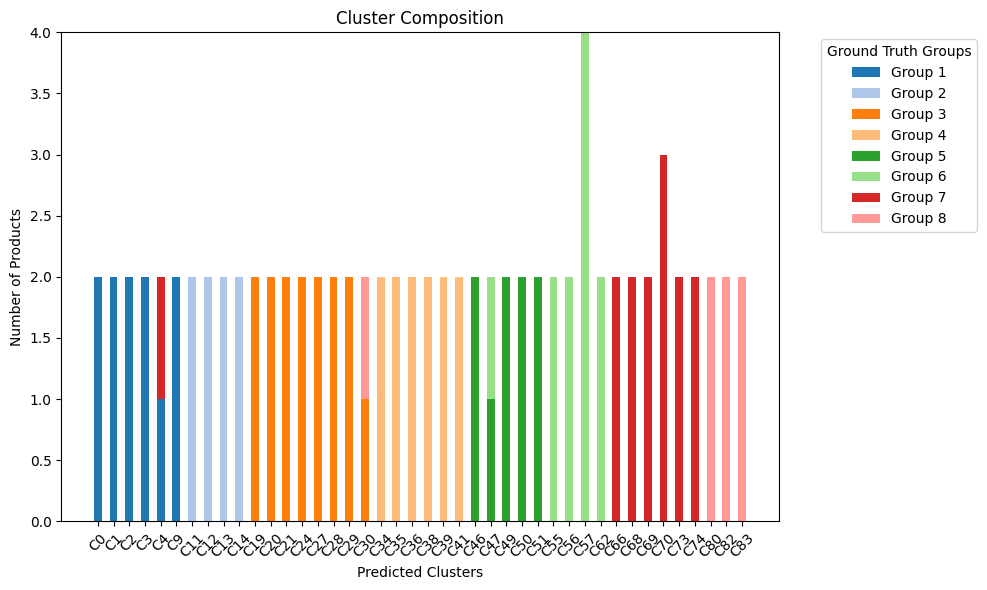


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0099, NMI: 0.1260

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G6_P1', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P10', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P1', 'G8_P2', 'G8_P4', 'G8_P5', 'G8_P6']
Cluster 33: ['G3_P15']
Cluster 49: ['G5_P9', 'G5_P4', 'G8_P3', 'G8_P7']
Cluster 56: ['G6_P2', 'G6_P9']


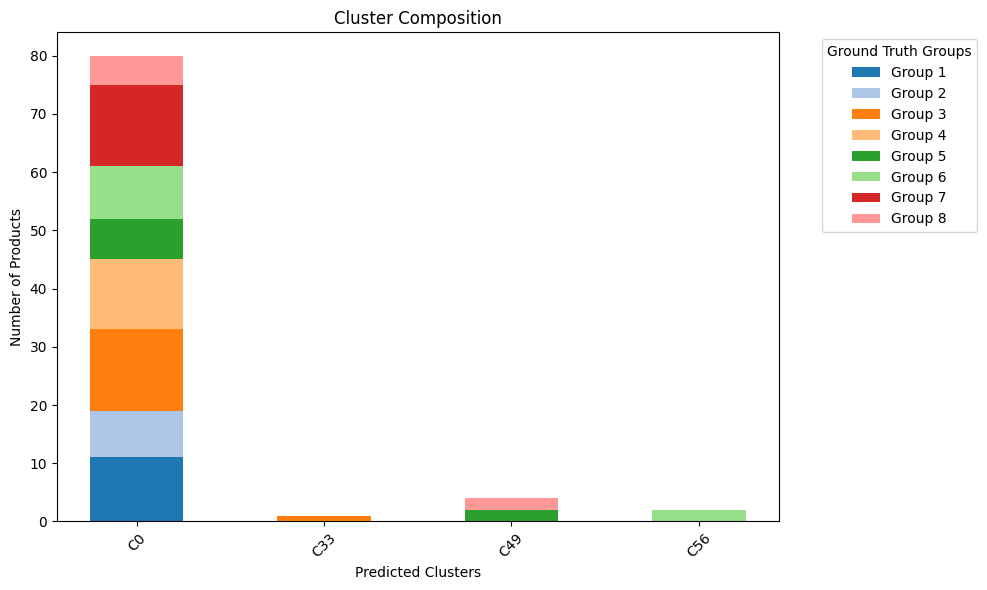


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4573, NMI: 0.7571

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P5', 'G1_P10', 'G1_P11', 'G7_P13']
Cluster 2: ['G1_P3', 'G1_P4', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P1', 'G2_P2', 'G2_P3']
Cluster 14: ['G2_P8', 'G2_P4']
Cluster 15: ['G5_P8', 'G8_P6', 'G5_P2', 'G2_P5']
Cluster 19: ['G3_P14', 'G3_P15', 'G3_P1', 'G3_P5', 'G3_P11']
Cluster 20: ['G3_P2', 'G3_P3', 'G3_P4', 'G3_P7', 'G3_P8', 'G3_P10', 'G3_P13']
Cluster 24: ['G7_P5', 'G7_P6', 'G3_P6', 'G7_P9', 'G7_P11']
Cluster 27: ['G6_P5', 'G3_P9', 'G6_P7', 'G6_P3']
Cluster 30: ['G3_P12']
Cluster 34: ['G4_P1', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P7', 'G4_P9']
Cluster 35: ['G6_P11', 'G4_P10', 'G4_P2']
Cluster 39: ['G4_P8', 'G4_P11', 'G4_P12', 'G4_P6']
Cluster 46: ['G5_P3', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P1']
Cluster 49: ['G5_P4', 'G6_P6', 'G5_P9']
Cluster 55: ['G6_P10', 'G6_P1', 'G6_P2', 'G6_P4', 'G6_P8']
Cluster 63: ['G6_P9']
C

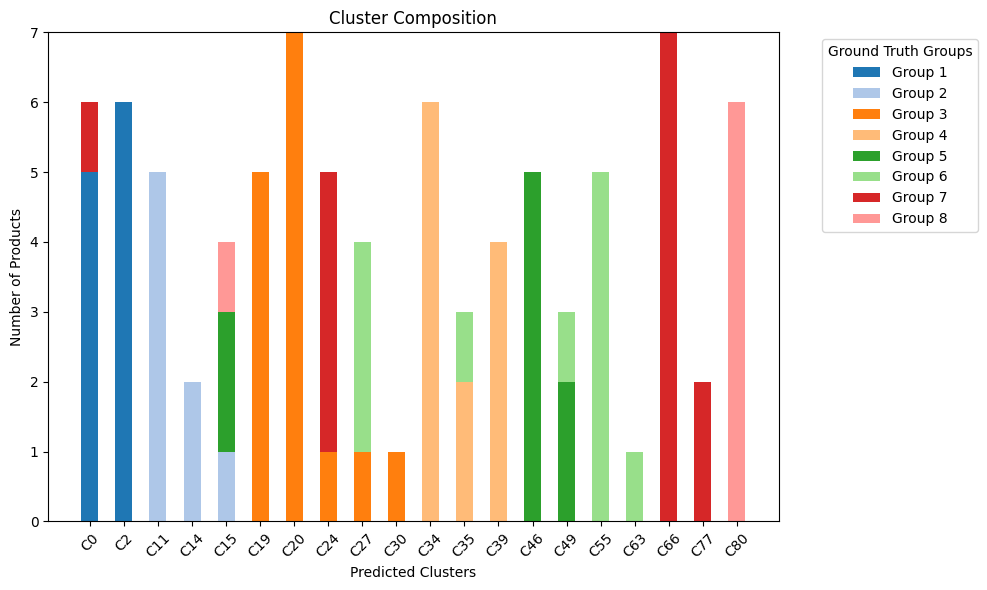


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.6596, NMI: 0.8182

Final Clustering Results:
Cluster 0: ['G1_P1', 'G6_P2']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P1', 'G2_P3', 'G6_P8']
Cluster 12: ['G2_P8', 'G2_P2', 'G5_P8', 'G2_P5']
Cluster 14: ['G3_P14', 'G3_P2', 'G3_P4', 'G3_P12', 'G2_P4']
Cluster 19: ['G3_P1', 'G3_P5']
Cluster 21: ['G3_P15', 'G3_P3', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P13']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P12']
Cluster 39: ['G4_P11', 'G4_P6']
Cluster 46: ['G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P1', 'G5_P2']
Cluster 54: ['G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P7', 'G5_P9']
Cluster 55: ['G6_P10', 'G6_P11', 'G6_P1', 'G6_P3', 'G6_P5', 'G6_P6', 'G6_P7']
Cluster 58: ['G6_P4', 'G8_P6']
Cluster 63: ['G6_P9']
Cluster 66: ['G7_P1', 'G7_P2', 'G

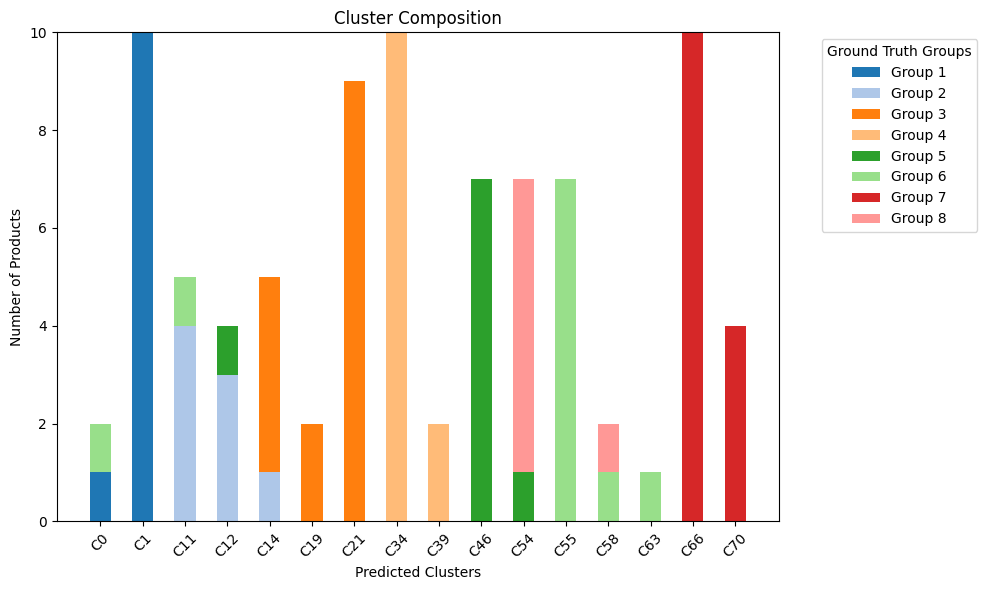


Iteration 3/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1425, NMI: 0.6707

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2']
Cluster 2: ['G1_P3', 'G1_P4', 'G1_P5']
Cluster 5: ['G1_P10', 'G1_P6']
Cluster 6: ['G1_P11', 'G1_P7']
Cluster 7: ['G1_P9', 'G1_P8']
Cluster 11: ['G2_P1', 'G8_P7']
Cluster 12: ['G2_P8', 'G2_P2']
Cluster 13: ['G2_P6', 'G2_P3']
Cluster 14: ['G2_P4', 'G2_P5']
Cluster 17: ['G6_P10', 'G2_P7']
Cluster 19: ['G3_P7', 'G3_P1']
Cluster 20: ['G3_P14', 'G3_P2']
Cluster 21: ['G3_P6', 'G3_P3']
Cluster 22: ['G3_P4', 'G7_P14']
Cluster 23: ['G3_P10', 'G3_P5']
Cluster 26: ['G3_P8', 'G3_P13']
Cluster 27: ['G3_P9', 'G3_P11']
Cluster 30: ['G3_P15', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P10']
Cluster 35: ['G4_P9', 'G4_P2']
Cluster 36: ['G4_P7', 'G4_P3']
Cluster 37: ['G4_P4', 'G4_P5']
Cluster 39: ['G4_P8', 'G4_P6']
Cluster 44: ['G4_P11', 'G4_P12']
Cluster 46: ['G5_P9', 'G5_P1', 'G5_P2']
Cluster 48: ['G5_P3', 'G7_P11']
Cluster 49: ['G5_P4', 'G5_P5', 'G5

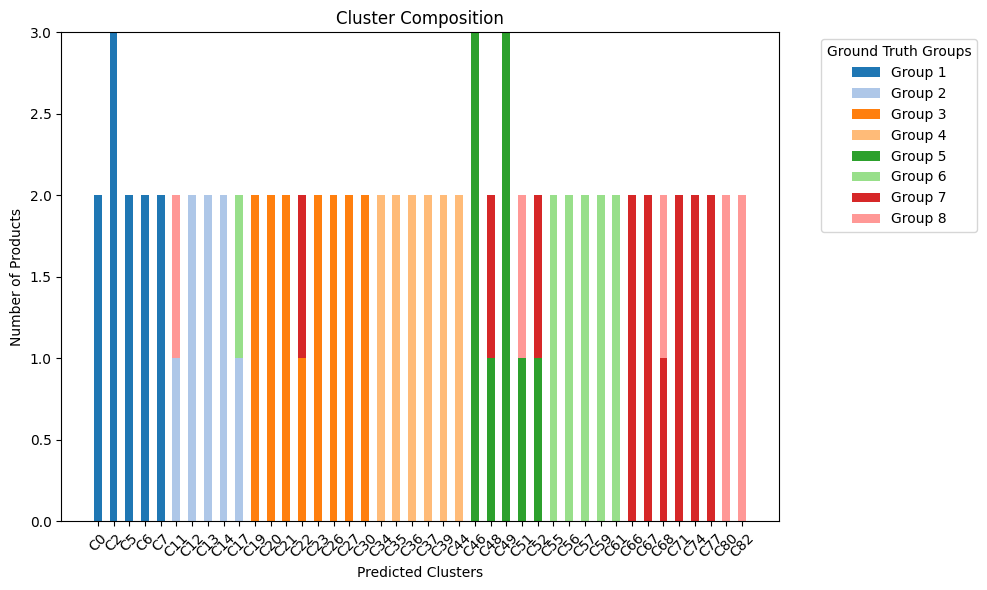


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0959, NMI: 0.3727

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P2', 'G5_P3', 'G5_P6', 'G5_P8', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P2', 'G8_P3', 'G8_P5', 'G8_P6']
Cluster 11: ['G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G8_P7']
Cluster 46: ['G5_P4', 'G5_P5', 'G5_P7', 'G5_P9', 'G5_P1']
Cluster 80: ['G8_P1', 'G8_P4']


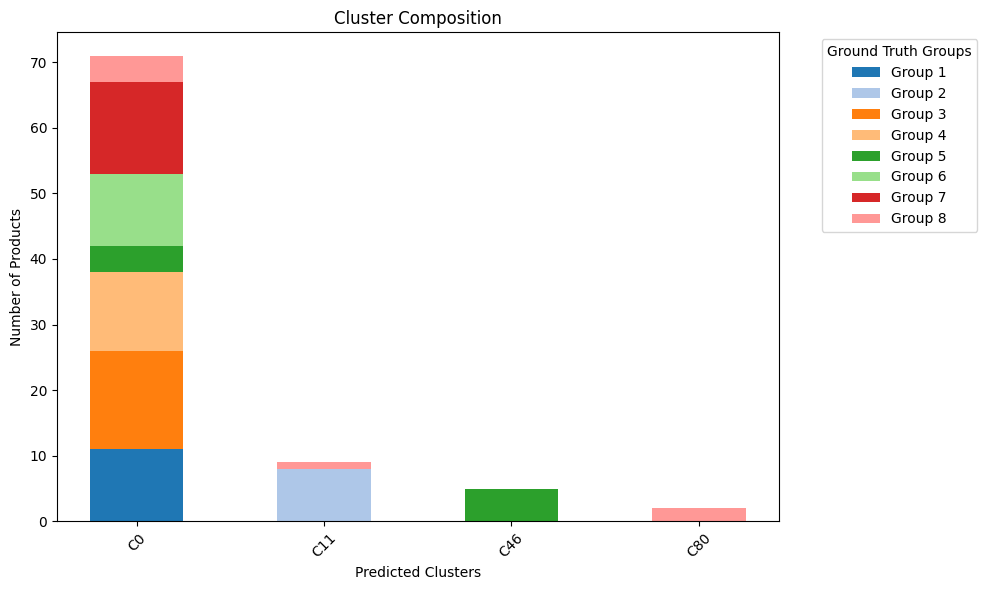


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4288, NMI: 0.7217

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G7_P11', 'G1_P7']
Cluster 2: ['G1_P3', 'G1_P4', 'G1_P5', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 5: ['G1_P6', 'G3_P5']
Cluster 11: ['G8_P2', 'G5_P6', 'G8_P6', 'G8_P7', 'G2_P1']
Cluster 12: ['G4_P9', 'G2_P2', 'G2_P4']
Cluster 13: ['G2_P6', 'G2_P8', 'G2_P3', 'G2_P5']
Cluster 17: ['G2_P7', 'G5_P5', 'G5_P7']
Cluster 19: ['G3_P14', 'G3_P1', 'G8_P5']
Cluster 20: ['G3_P6', 'G3_P9', 'G3_P2']
Cluster 21: ['G5_P3', 'G3_P15', 'G3_P3', 'G3_P10', 'G3_P11', 'G3_P12']
Cluster 22: ['G3_P7', 'G3_P8', 'G3_P4', 'G3_P13']
Cluster 34: ['G4_P1', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P12']
Cluster 35: ['G6_P5', 'G4_P2', 'G4_P11']
Cluster 43: ['G4_P10', 'G5_P8']
Cluster 46: ['G5_P9', 'G5_P4', 'G5_P1', 'G5_P2']
Cluster 55: ['G6_P10', 'G6_P1', 'G6_P2', 'G6_P4', 'G6_P7', 'G6_P8', 'G6_P9']
Cluster 57: ['G6_P11', 'G6_P3', 'G6_P6']
Cluster 66: 

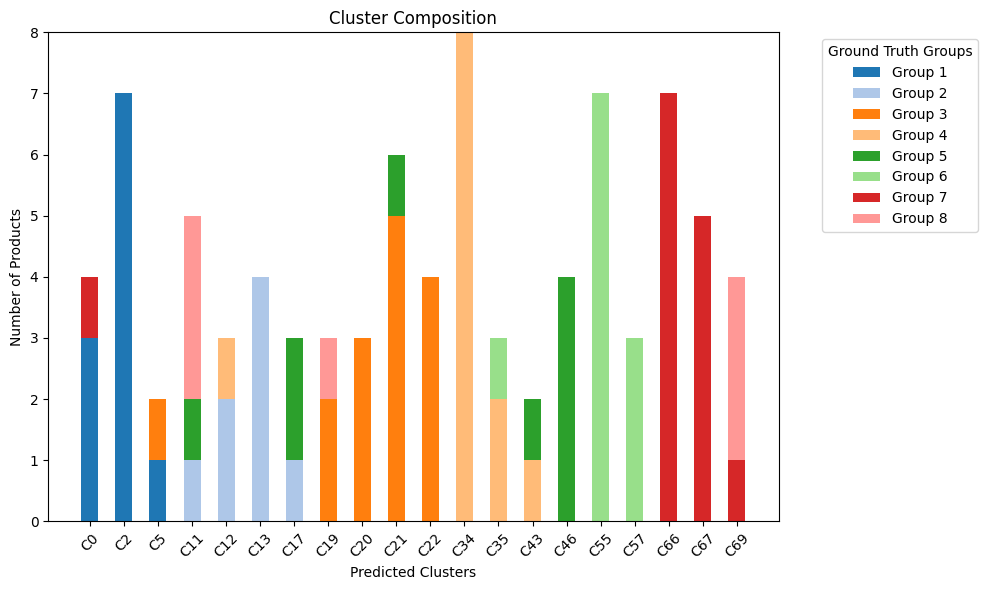


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.6387, NMI: 0.8066

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 11: ['G2_P1', 'G8_P5', 'G8_P6', 'G8_P7']
Cluster 12: ['G2_P6', 'G2_P8', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 17: ['G2_P7', 'G5_P5', 'G5_P7']
Cluster 19: ['G3_P1', 'G7_P5', 'G3_P7', 'G3_P8', 'G3_P13']
Cluster 20: ['G3_P15', 'G3_P2', 'G3_P3', 'G3_P6', 'G3_P9', 'G3_P11', 'G3_P12']
Cluster 22: ['G3_P14', 'G7_P11', 'G3_P4', 'G3_P5']
Cluster 28: ['G7_P10', 'G3_P10', 'G7_P12', 'G7_P13']
Cluster 34: ['G4_P1', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P9', 'G4_P10', 'G4_P12']
Cluster 35: ['G5_P3', 'G4_P2', 'G4_P3', 'G4_P8', 'G6_P5', 'G4_P11']
Cluster 46: ['G5_P4', 'G5_P6', 'G5_P8', 'G5_P9', 'G5_P1', 'G5_P2']
Cluster 55: ['G6_P10', 'G6_P11', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P3', 'G7_P

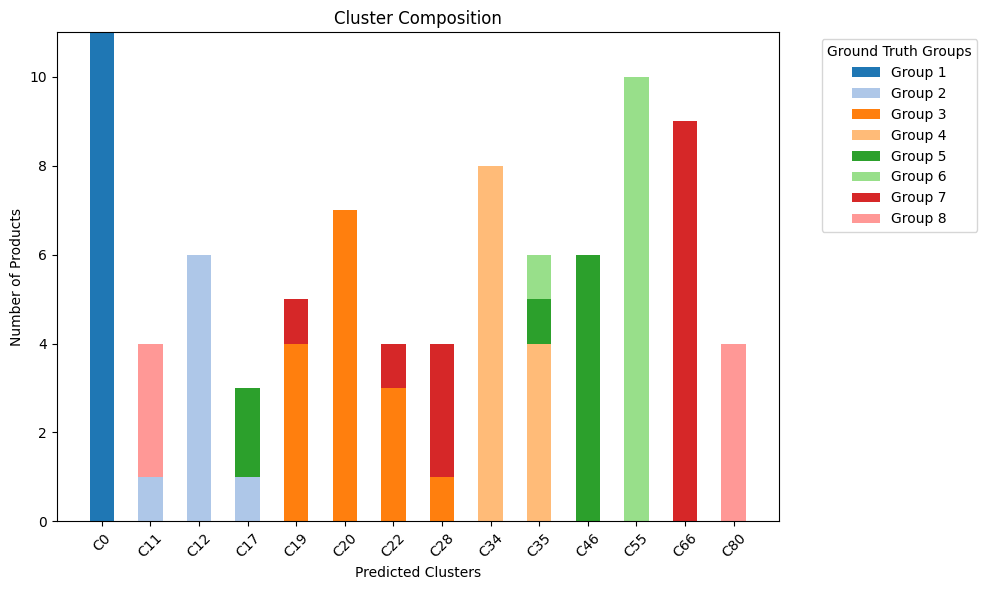


Iteration 4/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1605, NMI: 0.6850

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2']
Cluster 2: ['G1_P10', 'G1_P3']
Cluster 3: ['G1_P4', 'G1_P6']
Cluster 4: ['G1_P5', 'G1_P7']
Cluster 7: ['G1_P11', 'G1_P8']
Cluster 8: ['G1_P9', 'G7_P3']
Cluster 11: ['G2_P1', 'G2_P3', 'G2_P5']
Cluster 12: ['G2_P2', 'G2_P4']
Cluster 16: ['G2_P6', 'G2_P7']
Cluster 18: ['G2_P8', 'G3_P1']
Cluster 20: ['G3_P6', 'G3_P2']
Cluster 21: ['G3_P3', 'G3_P12']
Cluster 22: ['G3_P10', 'G3_P4']
Cluster 23: ['G3_P11', 'G3_P5']
Cluster 25: ['G3_P7', 'G3_P8']
Cluster 27: ['G3_P9', 'G3_P13']
Cluster 32: ['G3_P14', 'G6_P9']
Cluster 33: ['G3_P15', 'G4_P5']
Cluster 34: ['G4_P1', 'G5_P6']
Cluster 35: ['G4_P9', 'G4_P2']
Cluster 36: ['G4_P3', 'G4_P4']
Cluster 39: ['G4_P10', 'G4_P6']
Cluster 40: ['G4_P7', 'G4_P8']
Cluster 44: ['G4_P11', 'G4_P12']
Cluster 46: ['G5_P7', 'G5_P1', 'G5_P2']
Cluster 48: ['G5_P3', 'G5_P9']
Cluster 49: ['G5_P4', 'G5_P5', 'G5_P8'

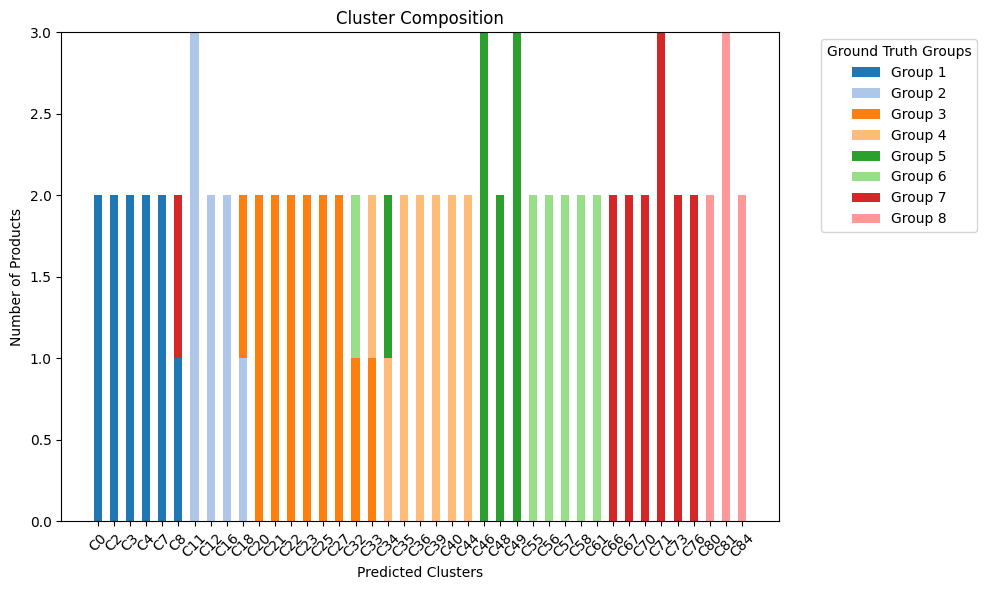


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.1001, NMI: 0.2531

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P9', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P7', 'G2_P8', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P4', 'G5_P5', 'G6_P7', 'G6_P8', 'G6_P9', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P2', 'G8_P4', 'G8_P7']
Cluster 1: ['G6_P10', 'G1_P2', 'G6_P11', 'G1_P3', 'G1_P8', 'G1_P11', 'G8_P1', 'G8_P3', 'G8_P5', 'G8_P6', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6']
Cluster 9: ['G2_P6', 'G1_P10']


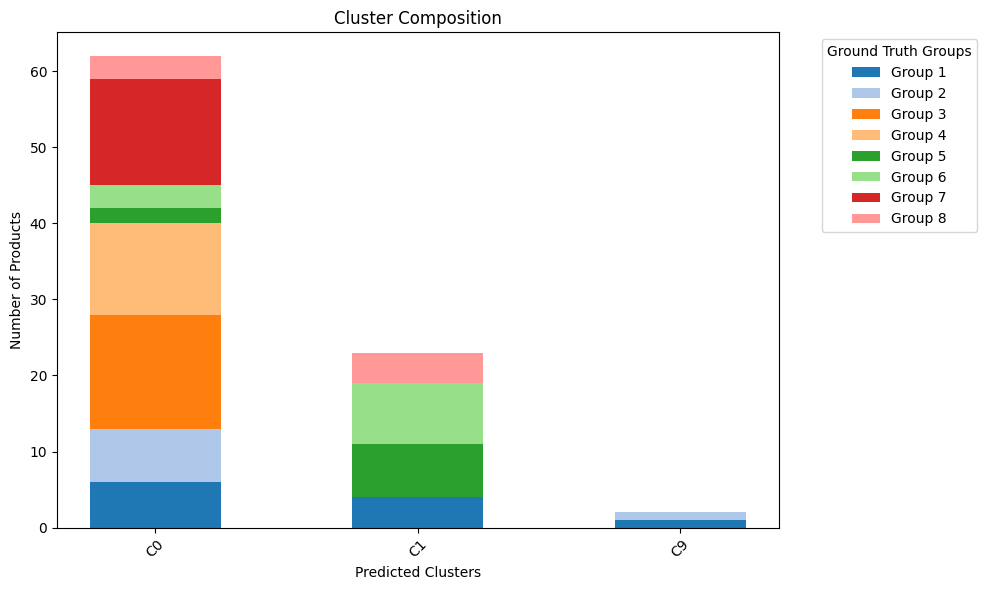


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4419, NMI: 0.7422

Final Clustering Results:
Cluster 0: ['G1_P1', 'G6_P11', 'G1_P3', 'G1_P5', 'G8_P7', 'G1_P8']
Cluster 1: ['G1_P2', 'G1_P11', 'G1_P10']
Cluster 3: ['G8_P4', 'G1_P4', 'G7_P3']
Cluster 5: ['G1_P9', 'G4_P9', 'G1_P6']
Cluster 6: ['G5_P1', 'G5_P8', 'G1_P7']
Cluster 11: ['G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 16: ['G2_P6', 'G2_P7', 'G2_P8']
Cluster 19: ['G3_P15', 'G3_P1', 'G3_P3', 'G3_P4', 'G3_P8', 'G3_P12']
Cluster 20: ['G3_P14', 'G3_P2', 'G3_P5', 'G3_P6', 'G3_P10']
Cluster 25: ['G5_P3', 'G3_P7', 'G7_P8']
Cluster 27: ['G3_P9', 'G3_P11', 'G3_P13']
Cluster 34: ['G4_P10', 'G4_P1', 'G5_P6', 'G4_P2']
Cluster 36: ['G4_P3', 'G4_P4', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P11', 'G4_P12']
Cluster 38: ['G4_P5']
Cluster 47: ['G5_P4', 'G5_P5', 'G5_P7', 'G5_P9', 'G5_P2']
Cluster 55: ['G6_P1', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P8']
Cluster 56: ['G6_P2', 'G6_P10', 'G6_P7', 'G6_P9']
Cluster 66: ['G7_P1', 'G

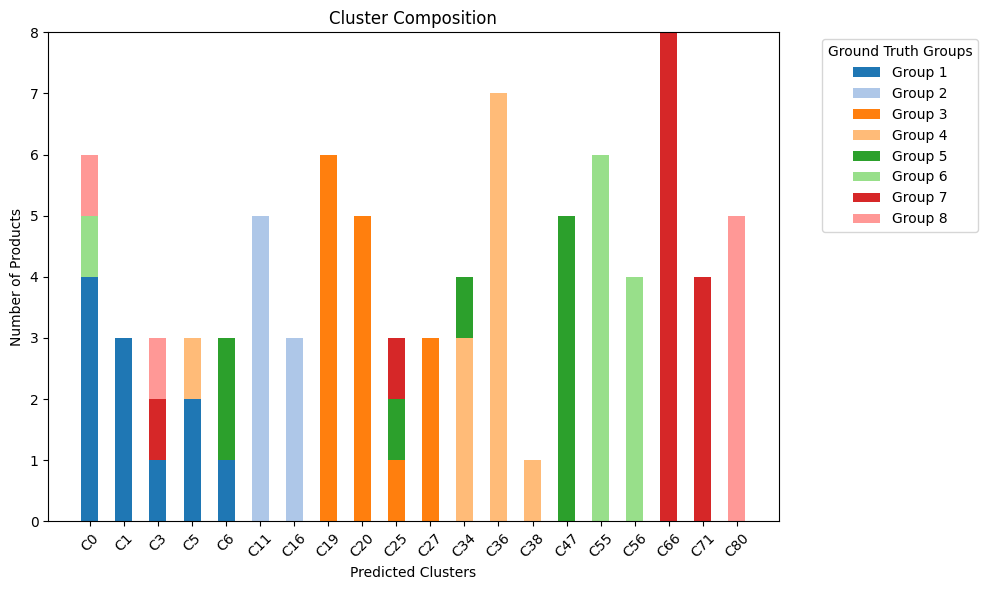


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.7759, NMI: 0.8583

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G6_P11', 'G1_P5', 'G1_P8', 'G6_P7']
Cluster 2: ['G1_P3', 'G1_P4', 'G7_P3', 'G1_P6', 'G1_P7', 'G1_P9']
Cluster 9: ['G1_P10', 'G1_P11']
Cluster 11: ['G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8']
Cluster 19: ['G3_P15', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13']
Cluster 25: ['G5_P3', 'G3_P7', 'G5_P9']
Cluster 26: ['G3_P14', 'G3_P8', 'G8_P4']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P1', 'G5_P2']
Cluster 53: ['G6_P10', 'G5_P8']
Cluster 55: ['G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P8', 'G6_P9']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7

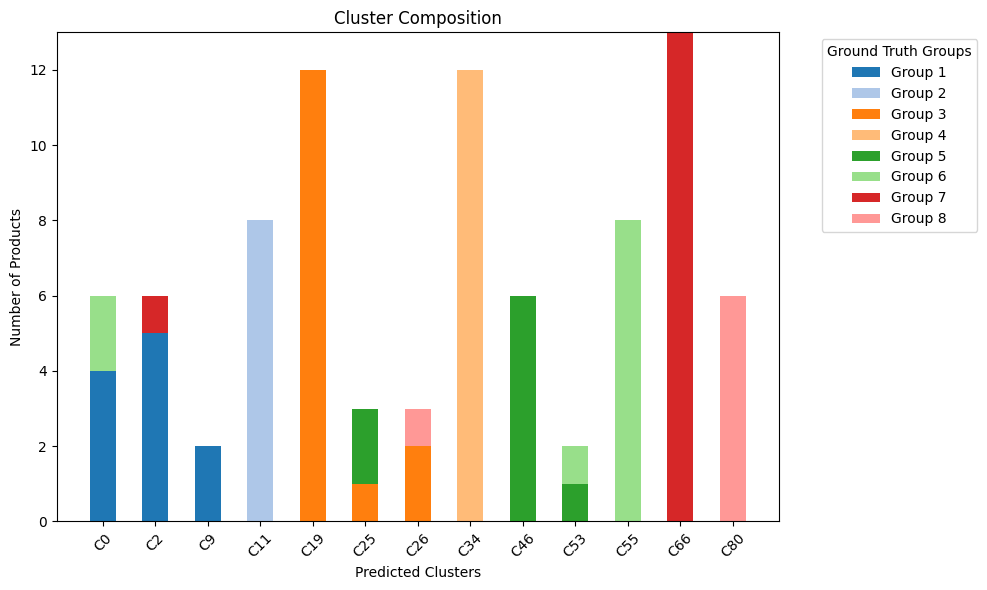


Iteration 5/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1283, NMI: 0.6620

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P11']
Cluster 1: ['G1_P2', 'G1_P8']
Cluster 2: ['G1_P3', 'G1_P6']
Cluster 3: ['G1_P9', 'G1_P4']
Cluster 4: ['G1_P5', 'G1_P7']
Cluster 9: ['G1_P10', 'G5_P1']
Cluster 11: ['G5_P3', 'G2_P1']
Cluster 12: ['G3_P6', 'G2_P2']
Cluster 13: ['G7_P3', 'G2_P3']
Cluster 14: ['G2_P4', 'G2_P5']
Cluster 16: ['G2_P6', 'G2_P7']
Cluster 18: ['G2_P8', 'G4_P9']
Cluster 19: ['G3_P15', 'G3_P1']
Cluster 20: ['G3_P7', 'G3_P2']
Cluster 21: ['G3_P3', 'G3_P13']
Cluster 22: ['G3_P14', 'G3_P4']
Cluster 23: ['G3_P10', 'G3_P5']
Cluster 26: ['G3_P8', 'G3_P11']
Cluster 27: ['G3_P9', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P10']
Cluster 35: ['G4_P7', 'G4_P2']
Cluster 36: ['G4_P3', 'G4_P12']
Cluster 37: ['G4_P11', 'G4_P4']
Cluster 38: ['G4_P5', 'G4_P6']
Cluster 41: ['G8_P1', 'G4_P8']
Cluster 47: ['G5_P6', 'G5_P2']
Cluster 49: ['G5_P4', 'G5_P9']
Cluster 50: ['G5_P5', 'G6

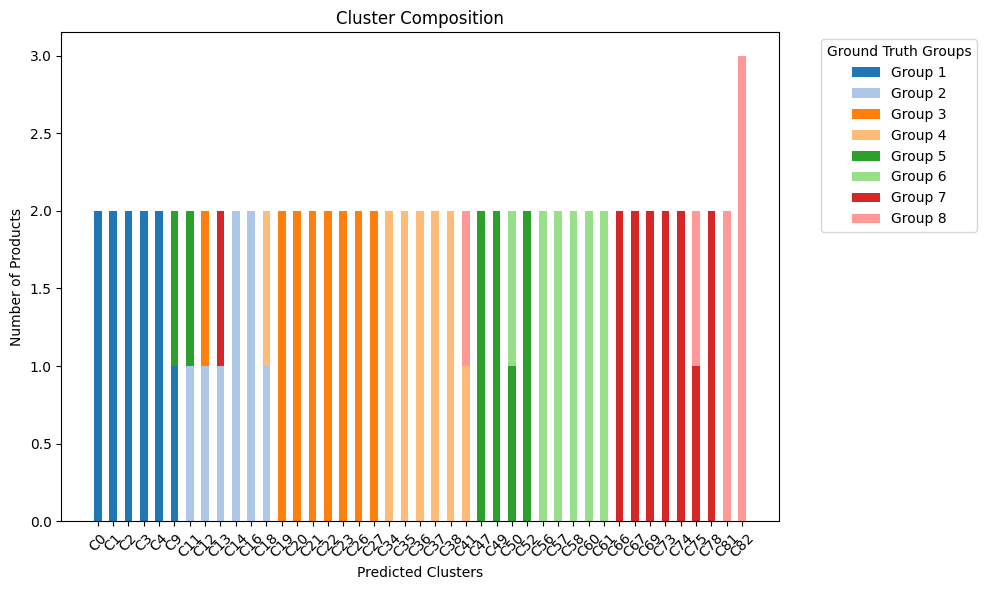


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0188, NMI: 0.1043

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P6', 'G2_P7', 'G2_P8', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P2', 'G8_P3', 'G8_P4']
Cluster 15: ['G8_P1', 'G8_P5', 'G8_P6', 'G8_P7', 'G7_P10', 'G2_P5']


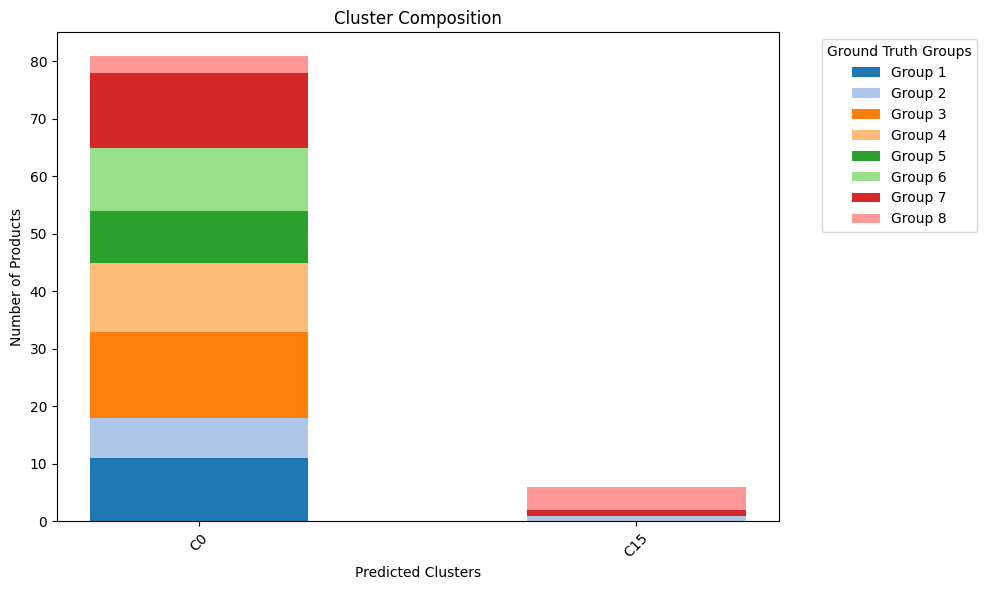


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.5982, NMI: 0.8228

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 4: ['G1_P5', 'G5_P2']
Cluster 11: ['G2_P6', 'G2_P1', 'G2_P2', 'G2_P3']
Cluster 14: ['G2_P7', 'G2_P8', 'G8_P2', 'G2_P4', 'G2_P5']
Cluster 19: ['G3_P14', 'G3_P6', 'G3_P1', 'G3_P4']
Cluster 20: ['G3_P15', 'G3_P2', 'G3_P3', 'G3_P5', 'G3_P7', 'G3_P8', 'G3_P10', 'G3_P11']
Cluster 27: ['G3_P9', 'G3_P12', 'G3_P13']
Cluster 34: ['G4_P1', 'G4_P3', 'G4_P4', 'G4_P9', 'G4_P10']
Cluster 35: ['G4_P2', 'G7_P6', 'G7_P13', 'G7_P14']
Cluster 38: ['G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P4', 'G5_P5', 'G5_P6', 'G5_P9', 'G5_P1']
Cluster 48: ['G5_P3', 'G5_P7', 'G5_P8']
Cluster 55: ['G6_P11', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P7']
Cluster 60: ['G6_P10', 'G6_P6', 'G6_P8', 'G6_P9']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 

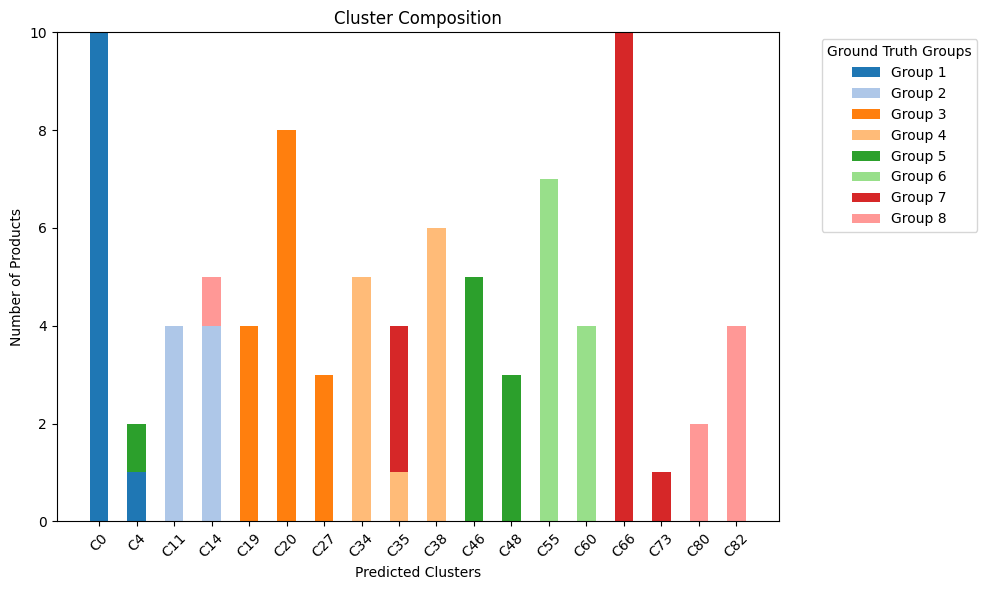


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.6518, NMI: 0.8300

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 4: ['G7_P2', 'G1_P5', 'G7_P6', 'G7_P8', 'G7_P9', 'G7_P11', 'G7_P12']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P5']
Cluster 14: ['G2_P8', 'G5_P6', 'G2_P4']
Cluster 19: ['G3_P15', 'G3_P1', 'G3_P2', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11']
Cluster 21: ['G3_P14', 'G3_P3', 'G3_P4', 'G3_P12', 'G3_P13']
Cluster 34: ['G4_P1', 'G4_P10']
Cluster 35: ['G4_P7', 'G7_P1', 'G4_P2', 'G7_P5']
Cluster 36: ['G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P8', 'G4_P9', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P3', 'G5_P4', 'G5_P5', 'G5_P9', 'G5_P1', 'G5_P2']
Cluster 52: ['G5_P7', 'G5_P8']
Cluster 55: ['G6_P11', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9']
Cluster 64: ['G6_P10']
Cluster 68: ['G7_P3', 'G7_P4', 'G7_

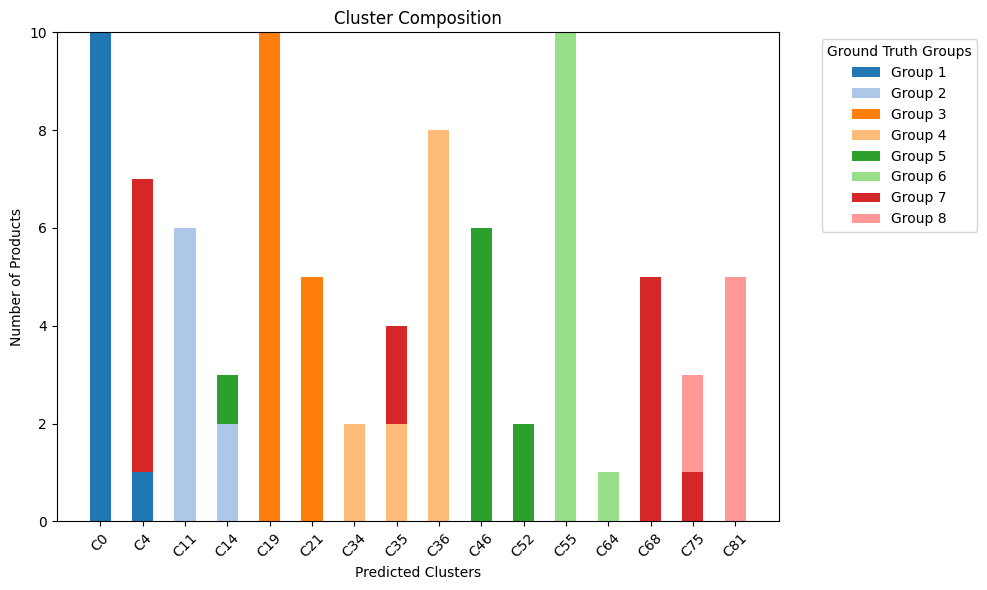


Iteration 6/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1465, NMI: 0.6796

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2']
Cluster 2: ['G1_P3', 'G1_P4']
Cluster 4: ['G4_P8', 'G1_P5']
Cluster 5: ['G1_P6', 'G1_P7']
Cluster 7: ['G1_P10', 'G1_P8']
Cluster 8: ['G1_P9', 'G1_P11']
Cluster 11: ['G2_P8', 'G2_P1']
Cluster 12: ['G2_P6', 'G2_P2']
Cluster 13: ['G2_P3', 'G2_P4']
Cluster 15: ['G2_P7', 'G2_P5']
Cluster 19: ['G3_P14', 'G3_P1']
Cluster 20: ['G3_P2', 'G7_P4']
Cluster 21: ['G3_P9', 'G3_P3']
Cluster 22: ['G3_P4', 'G3_P13']
Cluster 23: ['G3_P6', 'G3_P5']
Cluster 25: ['G3_P7', 'G3_P8']
Cluster 28: ['G3_P15', 'G3_P10', 'G8_P6']
Cluster 29: ['G3_P11', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P11']
Cluster 35: ['G4_P2', 'G5_P8']
Cluster 36: ['G4_P3', 'G4_P5']
Cluster 37: ['G4_P7', 'G4_P4']
Cluster 39: ['G4_P9', 'G4_P12', 'G4_P6']
Cluster 43: ['G4_P10', 'G6_P8']
Cluster 46: ['G5_P3', 'G5_P1']
Cluster 47: ['G5_P6', 'G5_P2']
Cluster 49: ['G5_P4', 'G5_P5']
Cluster

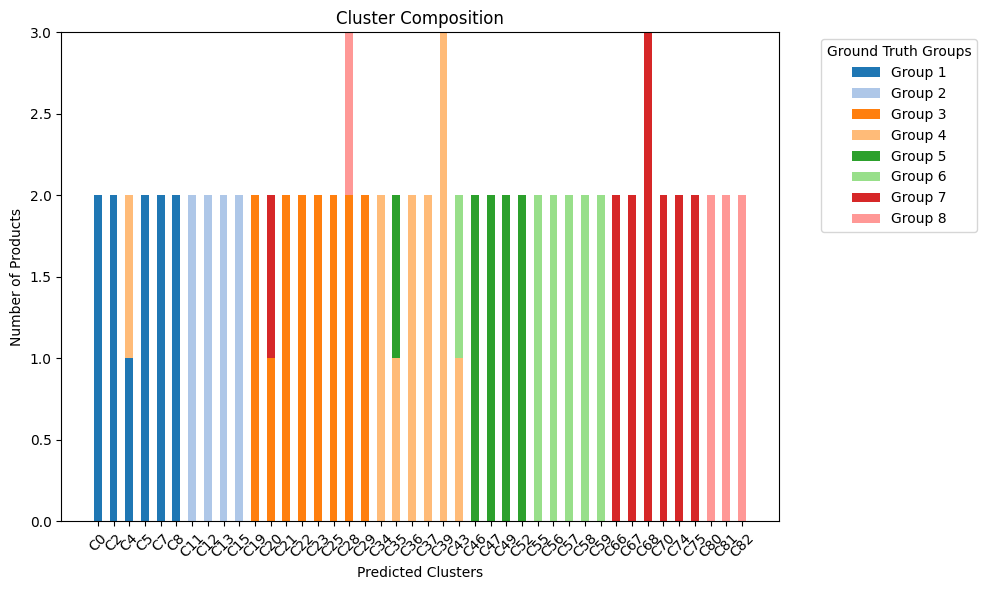


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0608, NMI: 0.2583

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P2', 'G4_P10', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7']
Cluster 34: ['G6_P10', 'G4_P1', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P11', 'G4_P12', 'G6_P8']
Cluster 58: ['G6_P4', 'G6_P9']


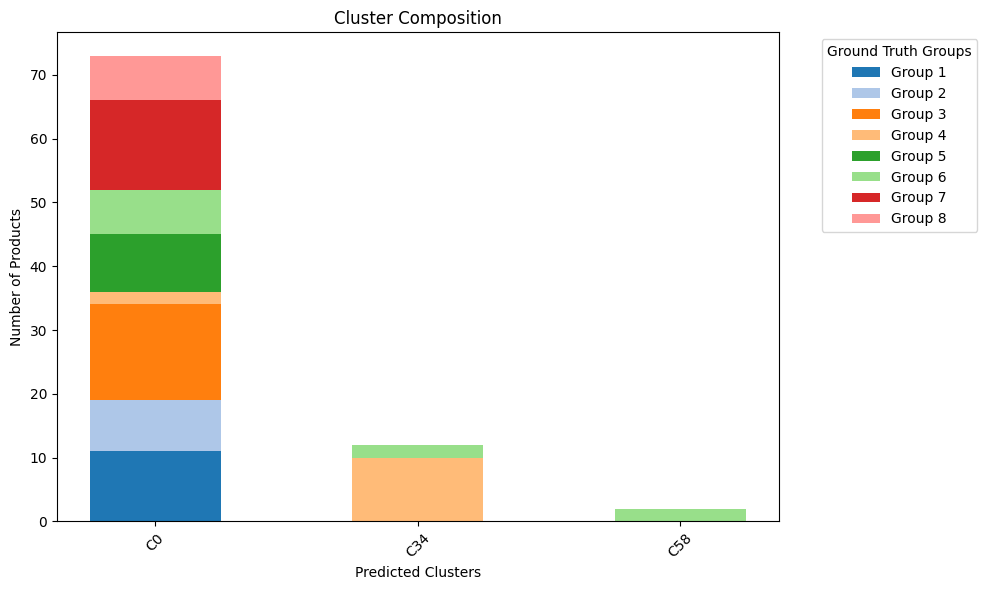


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4529, NMI: 0.7512

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P6', 'G1_P7', 'G1_P9', 'G1_P11']
Cluster 2: ['G5_P4', 'G2_P8', 'G5_P6', 'G1_P3', 'G1_P4']
Cluster 4: ['G1_P10', 'G4_P2', 'G1_P5']
Cluster 7: ['G6_P10', 'G6_P11', 'G6_P1', 'G1_P8', 'G6_P8']
Cluster 11: ['G2_P1', 'G7_P4']
Cluster 12: ['G2_P6', 'G2_P7', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 19: ['G3_P1', 'G3_P3', 'G3_P5']
Cluster 20: ['G3_P14', 'G3_P2', 'G3_P6', 'G3_P7', 'G3_P9', 'G3_P11', 'G3_P12']
Cluster 22: ['G3_P8', 'G3_P10', 'G3_P4', 'G3_P13']
Cluster 33: ['G3_P15', 'G5_P5']
Cluster 34: ['G4_P1', 'G4_P3', 'G4_P5', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11']
Cluster 37: ['G4_P7', 'G4_P12', 'G4_P4', 'G4_P6']
Cluster 46: ['G5_P3', 'G5_P7', 'G5_P8', 'G5_P9', 'G5_P1']
Cluster 47: ['G8_P2', 'G8_P3', 'G8_P6', 'G8_P7', 'G5_P2']
Cluster 56: ['G6_P2', 'G6_P3', 'G6_P4', 'G6_P6', 'G6_P7', 'G6_P9']
Cluster 59: ['G8_P1', 'G8_P4', 'G6_P5', 'G8_P5']


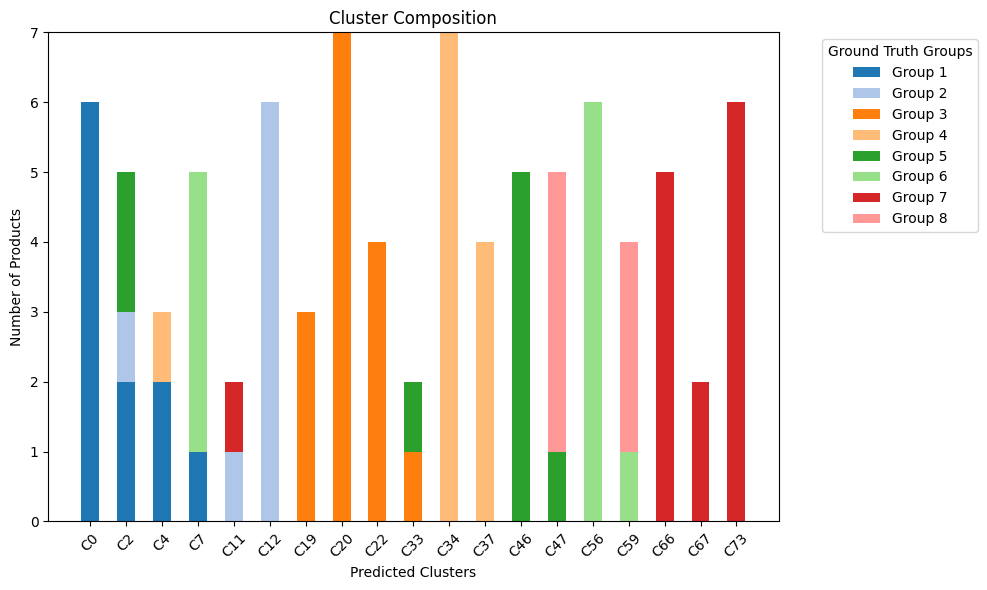


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.7067, NMI: 0.8579

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 2: ['G3_P15', 'G1_P3', 'G8_P6']
Cluster 7: ['G6_P10', 'G6_P11', 'G6_P1', 'G1_P8', 'G6_P7', 'G6_P8']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 18: ['G2_P8', 'G3_P3', 'G3_P5', 'G3_P6', 'G3_P9']
Cluster 19: ['G3_P14', 'G3_P1', 'G3_P4', 'G3_P7', 'G3_P8', 'G3_P10', 'G3_P13']
Cluster 20: ['G3_P2', 'G3_P11', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9']
Cluster 56: ['G6_P2', 'G6_P3', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P9']
Cluster 66: ['G7_P1', 'G7_P3', 'G7_P5', 'G7_P6', 'G7_P8', 'G7_P10', 'G7_P13', 'G7_P14']
Cluster 67: ['G7_P2', 'G7_P4', 'G7_P7', 'G7_P9', 'G7

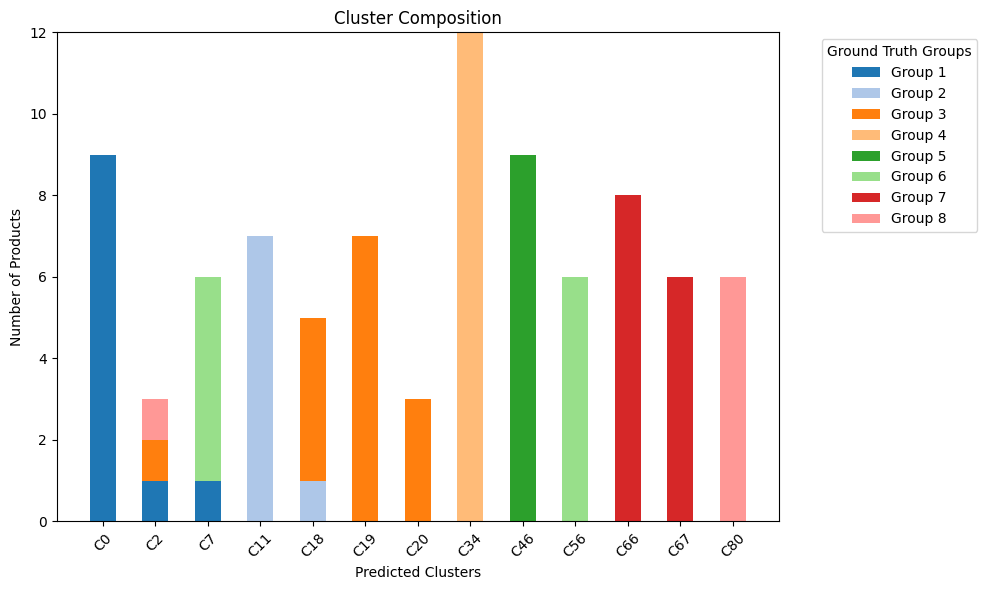


Iteration 7/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1356, NMI: 0.6536

Final Clustering Results:
Cluster 0: ['G1_P1', 'G2_P2']
Cluster 1: ['G1_P2', 'G1_P5']
Cluster 2: ['G1_P3', 'G1_P4']
Cluster 5: ['G4_P3', 'G1_P6']
Cluster 6: ['G4_P7', 'G4_P9', 'G1_P7']
Cluster 7: ['G1_P10', 'G1_P8']
Cluster 8: ['G1_P9', 'G1_P11']
Cluster 11: ['G2_P7', 'G2_P1']
Cluster 13: ['G3_P11', 'G8_P4', 'G2_P3']
Cluster 14: ['G2_P6', 'G2_P4']
Cluster 15: ['G2_P8', 'G2_P5']
Cluster 19: ['G3_P6', 'G3_P1']
Cluster 20: ['G3_P2', 'G3_P13']
Cluster 21: ['G3_P3', 'G3_P4']
Cluster 23: ['G6_P5', 'G3_P5']
Cluster 25: ['G3_P7', 'G7_P3']
Cluster 26: ['G3_P15', 'G3_P8']
Cluster 27: ['G4_P10', 'G3_P9']
Cluster 28: ['G3_P10', 'G3_P12']
Cluster 32: ['G3_P14', 'G7_P8']
Cluster 34: ['G4_P1', 'G4_P12']
Cluster 35: ['G4_P2', 'G4_P11']
Cluster 37: ['G4_P4', 'G4_P5']
Cluster 39: ['G4_P8', 'G4_P6']
Cluster 46: ['G5_P8', 'G5_P1']
Cluster 47: ['G5_P6', 'G5_P2']
Cluster 48: ['G5_P3', 'G5_P9']
Cluster 

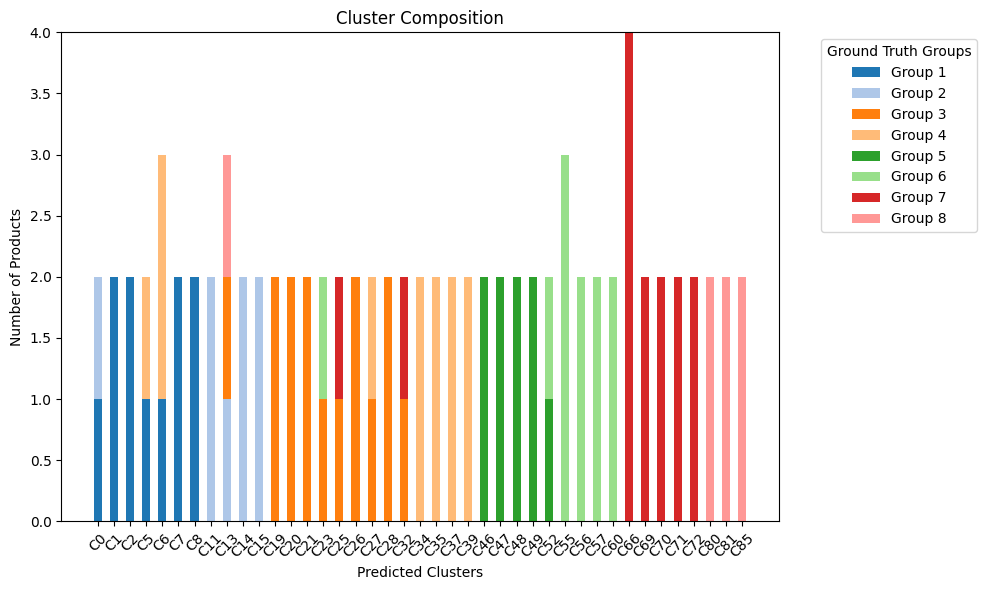


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0455, NMI: 0.2282

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P3', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P8', 'G5_P9', 'G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9', 'G6_P10', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5', 'G8_P6', 'G8_P7']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P8', 'G2_P1', 'G2_P2', 'G2_P4', 'G2_P5']
Cluster 52: ['G6_P5', 'G5_P7']


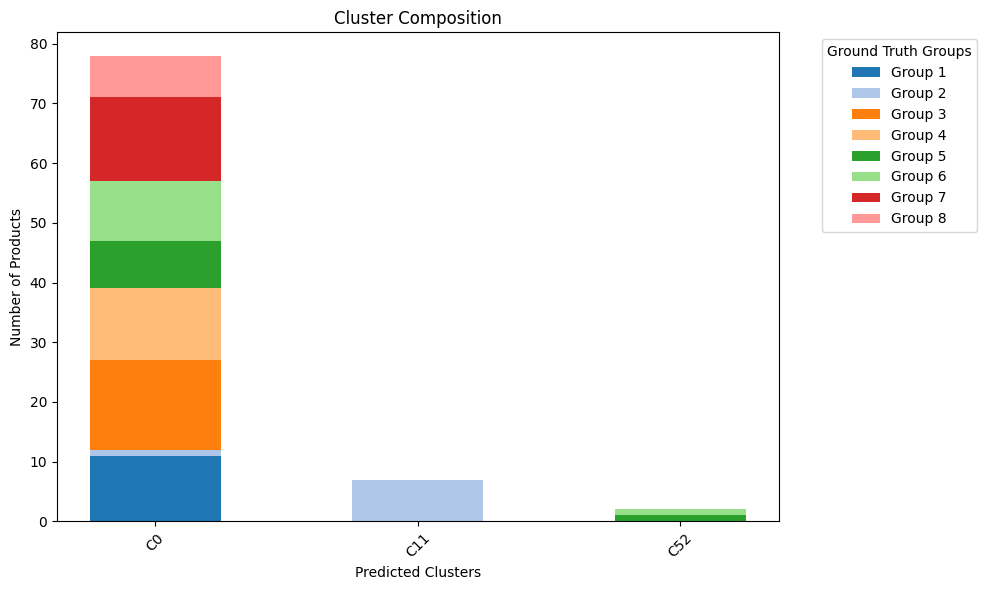


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.5220, NMI: 0.7598

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 1: ['G1_P2', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P8', 'G4_P11']
Cluster 2: ['G1_P3', 'G1_P7']
Cluster 11: ['G2_P6', 'G2_P8', 'G2_P1', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 12: ['G2_P7', 'G2_P2']
Cluster 19: ['G3_P6', 'G5_P4', 'G3_P1', 'G3_P3']
Cluster 20: ['G3_P14', 'G3_P15', 'G3_P2', 'G3_P8', 'G3_P9', 'G3_P13']
Cluster 22: ['G6_P11', 'G4_P2', 'G3_P11', 'G3_P4']
Cluster 23: ['G6_P5', 'G6_P7', 'G3_P5']
Cluster 25: ['G3_P7', 'G7_P3', 'G7_P12', 'G3_P12']
Cluster 28: ['G3_P10']
Cluster 34: ['G4_P1', 'G4_P7', 'G6_P3', 'G4_P9', 'G4_P12']
Cluster 36: ['G4_P10', 'G4_P3', 'G5_P8']
Cluster 46: ['G5_P3', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P9', 'G5_P1', 'G5_P2']
Cluster 55: ['G6_P10', 'G6_P1', 'G6_P2', 'G6_P4', 'G6_P6', 'G6_P9']
Cluster 62: ['G6_P8']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P4', 'G7_P5', 'G7

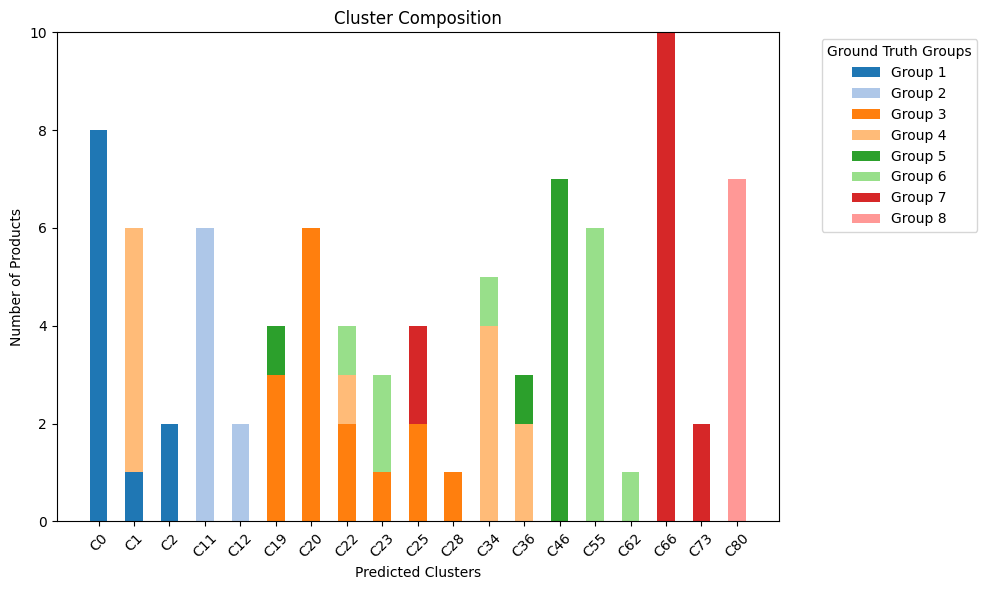


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.7811, NMI: 0.8690

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P9', 'G1_P11', 'G6_P6']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P10']
Cluster 11: ['G2_P1', 'G4_P3', 'G6_P8']
Cluster 12: ['G2_P7', 'G2_P2']
Cluster 13: ['G2_P6', 'G2_P8', 'G2_P3', 'G2_P4', 'G2_P5']
Cluster 19: ['G3_P14', 'G3_P15', 'G3_P1', 'G3_P2', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P8', 'G3_P9', 'G3_P11', 'G3_P12', 'G3_P13']
Cluster 21: ['G3_P7', 'G3_P10', 'G3_P3']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P4', 'G4_P5', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P11', 'G4_P12']
Cluster 39: ['G6_P11', 'G4_P10', 'G4_P6']
Cluster 46: ['G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9']
Cluster 55: ['G6_P1', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P7', 'G6_P9']
Cluster 59: ['G6_P10', 'G6_P5']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12'

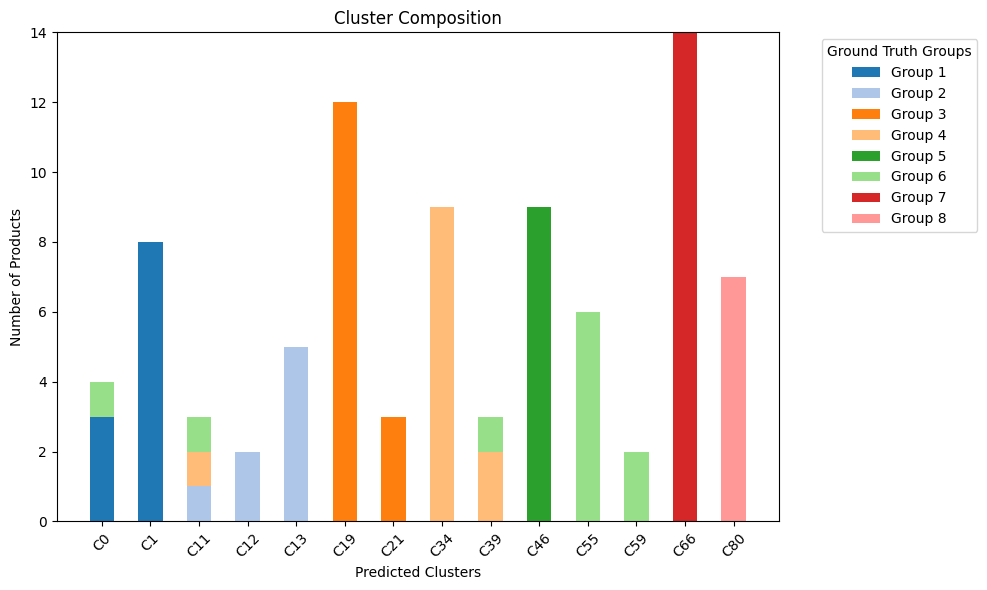


Iteration 8/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1161, NMI: 0.6455

Final Clustering Results:
Cluster 0: ['G1_P1', 'G7_P7']
Cluster 1: ['G1_P2', 'G6_P8']
Cluster 2: ['G1_P3', 'G1_P8']
Cluster 3: ['G1_P11', 'G1_P4']
Cluster 4: ['G8_P4', 'G1_P5']
Cluster 5: ['G1_P10', 'G1_P6']
Cluster 6: ['G2_P2', 'G1_P7']
Cluster 8: ['G1_P9', 'G6_P9']
Cluster 11: ['G2_P1', 'G2_P4']
Cluster 13: ['G2_P8', 'G2_P3']
Cluster 15: ['G2_P7', 'G2_P5']
Cluster 16: ['G2_P6', 'G5_P3']
Cluster 19: ['G3_P1', 'G3_P4']
Cluster 20: ['G3_P2', 'G3_P10']
Cluster 21: ['G3_P14', 'G3_P3']
Cluster 23: ['G3_P15', 'G3_P5']
Cluster 24: ['G3_P6', 'G3_P9']
Cluster 25: ['G3_P7', 'G3_P8']
Cluster 29: ['G3_P11', 'G3_P13']
Cluster 30: ['G8_P6', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P12']
Cluster 35: ['G4_P2', 'G4_P5']
Cluster 36: ['G8_P3', 'G4_P3']
Cluster 37: ['G4_P10', 'G4_P4']
Cluster 39: ['G4_P9', 'G4_P6']
Cluster 40: ['G4_P7', 'G4_P8']
Cluster 44: ['G4_P11', 'G5_P7']
Cluster 46: ['G5_P6', 'G5_P

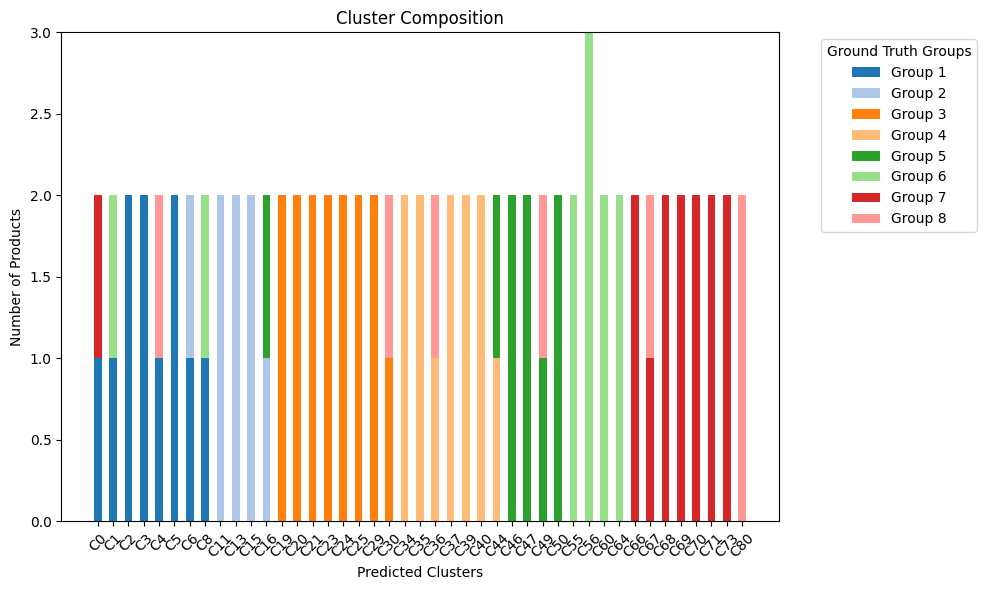


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0963, NMI: 0.3171

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P10', 'G1_P11', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G6_P4', 'G6_P7', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P1', 'G8_P2', 'G8_P3', 'G8_P4', 'G8_P5']
Cluster 8: ['G8_P6', 'G1_P9', 'G6_P3', 'G6_P2', 'G6_P5', 'G6_P6', 'G6_P9']
Cluster 11: ['G6_P10', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G8_P7', 'G6_P1', 'G6_P8']


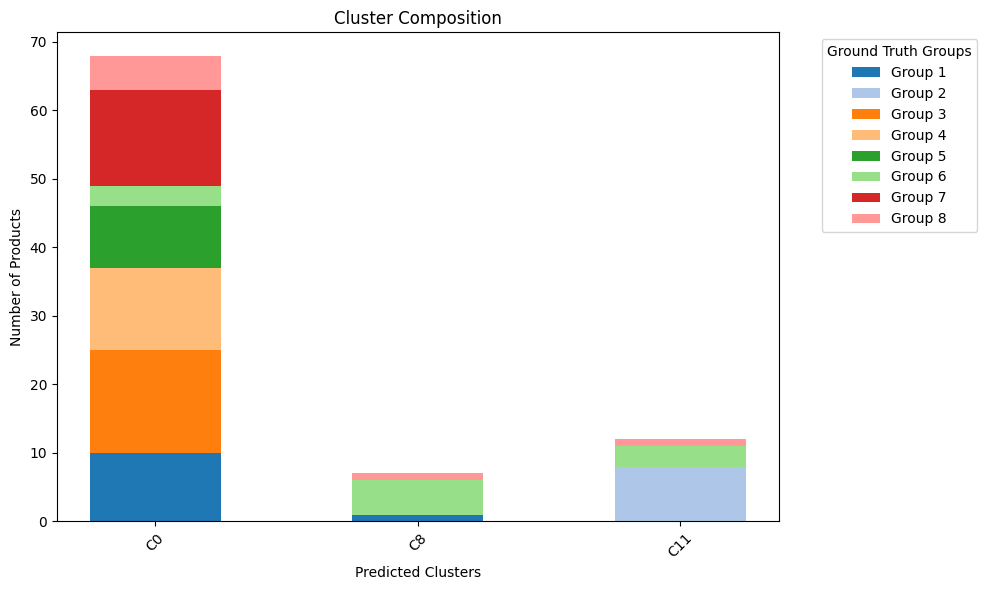


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4898, NMI: 0.7559

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P5', 'G1_P7']
Cluster 1: ['G1_P2', 'G1_P3', 'G1_P4', 'G1_P10', 'G1_P11']
Cluster 5: ['G2_P3', 'G1_P6', 'G3_P12']
Cluster 7: ['G1_P9', 'G5_P4', 'G6_P2', 'G1_P8']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P8', 'G2_P1', 'G2_P2', 'G2_P4', 'G2_P5']
Cluster 19: ['G3_P14', 'G3_P1', 'G3_P2', 'G3_P4', 'G3_P7', 'G3_P9', 'G3_P10', 'G3_P13']
Cluster 21: ['G3_P15', 'G3_P3', 'G3_P5', 'G3_P6', 'G3_P8']
Cluster 29: ['G6_P3', 'G3_P11', 'G6_P9']
Cluster 34: ['G4_P1', 'G4_P3', 'G4_P4', 'G4_P7', 'G4_P8', 'G4_P10', 'G4_P12']
Cluster 35: ['G4_P2', 'G4_P11', 'G4_P5', 'G4_P6']
Cluster 42: ['G7_P7', 'G4_P9', 'G7_P5']
Cluster 46: ['G5_P3', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P9', 'G5_P1']
Cluster 47: ['G7_P6', 'G7_P8', 'G7_P10', 'G7_P11', 'G5_P2']
Cluster 53: ['G5_P8', 'G6_P1']
Cluster 58: ['G6_P10', 'G6_P11', 'G6_P4', 'G6_P7', 'G6_P8']
Cluster 59: ['G6_P5', 'G6_P6', 'G7_P13']
Cluste

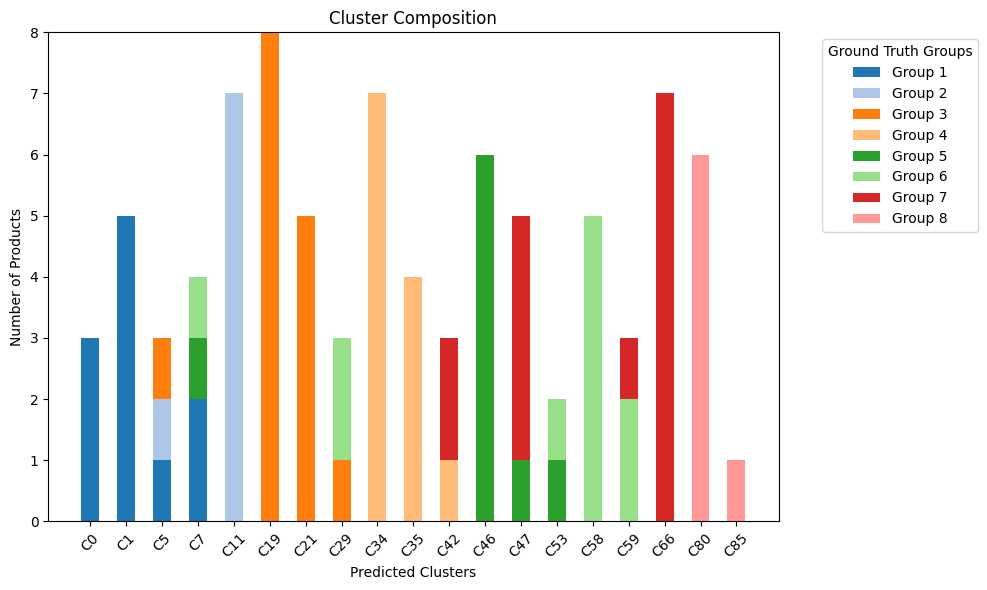


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.6744, NMI: 0.8417

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P8', 'G1_P10', 'G1_P11']
Cluster 1: ['G1_P2', 'G6_P1', 'G6_P9']
Cluster 6: ['G1_P9', 'G8_P6', 'G1_P7', 'G3_P12']
Cluster 11: ['G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8']
Cluster 19: ['G3_P14', 'G3_P1', 'G3_P2', 'G3_P10']
Cluster 21: ['G3_P15', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P11', 'G3_P13']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P12']
Cluster 44: ['G4_P11']
Cluster 46: ['G5_P3', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G5_P1', 'G5_P2']
Cluster 49: ['G5_P4', 'G6_P2', 'G6_P3', 'G6_P5', 'G6_P6']
Cluster 58: ['G6_P10', 'G6_P11', 'G6_P4', 'G6_P7', 'G6_P8']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P3', 'G7_P9', 'G7_P12', 'G7_P14']
Cluster 69: ['G7_P4', 'G7_P5', 'G7_P7', 'G7_P8', 'G7_P11',

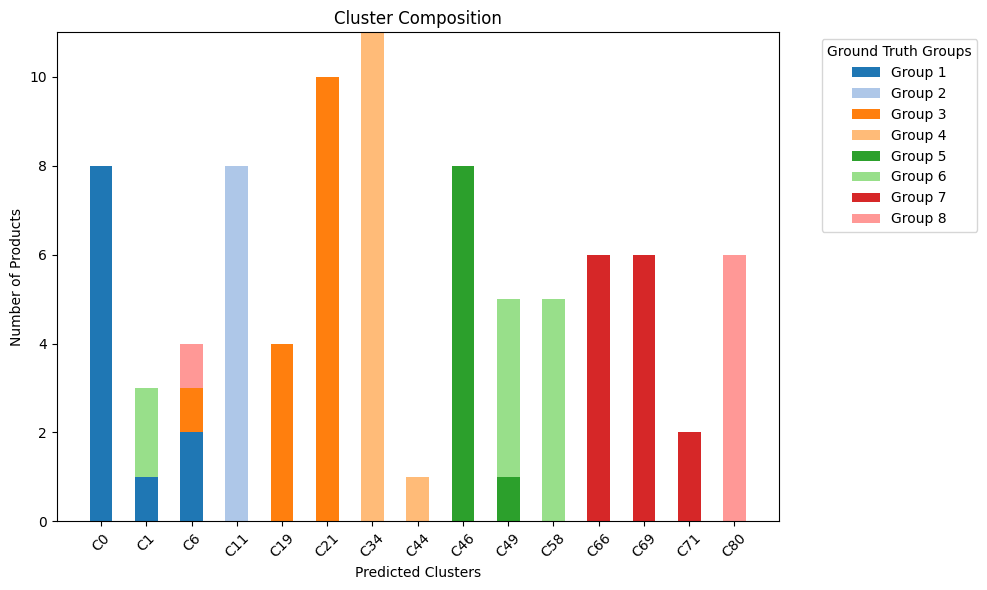


Iteration 9/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1377, NMI: 0.6635

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P11']
Cluster 1: ['G6_P11', 'G1_P2']
Cluster 2: ['G1_P10', 'G1_P3']
Cluster 3: ['G1_P4', 'G1_P7']
Cluster 4: ['G1_P9', 'G1_P5']
Cluster 5: ['G8_P6', 'G1_P6']
Cluster 7: ['G7_P9', 'G1_P8']
Cluster 11: ['G2_P1', 'G2_P5']
Cluster 12: ['G2_P2', 'G2_P3']
Cluster 14: ['G2_P7', 'G2_P4']
Cluster 16: ['G2_P6', 'G7_P4']
Cluster 18: ['G2_P8', 'G4_P6']
Cluster 19: ['G3_P1', 'G3_P4']
Cluster 20: ['G3_P2', 'G3_P5']
Cluster 21: ['G3_P11', 'G3_P3']
Cluster 24: ['G3_P6', 'G3_P7']
Cluster 26: ['G3_P8', 'G3_P12']
Cluster 27: ['G3_P9', 'G3_P10']
Cluster 31: ['G3_P14', 'G3_P13']
Cluster 33: ['G3_P15', 'G6_P3']
Cluster 34: ['G4_P1', 'G4_P3']
Cluster 35: ['G4_P2', 'G4_P12']
Cluster 37: ['G4_P7', 'G4_P9', 'G4_P10', 'G4_P4']
Cluster 38: ['G4_P8', 'G4_P5']
Cluster 44: ['G4_P11', 'G5_P8']
Cluster 46: ['G5_P3', 'G5_P1']
Cluster 47: ['G5_P7', 'G5_P2']
Cluster

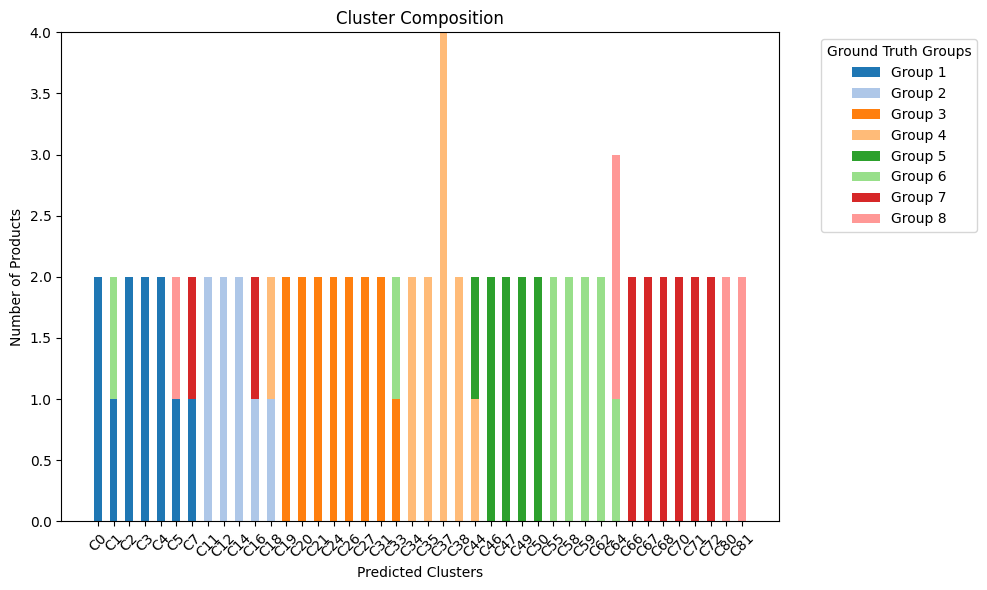


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.1201, NMI: 0.3150

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P5', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P7', 'G5_P8', 'G5_P9', 'G6_P3', 'G6_P10', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P3', 'G8_P7']
Cluster 11: ['G6_P11', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G8_P1', 'G8_P2', 'G2_P6', 'G8_P4', 'G8_P5', 'G8_P6', 'G2_P8', 'G2_P7', 'G6_P1', 'G6_P2', 'G6_P4', 'G6_P5', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P9']


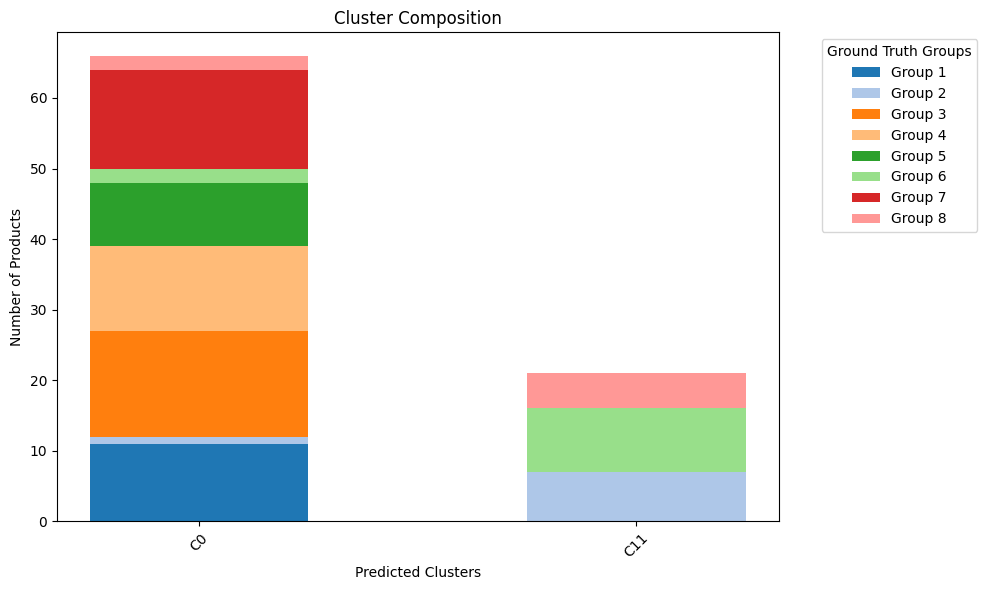


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4833, NMI: 0.7710

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P3', 'G1_P5', 'G1_P8', 'G1_P10']
Cluster 1: ['G1_P2', 'G1_P6']
Cluster 3: ['G1_P4', 'G1_P7', 'G1_P9', 'G1_P11', 'G4_P11']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P1', 'G2_P4']
Cluster 12: ['G2_P8', 'G2_P2', 'G2_P3', 'G2_P5']
Cluster 19: ['G3_P1', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12']
Cluster 20: ['G3_P14', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P7', 'G3_P13']
Cluster 23: ['G5_P3', 'G8_P2', 'G3_P5']
Cluster 24: ['G3_P6', 'G5_P6', 'G5_P8']
Cluster 33: ['G3_P15', 'G6_P6']
Cluster 34: ['G4_P7', 'G4_P1', 'G4_P2', 'G4_P6']
Cluster 36: ['G4_P3', 'G4_P4', 'G4_P5', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P12']
Cluster 46: ['G5_P4', 'G5_P5', 'G5_P7', 'G5_P9', 'G5_P1', 'G5_P2']
Cluster 55: ['G7_P2', 'G7_P6', 'G6_P1']
Cluster 56: ['G6_P10', 'G6_P11', 'G6_P2', 'G6_P3', 'G6_P4', 'G6_P7', 'G6_P8']
Cluster 59: ['G6_P5', 'G8_P5', 'G6_P9']
Cluster 66: ['G7_P1', 'G7_P3', 'G7_

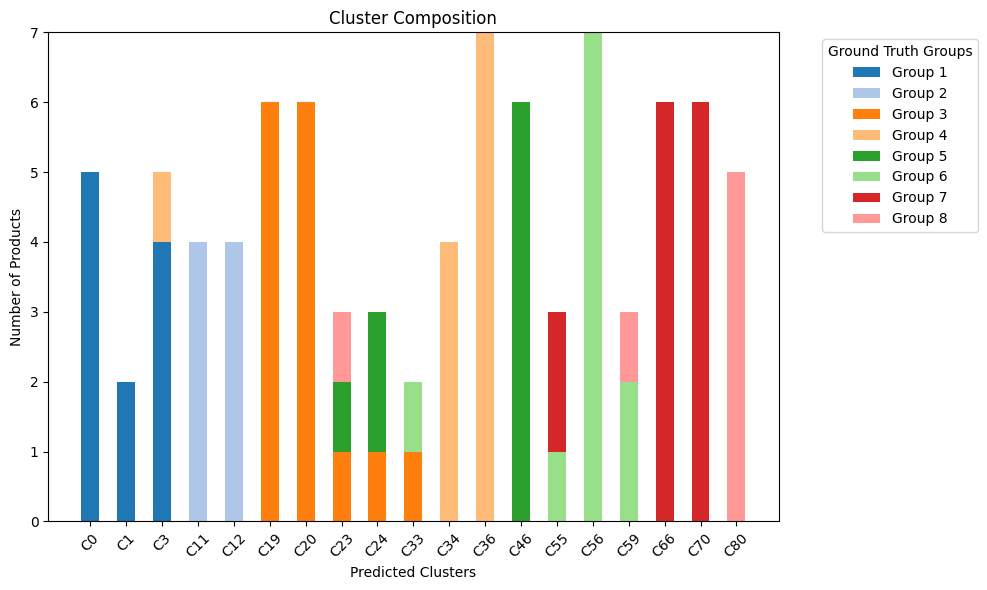


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.7249, NMI: 0.8317

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P7', 'G1_P9', 'G1_P10', 'G1_P11']
Cluster 4: ['G1_P5', 'G7_P5', 'G7_P8', 'G7_P9', 'G7_P10']
Cluster 5: ['G1_P6', 'G3_P4', 'G4_P6', 'G5_P8', 'G2_P5']
Cluster 7: ['G6_P10', 'G1_P8', 'G6_P1', 'G6_P3', 'G6_P5', 'G6_P6', 'G6_P8', 'G6_P9']
Cluster 11: ['G2_P7', 'G2_P1', 'G2_P4', 'G5_P6']
Cluster 12: ['G2_P6', 'G2_P8', 'G2_P2', 'G2_P3']
Cluster 19: ['G3_P14', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13']
Cluster 33: ['G3_P15']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P3', 'G5_P4', 'G5_P5', 'G5_P7', 'G5_P9', 'G5_P1', 'G5_P2']
Cluster 56: ['G6_P2', 'G6_P11', 'G6_P4', 'G6_P7']
Cluster 66: ['G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P6', 'G7_P7', 'G7_P11', 'G7_P12', 'G7_P13', 'G7

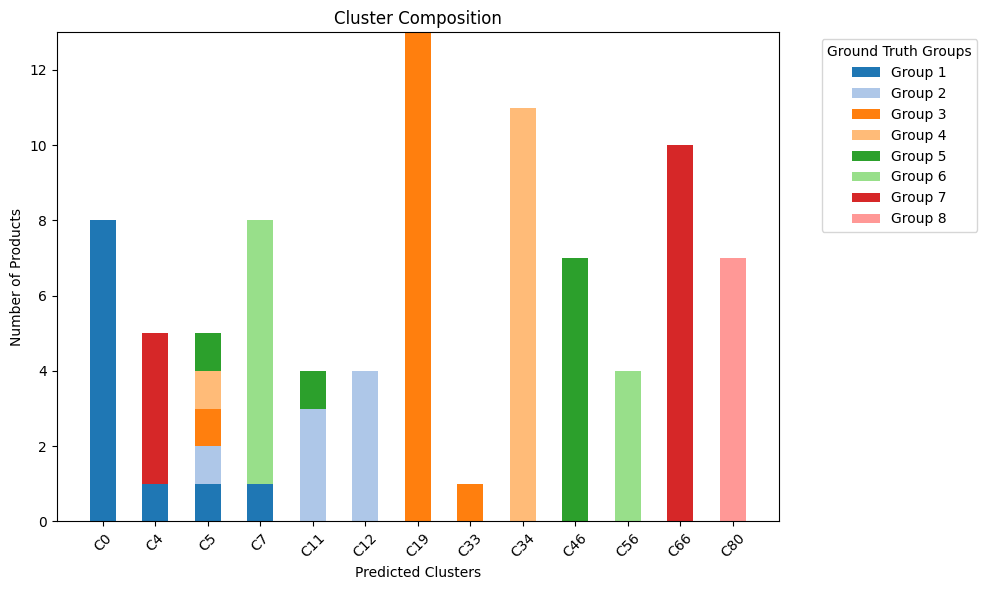


Iteration 10/10

Running Algorithm cluster_metric_2
Algorithm cluster_metric_2 - ARI: 0.1818, NMI: 0.6855

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P5']
Cluster 1: ['G1_P2', 'G4_P5']
Cluster 2: ['G1_P3', 'G1_P4']
Cluster 5: ['G5_P3', 'G1_P11', 'G1_P6']
Cluster 6: ['G1_P9', 'G1_P7']
Cluster 7: ['G1_P10', 'G1_P8']
Cluster 11: ['G2_P1', 'G2_P2']
Cluster 13: ['G2_P7', 'G2_P8', 'G2_P3']
Cluster 14: ['G2_P4', 'G3_P13']
Cluster 15: ['G2_P6', 'G2_P5']
Cluster 19: ['G3_P1', 'G3_P2']
Cluster 21: ['G3_P11', 'G3_P3']
Cluster 22: ['G3_P6', 'G3_P15', 'G3_P10', 'G3_P4']
Cluster 23: ['G3_P14', 'G3_P5']
Cluster 25: ['G3_P7', 'G3_P8']
Cluster 27: ['G3_P9', 'G3_P12']
Cluster 34: ['G4_P1', 'G4_P4']
Cluster 35: ['G4_P2', 'G4_P6']
Cluster 36: ['G4_P10', 'G4_P3', 'G4_P12', 'G4_P11']
Cluster 40: ['G4_P7', 'G4_P9']
Cluster 41: ['G8_P1', 'G4_P8']
Cluster 46: ['G5_P7', 'G5_P1']
Cluster 47: ['G5_P5', 'G5_P2']
Cluster 49: ['G5_P4', 'G5_P9']
Cluster 51: ['G5_P6', 'G5_P8']
Cluster 55: ['G6_P8', 'G6_P1']
C

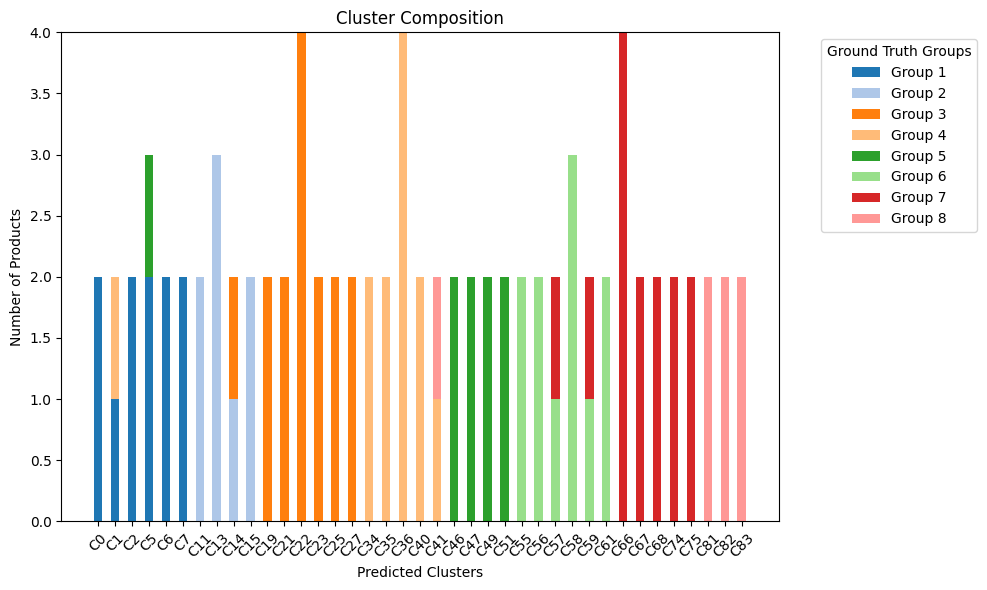


Running Algorithm cluster_metric_3
Algorithm cluster_metric_3 - ARI: 0.0725, NMI: 0.2852

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P4', 'G2_P5', 'G2_P6', 'G2_P7', 'G2_P8', 'G3_P1', 'G3_P2', 'G3_P3', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P7', 'G3_P8', 'G3_P9', 'G3_P10', 'G3_P11', 'G3_P12', 'G3_P13', 'G3_P14', 'G3_P15', 'G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12', 'G5_P7', 'G6_P1', 'G6_P3', 'G6_P4', 'G6_P6', 'G6_P7', 'G6_P8', 'G6_P11', 'G7_P1', 'G7_P2', 'G7_P3', 'G7_P4', 'G7_P5', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P10', 'G7_P11', 'G7_P12', 'G7_P13', 'G7_P14', 'G8_P1', 'G8_P3', 'G8_P4', 'G8_P5']
Cluster 46: ['G5_P1', 'G5_P2', 'G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P8', 'G5_P9', 'G8_P7', 'G8_P6']
Cluster 56: ['G6_P10', 'G8_P2', 'G6_P2', 'G6_P5', 'G6_P9']


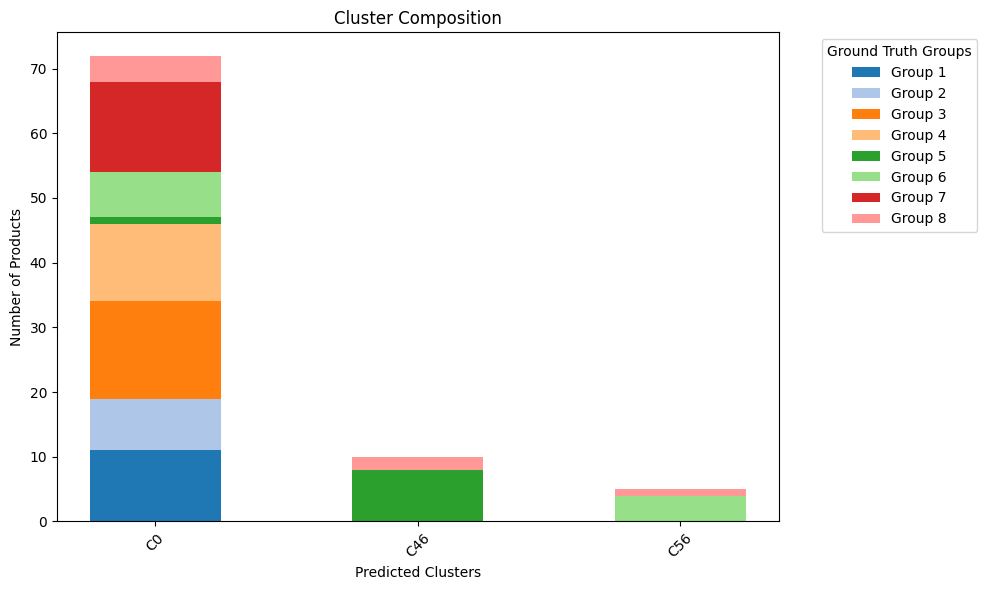


Running Algorithm cluster_metric_4
Algorithm cluster_metric_4 - ARI: 0.4385, NMI: 0.7283

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P3', 'G1_P5', 'G1_P7', 'G1_P8', 'G1_P10', 'G2_P4']
Cluster 1: ['G1_P2', 'G1_P4', 'G1_P6', 'G7_P4', 'G1_P11']
Cluster 8: ['G1_P9', 'G5_P7', 'G5_P9']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P8', 'G2_P1', 'G2_P2', 'G2_P3']
Cluster 15: ['G2_P5']
Cluster 19: ['G3_P1', 'G3_P5', 'G3_P6', 'G3_P8', 'G3_P9', 'G3_P12']
Cluster 20: ['G3_P7', 'G3_P2', 'G3_P10']
Cluster 21: ['G3_P3', 'G6_P8', 'G6_P1']
Cluster 22: ['G3_P14', 'G3_P15', 'G3_P4', 'G3_P13']
Cluster 29: ['G6_P10', 'G3_P11']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P4', 'G4_P6', 'G4_P7', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12']
Cluster 36: ['G5_P4', 'G4_P3', 'G5_P8']
Cluster 38: ['G4_P8', 'G4_P5']
Cluster 46: ['G5_P5', 'G5_P6', 'G5_P1', 'G5_P2']
Cluster 48: ['G5_P3', 'G7_P1']
Cluster 56: ['G6_P11', 'G6_P2', 'G6_P4', 'G6_P6', 'G6_P9']
Cluster 57: ['G6_P3', 'G7_P9', 'G7_P5']
Cluster 59: ['G7_P10', 'G6_P5', 'G7_P11'

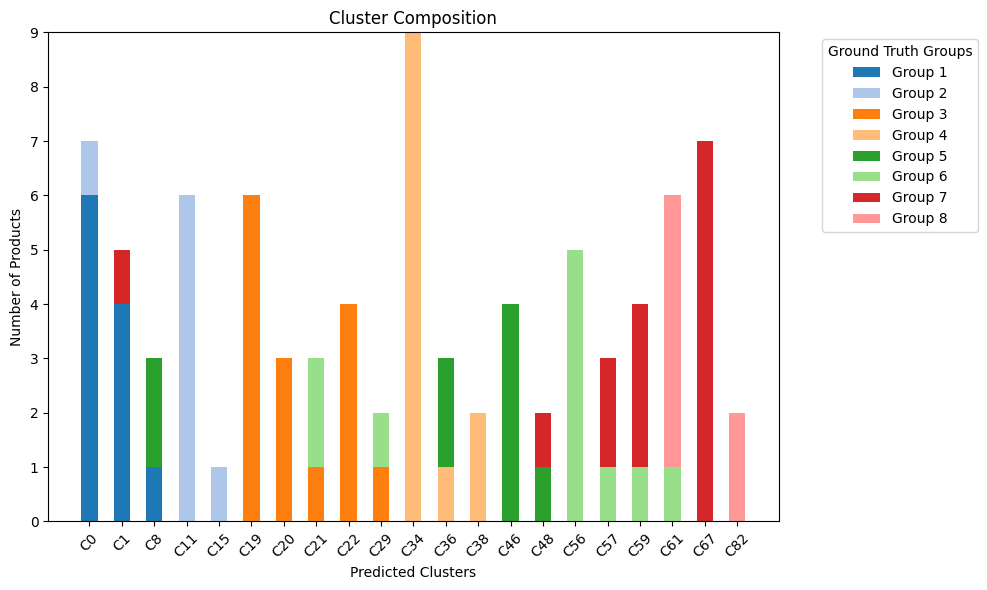


Running Algorithm cluster_metric_5
Algorithm cluster_metric_5 - ARI: 0.7193, NMI: 0.8644

Final Clustering Results:
Cluster 0: ['G1_P1', 'G1_P2', 'G1_P3', 'G1_P4', 'G1_P5', 'G1_P6', 'G1_P7', 'G1_P8', 'G1_P9', 'G1_P10', 'G1_P11', 'G2_P4']
Cluster 11: ['G2_P6', 'G2_P7', 'G2_P8', 'G2_P1', 'G2_P2', 'G2_P3', 'G2_P5']
Cluster 19: ['G3_P14', 'G3_P15', 'G3_P1', 'G3_P4', 'G3_P5', 'G3_P6', 'G3_P13']
Cluster 20: ['G3_P9', 'G3_P2', 'G3_P12']
Cluster 21: ['G3_P3', 'G3_P7', 'G3_P8', 'G3_P10', 'G3_P11']
Cluster 34: ['G4_P1', 'G4_P2', 'G4_P3', 'G4_P4', 'G4_P5', 'G4_P6', 'G4_P7', 'G4_P8', 'G4_P9', 'G4_P10', 'G4_P11', 'G4_P12']
Cluster 46: ['G5_P3', 'G5_P4', 'G5_P5', 'G5_P6', 'G5_P8', 'G5_P1', 'G5_P2']
Cluster 52: ['G5_P7', 'G5_P9']
Cluster 55: ['G6_P8', 'G6_P1']
Cluster 56: ['G6_P10', 'G6_P11', 'G6_P2', 'G6_P4', 'G6_P6']
Cluster 57: ['G6_P3', 'G7_P5']
Cluster 59: ['G6_P5', 'G6_P7', 'G6_P9']
Cluster 66: ['G7_P1']
Cluster 67: ['G7_P2', 'G7_P3', 'G7_P4', 'G7_P6', 'G7_P7', 'G7_P8', 'G7_P9', 'G7_P11', 'G7_

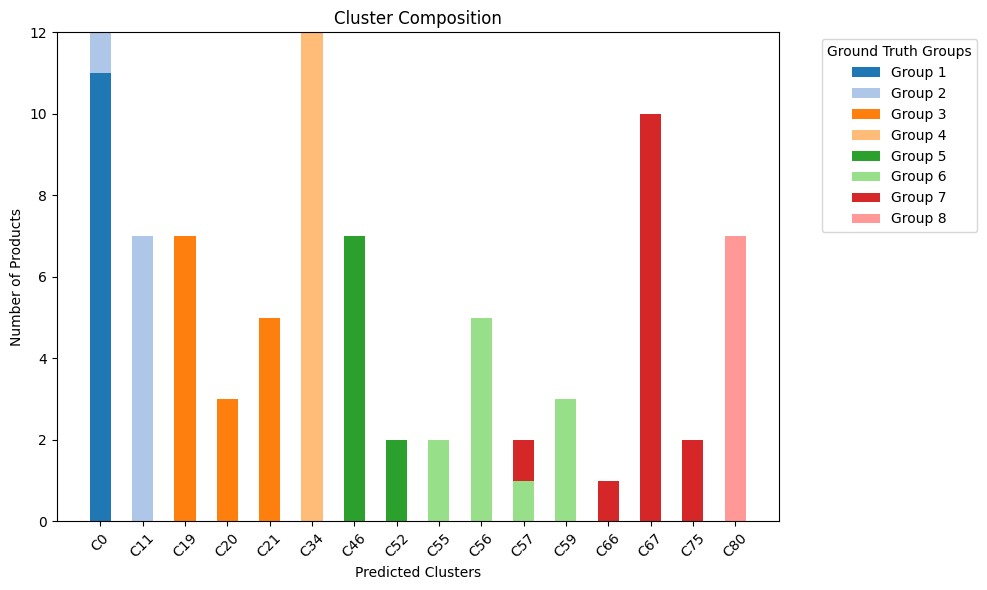


ARI and NMI results have been saved to '/content/drive/My Drive/clustering_results_varied_group_size.xlsx'.


In [ ]:


# Set random seed for reproducibility
np.random.seed(42)

# Parameters
num_groups = 8
products_per_group_list = np.random.randint(5, 16, size=num_groups).tolist()
total_products = sum(products_per_group_list)
iterations = 10



sigma_e = 1.5

eta = 1

def generate_data():
    product_ids = []
    group_ids = []
    product_to_group = {}

    # Generate product IDs and assign to groups with varying sizes
    for group, products_in_group in enumerate(products_per_group_list, start=1):
        for prod in range(1, products_in_group + 1):
            product_id = f'G{group}_P{prod}'
            product_ids.append(product_id)
            group_ids.append(group)
            product_to_group[product_id] = group

    product_id_to_index = {pid: idx for idx, pid in enumerate(product_ids)}
    index_to_product_id = {idx: pid for idx, pid in enumerate(product_ids)}
    gamma_matrix = np.zeros((total_products, total_products))

    r_values = np.zeros(total_products)
    l_values = np.zeros(total_products)

    index_offset = 0
    for group_idx, products_in_group in enumerate(products_per_group_list):
        group = group_idx + 1
        group_product_ids = [pid for pid in product_ids if product_to_group[pid] == group]
        group_indices = [product_id_to_index[pid] for pid in group_product_ids]
        n_k = len(group_indices)

        mu_r = np.random.normal(1, 0.2)
        mu_l = np.random.normal(1, 0.2)
        sigma_r = 0.2
        sigma_l = 0.2
        # Draw r_i and l_i for each product i in the group
        #mu_r = np.random.normal(theta_r, tau_r)
        #mu_l = np.random.normal(theta_l, tau_l)
        # Draw lambda_i and omega_i for each product i in the group
        r = np.random.normal(mu_r, sigma_r, size=n_k) #1
        l = np.random.normal(mu_l, sigma_l, size=n_k) #1

        for idx, idx_i in enumerate(group_indices):
            r_values[idx_i] = r[idx]
            l_values[idx_i] = l[idx]

        for idx_i in group_indices:
            for idx_j in group_indices:
                if idx_i != idx_j:
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] = (
                        r_values[idx_i]
                        + l_values[idx_j]
                        + e_ij
                    )

    all_indices = list(range(total_products))
    for idx_i in all_indices:
        group_i = product_to_group[index_to_product_id[idx_i]]
        for idx_j in all_indices:
            if idx_i != idx_j:
                group_j = product_to_group[index_to_product_id[idx_j]]
                if group_i != group_j:
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] = e_ij

    true_labels = np.array([product_to_group[pid] for pid in product_ids])
    return product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels






####################### Main Loop ##############################################

algorithms = [
             # cluster_metric_max_linkage


              cluster_metric_2,
                 cluster_metric_3,
              cluster_metric_4,
             cluster_metric_5
           #    cluster_metric_4,
           #   cluster_metric_7,
            #   cluster_metric_7_smaller_denom
           #   cluster_metric_8
              ]

# For storing ARI and NMI results for each algorithm
ari_results = {f'Algorithm_{i.__name__}': [] for i in algorithms}
nmi_results = {f'Algorithm_{i.__name__}': [] for i in algorithms}

for iter_num in range(iterations):
    print(f"\nIteration {iter_num+1}/{iterations}")

    # Generate data
    product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels = generate_data()

    # Set beta_hat equal to gamma_matrix
    beta_hat = gamma_matrix.copy()

    for cluster_metric_func in algorithms:
        print(f"\nRunning Algorithm {cluster_metric_func.__name__}")
        clusters = agglomerative_clustering(beta_hat, cluster_metric_func, index_to_product_id)

        # Map indices back to product IDs and output clusters
        predicted_labels = np.empty(len(product_ids), dtype=int)
        for k, cluster in clusters.items():
            for idx in cluster:
                predicted_labels[idx] = k

        # Compute ARI and NMI between perfect clustering and current clustering
        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        ari_results[f'Algorithm_{cluster_metric_func.__name__}'].append(ari)
        nmi_results[f'Algorithm_{cluster_metric_func.__name__}'].append(nmi)

        # Print clustering performance
        print(f"Algorithm {cluster_metric_func.__name__} - ARI: {ari:.4f}, NMI: {nmi:.4f}")

        # **Output Final Clustering Results**
        print("\nFinal Clustering Results:")
        for cluster_id, product_indices in clusters.items():
            product_list = [index_to_product_id[idx] for idx in product_indices]
            print(f"Cluster {cluster_id}: {product_list}")

        ## plot
        cluster_ids = sorted(clusters.keys())
        ground_truth_groups = sorted(set(true_labels))

        # Initialize a matrix to hold counts
        counts_matrix = np.zeros((len(cluster_ids), len(ground_truth_groups)))

        # Map ground truth group IDs to colors
        cmap = plt.get_cmap('tab20')  # You can choose any colormap you prefer
        colors = cmap.colors[:len(ground_truth_groups)]
        group_colors = {gt_group: colors[i] for i, gt_group in enumerate(ground_truth_groups)}

        # For legend labels
        group_labels = [f"G{gt_group}" for gt_group in ground_truth_groups]

        # Build counts matrix
        for i, cluster_id in enumerate(cluster_ids):
            product_indices = clusters[cluster_id]
            gt_labels_in_cluster = true_labels[list(product_indices)]
            for gt_group in ground_truth_groups:
                counts = np.sum(gt_labels_in_cluster == gt_group)
                counts_matrix[i, gt_group - 1] = counts  # Adjust index if ground truth groups start from 1

        # 2. Create the stacked bar chart using counts
        fig, ax = plt.subplots(figsize=(10, 6))

        bar_width = 0.5
        bar_positions = np.arange(len(cluster_ids))

        # Initialize the bottom of the bar (for stacking)
        bottom = np.zeros(len(cluster_ids))

        for i, gt_group in enumerate(ground_truth_groups):
            counts = counts_matrix[:, i]
            ax.bar(bar_positions, counts, bar_width, bottom=bottom, color=group_colors[gt_group], label=f"Group {gt_group}")
            bottom += counts  # Update the bottom for the next segment

        # 3. Add labels and legend
        ax.set_xlabel('Predicted Clusters')
        ax.set_ylabel('Number of Products')
        ax.set_title(f'Cluster Composition')
        ax.set_xticks(bar_positions)
        ax.set_xticklabels([f'C{cluster_id}' for cluster_id in cluster_ids], rotation=45)
        ax.legend(title='Ground Truth Groups', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

# Create DataFrames from the results dictionaries
ari_df = pd.DataFrame(ari_results)
nmi_df = pd.DataFrame(nmi_results)

# Add iteration numbers as a column
ari_df.insert(0, 'Iteration', range(1, iterations + 1))
nmi_df.insert(0, 'Iteration', range(1, iterations + 1))

# Define the path to save the Excel file in your Google Drive
drive_excel_filename = '/content/drive/My Drive/clustering_results_varied_group_size.xlsx'

# Save the DataFrames to the Excel file in Google Drive
with pd.ExcelWriter(drive_excel_filename) as writer:
    ari_df.to_excel(writer, sheet_name='ARI', index=False)
    nmi_df.to_excel(writer, sheet_name='NMI', index=False)

print(f"\nARI and NMI results have been saved to '{drive_excel_filename}'.")


# find the time needed for execution, algorithm 4

In [ ]:


# Global placeholders (overwritten in loop)
num_groups = 8
products_per_group = 10
total_products = num_groups * products_per_group
sigma_e = 1.5
eta = 1  # fixed as requested

#################### Updated Data Generator ####################

def generate_data():
    global total_products  # must be updated externally before calling
    # Generate product IDs and assign to groups
    product_ids = []
    group_ids = []
    product_to_group = {}
    for group in range(1, num_groups + 1):
        for prod in range(1, products_per_group + 1):
            product_id = f'G{group}_P{prod}'
            product_ids.append(product_id)
            group_ids.append(group)
            product_to_group[product_id] = group

    product_id_to_index = {pid: idx for idx, pid in enumerate(product_ids)}
    index_to_product_id = {idx: pid for idx, pid in enumerate(product_ids)}
    gamma_matrix = np.zeros((total_products, total_products))

    r_values = np.zeros(total_products)
    l_values = np.zeros(total_products)

    for group in range(1, num_groups + 1):
        group_product_ids = [pid for pid in product_ids if product_to_group[pid] == group]
        group_indices = [product_id_to_index[pid] for pid in group_product_ids]
        n_k = len(group_indices)

        mu_r = np.random.normal(1, 0.2)
        mu_l = np.random.normal(1, 0.2)
        sigma_r = 0.2
        sigma_l = 0.2

        r = np.random.normal(mu_r, sigma_r, size=n_k)
        l = np.random.normal(mu_l, sigma_l, size=n_k)

        for idx, idx_i in enumerate(group_indices):
            r_values[idx_i] = r[idx]
            l_values[idx_i] = l[idx]

        for idx_i in group_indices:
            for idx_j in group_indices:
                if idx_i != idx_j:
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] = r_values[idx_i] + l_values[idx_j] + e_ij

    all_indices = list(range(total_products))
    for idx_i in all_indices:
        group_i = product_to_group[index_to_product_id[idx_i]]
        for idx_j in all_indices:
            if idx_i != idx_j:
                group_j = product_to_group[index_to_product_id[idx_j]]
                if group_i != group_j:
                    e_ij = np.random.normal(0, sigma_e)
                    gamma_matrix[idx_i, idx_j] = e_ij

    true_labels = np.array([product_to_group[pid] for pid in product_ids])
    return product_ids, product_id_to_index, index_to_product_id, gamma_matrix, true_labels



#################### Benchmark Setup ####################

group_numbers = [4, 8, 16]
group_sizes = [5, 10, 20]
summary = []

for gn in group_numbers:
    for gs in group_sizes:
        num_groups = gn
        products_per_group = gs
        total_products = num_groups * products_per_group

        print(f"Testing: Groups = {gn}, Group Size = {gs}, Total = {total_products}")

        # Generate data
        product_ids, product_id_to_index, index_to_product_id, beta_hat, true_labels = generate_data()

        # Time execution
        start_time = time.time()
        clusters = agglomerative_clustering(beta_hat, cluster_metric_4)
        end_time = time.time()

        elapsed = end_time - start_time
        summary.append({
            'num_groups': gn,
            'group_size': gs,
            'total_products': total_products,
            'time_seconds': elapsed
        })

# Summary table
summary_df = pd.DataFrame(summary)
print("\n=== Execution Time Summary ===")
print(summary_df)


Testing: Groups = 4, Group Size = 5, Total = 20
Testing: Groups = 4, Group Size = 10, Total = 40
Testing: Groups = 4, Group Size = 20, Total = 80
Testing: Groups = 8, Group Size = 5, Total = 40
Testing: Groups = 8, Group Size = 10, Total = 80
Testing: Groups = 8, Group Size = 20, Total = 160
Testing: Groups = 16, Group Size = 5, Total = 80
Testing: Groups = 16, Group Size = 10, Total = 160
Testing: Groups = 16, Group Size = 20, Total = 320


KeyboardInterrupt: 

In [ ]:
# Summary table
summary_df = pd.DataFrame(summary)
print("\n=== Execution Time Summary ===")
print(summary_df)



=== Execution Time Summary ===
   num_groups  group_size  total_products  time_seconds
0           4           5              20      2.495253
1           4          10              40     17.494523
2           4          20              80    164.670907
3           8           5              40     11.980703
4           8          10              80    160.205857
5           8          20             160   2395.551404
6          16           5              80    169.624499
7          16          10             160   2481.225579


In [ ]:
# prompt: save summary_df into google drive.



# Define the path to save the CSV file in your Google Drive
drive_csv_filename = '/content/drive/My Drive/execution_time_summary.csv'

# Save the DataFrame to the CSV file in Google Drive
summary_df.to_csv(drive_csv_filename, index=False)

print(f"\nExecution time summary has been saved to '{drive_csv_filename}'.")



Execution time summary has been saved to '/content/drive/My Drive/execution_time_summary.csv'.
